In [1]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors
from matplotlib import cm
import matplotlib.gridspec as gridspec
#from matplotlib.legend_handler import HandlerPatch
import seaborn as sns
import re
import csv
from collections import defaultdict
from IPython.display import display
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

/tmp/ipykernel_4569/174134561.py:16: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


# Annotation from NCBI

In [2]:
dfAllAnnotation = pd.read_csv("/home/avignal/Stage_M2/RFMix/GCF_003254395.2_Amel_HAv3.1_genomic.gff_NO_HEADERS", sep="\t", header=None)
dfAllAnnotation.columns = ['sequence','source','feature','start','end','score','strand','phase','attributes']
#Mean positions of annotations in Mb and in bp
dfAllAnnotation['PosMb'] = (dfAllAnnotation['end'] + dfAllAnnotation['start']) / 2000000
dfAllAnnotation['Pos'] = (dfAllAnnotation['end'] + dfAllAnnotation['start']) / 2
# Only keep genes on autosomes
dfGenes = dfAllAnnotation.loc[(dfAllAnnotation.feature == 'gene') & (dfAllAnnotation.sequence.str.contains('^NC',regex=True)),:]
#remove mitochondria
dfGenes = dfGenes.loc[dfGenes.sequence != 'NC_001566.1',:]
# Column with chromosomes in numeric format
dfGenes['chrom'] = 0
dfGenes.loc[dfGenes.sequence == 'NC_037638.1','chrom'] = 1
dfGenes.loc[dfGenes.sequence == 'NC_037639.1','chrom'] = 2
dfGenes.loc[dfGenes.sequence == 'NC_037640.1','chrom'] = 3
dfGenes.loc[dfGenes.sequence == 'NC_037641.1','chrom'] = 4
dfGenes.loc[dfGenes.sequence == 'NC_037642.1','chrom'] = 5
dfGenes.loc[dfGenes.sequence == 'NC_037643.1','chrom'] = 6
dfGenes.loc[dfGenes.sequence == 'NC_037644.1','chrom'] = 7
dfGenes.loc[dfGenes.sequence == 'NC_037645.1','chrom'] = 8
dfGenes.loc[dfGenes.sequence == 'NC_037646.1','chrom'] = 9
dfGenes.loc[dfGenes.sequence == 'NC_037647.1','chrom'] = 10
dfGenes.loc[dfGenes.sequence == 'NC_037648.1','chrom'] = 11
dfGenes.loc[dfGenes.sequence == 'NC_037649.1','chrom'] = 12
dfGenes.loc[dfGenes.sequence == 'NC_037650.1','chrom'] = 13
dfGenes.loc[dfGenes.sequence == 'NC_037651.1','chrom'] = 14
dfGenes.loc[dfGenes.sequence == 'NC_037652.1','chrom'] = 15
dfGenes.loc[dfGenes.sequence == 'NC_037653.1','chrom'] = 16
#Only retain gnomon genes (the NCBI eukaryotic gene prediction tool), to avoid redundancy
dfGnomon = dfGenes[dfGenes.source == 'Gnomon']
dfGnomon

,sequence,source,feature,start,end,score,strand,phase,attributes,PosMb,Pos,chrom
1,NC_037638.1,Gnomon,gene,9273.0,12174.0,.,-,.,"ID=gene-LOC551580;Dbxref=BEEBASE:GB42195,GeneI...",0.010724,10723.5,1
25,NC_037638.1,Gnomon,gene,10792.0,17180.0,.,+,.,"ID=gene-LOC551555;Dbxref=BEEBASE:GB42138,GeneI...",0.013986,13986.0,1
78,NC_037638.1,Gnomon,gene,17090.0,23457.0,.,-,.,"ID=gene-LOC726347;Dbxref=BEEBASE:GB42194,GeneI...",0.020273,20273.5,1
134,NC_037638.1,Gnomon,gene,28123.0,30958.0,.,-,.,"ID=gene-LOC726145;Dbxref=BEEBASE:GB42193,GeneI...",0.029541,29540.5,1
154,NC_037638.1,Gnomon,gene,29940.0,39215.0,.,+,.,"ID=gene-LOC551448;Dbxref=BEEBASE:GB42140,GeneI...",0.034577,34577.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...
535419,NC_037653.1,Gnomon,gene,7177691.0,7182838.0,.,-,.,"ID=gene-LOC725756;Dbxref=BEEBASE:GB45955,GeneI...",7.180264,7180264.5,16
535441,NC_037653.1,Gnomon,gene,7183150.0,7187898.0,.,-,.,ID=gene-LOC102654520;Dbxref=GeneID:102654520;N...,7.185524,7185524.0,16
535449,NC_037653.1,Gnomon,gene,7192243.0,7209406.0,.,+,.,"ID=gene-LOC412056;Dbxref=BEEBASE:GB45950,GeneI...",7.200825,7200824.5,16
535568,NC_037653.1,Gnomon,gene,7201213.0,7202267.0,.,-,.,ID=gene-LOC107965704;Dbxref=GeneID:107965704;N...,7.201740,7201740.0,16


# Plot Chromosome 1


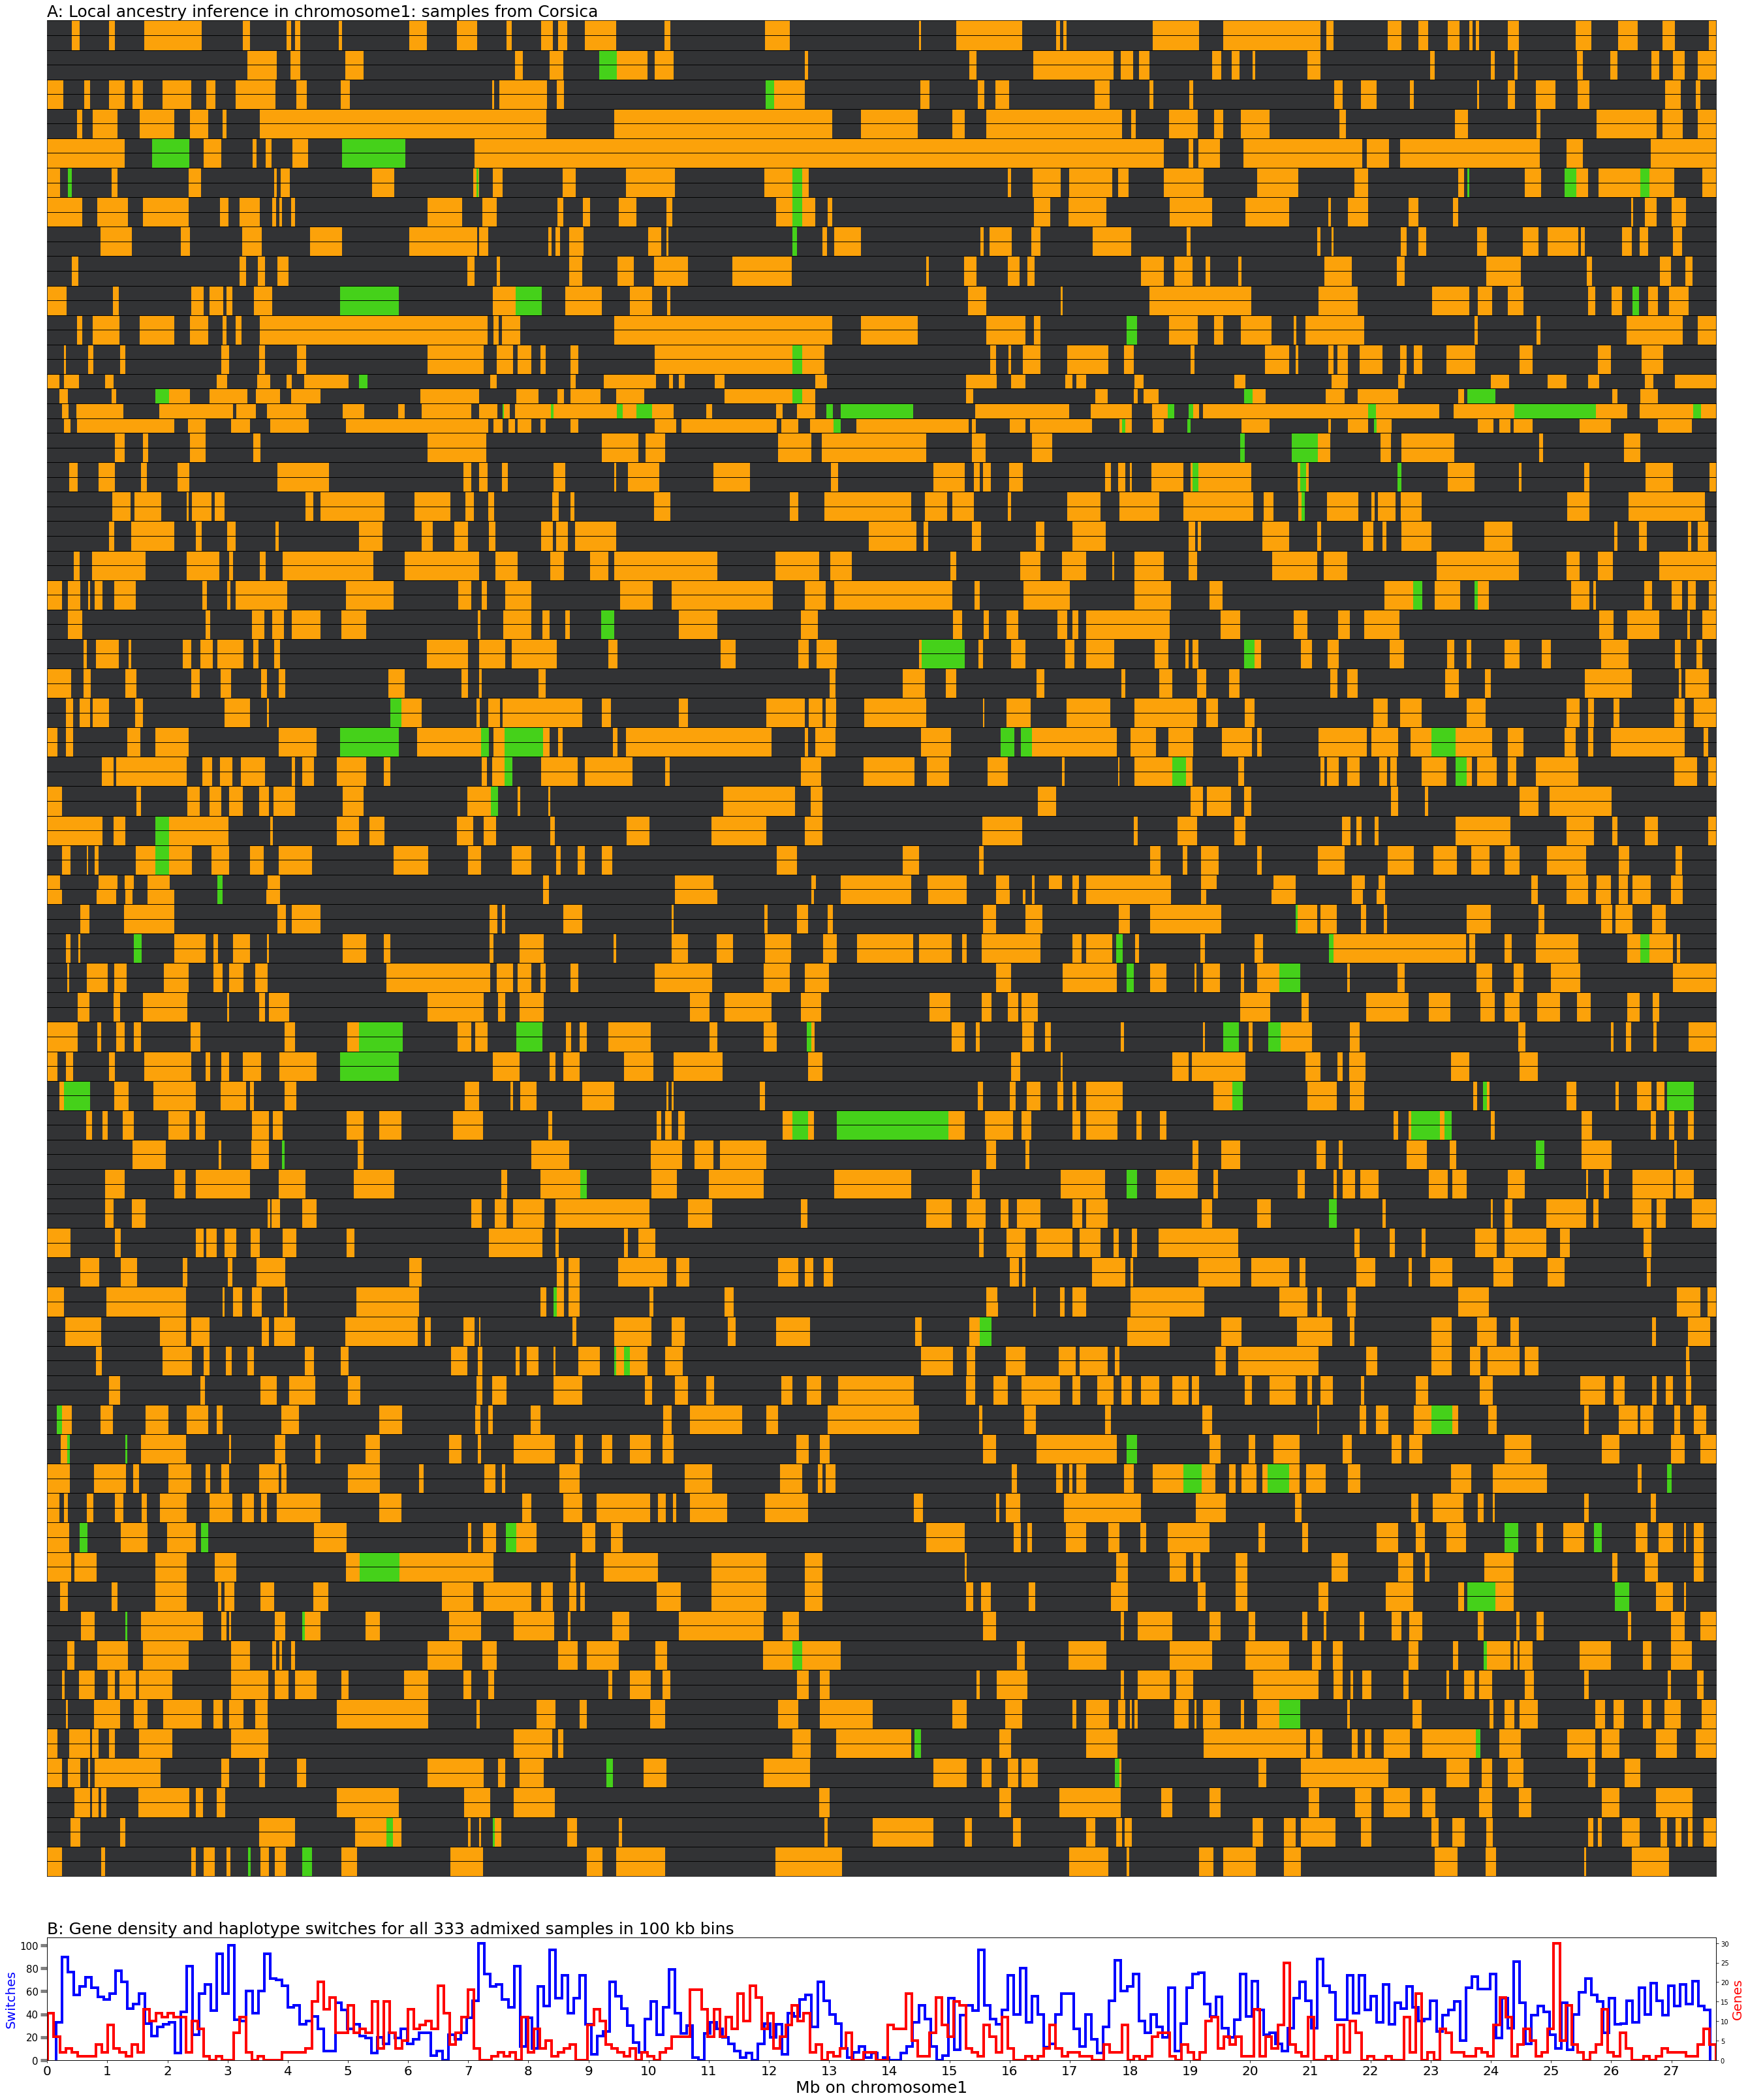

In [3]:
dataDict = {}
dataDictAgg = defaultdict(list)

chromosome = str(1)

with open('/home/avignal/Stage_M2/RFMix/SeqApiPopRFmixChr' + chromosome + '.msp.tsv') as csvFile:
    data=csv.reader(csvFile, delimiter = "\t")
    for row in data:
        if row:
            if not re.search('Subpopulation',row[0]):
                if re.search('chm',row[0]):
                    headers = row               #Get sample names
                    count = 0
                elif (not re.search('chm',row[0])) & (count == 0): #Initiate: first line into dictionary
                    for i in np.arange(6,len(row),1):
                        if row[i] == row[i]:
                            population = row[i]
                        else:
                            population = 9
                        dataDict[headers[i]] = [population,row[1],row[2],row[3],row[4]] #Assign population, start and end of CRF to sample
                    count = 1
                elif (count == 1):
                    for i in np.arange(6,len(row),1):
                        if row[i] == row[i]:
                            population = row[i]
                        else:
                            population = 9
                        if dataDict[headers[i]][0] == population:
                            dataDict[headers[i]][2] = row[2] #assign new End of CRF
                            dataDict[headers[i]][4] = row[4] #assign new End of CRF
                        elif dataDict[headers[i]][0] != population:     #change of population background
                            dataDictAgg["Sample"].append(headers[i]) #new entry for the sample
                            dataDictAgg["Start"].append(dataDict[headers[i]][1]) #
                            dataDictAgg["End"].append(dataDict[headers[i]][2])
                            dataDictAgg["StartGenet"].append(dataDict[headers[i]][3])
                            dataDictAgg["EndGenet"].append(dataDict[headers[i]][4])
                            dataDictAgg["Population"].append(dataDict[headers[i]][0])
                            dataDict[headers[i]] = [population,row[1],row[2],row[3],row[4]]
for i in np.arange(6,len(headers),1):
    dataDictAgg["Sample"].append(headers[i]) #new entry for the sample
    dataDictAgg["Start"].append(dataDict[headers[i]][1]) #
    dataDictAgg["End"].append(dataDict[headers[i]][2])
    dataDictAgg["StartGenet"].append(dataDict[headers[i]][3]) #
    dataDictAgg["EndGenet"].append(dataDict[headers[i]][4])
    dataDictAgg["Population"].append(dataDict[headers[i]][0])

dataAgg = pd.DataFrame.from_dict(dataDictAgg)
dataAgg = dataAgg.astype({'Start':'int','End':'int','StartGenet':'float','EndGenet':'float'})
dataAgg['Sample'] = dataAgg['Sample']
binWidth = 0.1 #in Mb
nbBins = math.ceil(max(dataAgg['End']/1000000) / binWidth)

# Add information on populations
dataSamples = pd.read_excel('/home/avignal/Stage_M2/SequenceGroups870_nouvelles.xlsx',sheet_name='869Samples')
dataSamples = dataSamples.loc[:,['name','RepresentsHive','CategPCA']]
dataSamples.columns = ['Sample','RepresentsHive','CategPCA']
dataSamples = dataSamples.set_index('Sample')
dataAgg = dataAgg.set_index('Sample')
dataAgg = dataAgg.join(dataSamples)
dataAgg = dataAgg.reset_index()

# Assign colour to segments
dataAgg['Colour'] =  "grey"
dataAgg.at[dataAgg.Population == "0",'Colour'] = "#323335ff"                    
dataAgg.at[dataAgg.Population == "1",'Colour'] = "#45d11aff"                     
dataAgg.at[dataAgg.Population == "2",'Colour'] = "#fca20aff"     
dataAgg


# Select samples to plot
#dataTableAggSampleSelection = dataAgg[dataAgg.Sample.str.contains('AOC',regex=True)]
dataTableAggSampleSelection = dataAgg[dataAgg.CategPCA == 'CorsicaNouvelles']
dataTableAggSampleSelection


# Sorted list of samples
sampleCor = dataTableAggSampleSelection['Sample'].unique().tolist()
sampleCor.sort()

#from itertools import chain, repeat

#sampleCor = list(chain.from_iterable(repeat(e, 2) for e in sampleCor))
#sampleCor

#import pandas as pd 
#from IPython.display import display 
#pd.set_option('display.max_rows', 2000) 
#display(dataTableAggSampleSelection)

ybins = len(sampleCor)
#space = (1 / (ybins + 1)) * 1 / 6
#figHeight = (ybins) # + 1) # * 3
figWidth = (max(dataAgg['End'])/5000000 * 8) # + space * 4
figHeight = figWidth / 1.7
#fig = plt.figure(figsize=(figWidth, figHeight))
#fig = plt.figure(figsize=(figWidth,4))
fig = plt.figure(figsize=(figWidth, figHeight))
#fig = plt.figure(constrained_layout=True, figsize=(45,40))

#fig.text(.35,.01, "Position (Mb)", fontsize=40)
#fig.text(0.05,0.50, "Samples from Corsica", fontsize=25, rotation='vertical',)

######################################################
##### First plot histogram of switches across all 333 samples
######################################################

ax = plt.axes([0.07, 0.23, 0.8, 0.1])

ax.hist(dataAgg[dataAgg.Start > 11712]['Start'],bins=nbBins, histtype='step', color = "blue", linewidth=4)
ax.set_xlim(0, max(dataAgg['End']))# /5000000)

xticks = list(np.arange(0,max(dataAgg['End']) ,1000000)) #* 5)
ax.set_xticks(xticks)        
ax.set_xticklabels([int(x / 1000000) for x in xticks], fontsize = 20)
plt.xlabel('Mb on chromosome' + chromosome, fontsize = 25)

ax.yaxis.set_tick_params(labelsize=15, length=10, width=5, color='grey')
ax.set_ylabel('Switches', fontsize = 20, color = "blue")

ax2 = ax.twinx()
chrGenesData = dfGnomon[(dfGnomon.chrom == int(chromosome))]
ax2.set_ylabel('Genes', fontsize = 20, color="red")
ax2.hist(chrGenesData['Pos'], bins=nbBins, histtype='step', color = "red", linewidth=4)

plt.title('B: Gene density and haplotype switches for all 333 admixed samples in 100 kb bins', fontsize = 25, loc='left')

######################################################
##### Then the samples from Corsica
######################################################

#fig.suptitle("Title", fontsize=96)
bottom = 0.38 #space
x_axis = 'yes'
count = 0
for i in sampleCor:
    count = count + 1
    left = 0 #space * 7
    width = figWidth
    height = (0.012)#/ybins)
    ax = plt.axes([0.07, bottom, 0.8, height])    
    if x_axis == 'yes':
        ax.axes.xaxis.set_visible(False)
        xticks = list(np.arange(0,max(dataAgg['End']/5000000) ,0.2)) #* 5)
        ax.set_xticks(xticks)        
        ax.set_xticklabels([int(x * 5) for x in xticks], fontsize = 15)
        plt.xlabel('Mb on chromosome 11', fontsize = 30)
        x_axis = 'false'
    else:
        ax.axes.xaxis.set_visible(False)
    if count == len(sampleCor):
        plt.title('A: Local ancestry inference in chromosome' + chromosome + ': samples from Corsica', fontsize = 25, loc='left')
    ax.axes.yaxis.set_visible(False)
    ax.set_xlim(0, max(dataAgg['End'])/5000000)
    bottom = bottom + height # + space
    dataSample = dataTableAggSampleSelection[dataTableAggSampleSelection.Sample == i]
    for index, row  in dataSample.iterrows():
        start = row["Start"] / 5000000
        end = row["End"] / 5000000
        color = row["Colour"]
        #ax.hlines(0, start, end, colors='orange', linestyles='solid')#, label='', *, data=None, **kwargs)[source]
        ax.axvspan(start, end, ymin=0.0, ymax=1.0, alpha=1, color=color)

#plt.tight_layout()        
#fig



# Plot Chromosome 2



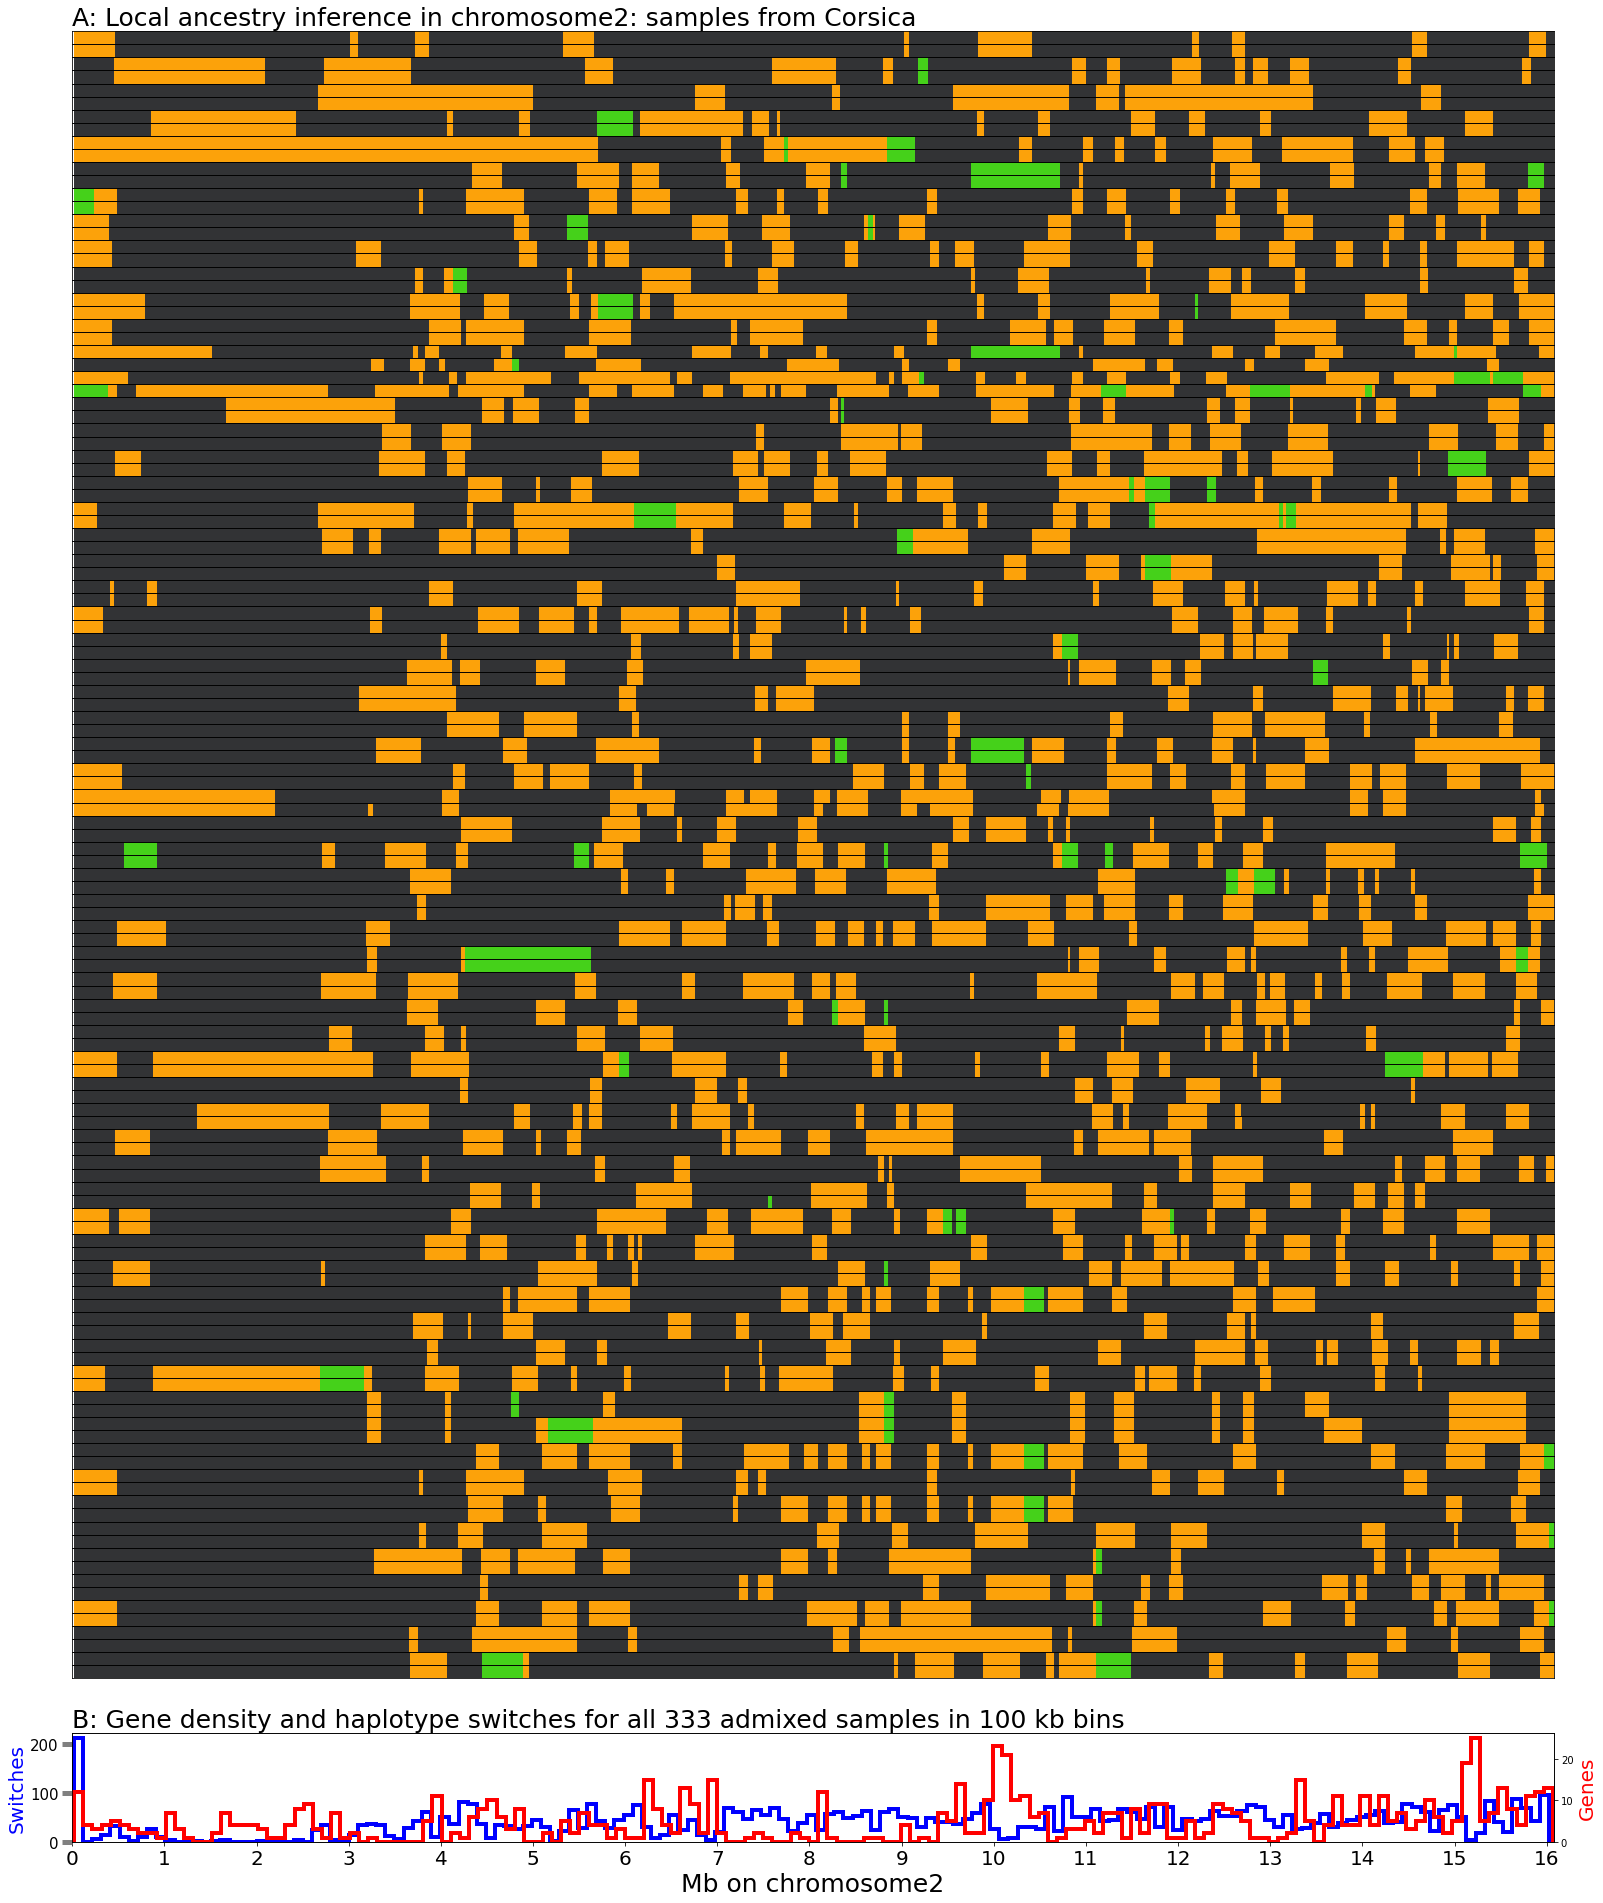

In [4]:
dataDict = {}
dataDictAgg = defaultdict(list)

chromosome = str(2)

with open('/home/avignal/Stage_M2/RFMix/SeqApiPopRFmixChr' + chromosome + '.msp.tsv') as csvFile:
    data=csv.reader(csvFile, delimiter = "\t")
    for row in data:
        if row:
            if not re.search('Subpopulation',row[0]):
                if re.search('chm',row[0]):
                    headers = row               #Get sample names
                    count = 0
                elif (not re.search('chm',row[0])) & (count == 0): #Initiate: first line into dictionary
                    for i in np.arange(6,len(row),1):
                        if row[i] == row[i]:
                            population = row[i]
                        else:
                            population = 9
                        dataDict[headers[i]] = [population,row[1],row[2],row[3],row[4]] #Assign population, start and end of CRF to sample
                    count = 1
                elif (count == 1):
                    for i in np.arange(6,len(row),1):
                        if row[i] == row[i]:
                            population = row[i]
                        else:
                            population = 9
                        if dataDict[headers[i]][0] == population:
                            dataDict[headers[i]][2] = row[2] #assign new End of CRF
                            dataDict[headers[i]][4] = row[4] #assign new End of CRF
                        elif dataDict[headers[i]][0] != population:     #change of population background
                            dataDictAgg["Sample"].append(headers[i]) #new entry for the sample
                            dataDictAgg["Start"].append(dataDict[headers[i]][1]) #
                            dataDictAgg["End"].append(dataDict[headers[i]][2])
                            dataDictAgg["StartGenet"].append(dataDict[headers[i]][3])
                            dataDictAgg["EndGenet"].append(dataDict[headers[i]][4])
                            dataDictAgg["Population"].append(dataDict[headers[i]][0])
                            dataDict[headers[i]] = [population,row[1],row[2],row[3],row[4]]
for i in np.arange(6,len(headers),1):
    dataDictAgg["Sample"].append(headers[i]) #new entry for the sample
    dataDictAgg["Start"].append(dataDict[headers[i]][1]) #
    dataDictAgg["End"].append(dataDict[headers[i]][2])
    dataDictAgg["StartGenet"].append(dataDict[headers[i]][3]) #
    dataDictAgg["EndGenet"].append(dataDict[headers[i]][4])
    dataDictAgg["Population"].append(dataDict[headers[i]][0])

dataAgg = pd.DataFrame.from_dict(dataDictAgg)
dataAgg = dataAgg.astype({'Start':'int','End':'int','StartGenet':'float','EndGenet':'float'})
dataAgg['Sample'] = dataAgg['Sample']
binWidth = 0.1 #in Mb
nbBins = math.ceil(max(dataAgg['End']/1000000) / binWidth)

# Add information on populations
dataSamples = pd.read_excel('/home/avignal/Stage_M2/SequenceGroups870_nouvelles.xlsx',sheet_name='869Samples')
dataSamples = dataSamples.loc[:,['name','RepresentsHive','CategPCA']]
dataSamples.columns = ['Sample','RepresentsHive','CategPCA']
dataSamples = dataSamples.set_index('Sample')
dataAgg = dataAgg.set_index('Sample')
dataAgg = dataAgg.join(dataSamples)
dataAgg = dataAgg.reset_index()

# Assign colour to segments
dataAgg['Colour'] =  "grey"
dataAgg.at[dataAgg.Population == "0",'Colour'] = "#323335ff"                    
dataAgg.at[dataAgg.Population == "1",'Colour'] = "#45d11aff"                     
dataAgg.at[dataAgg.Population == "2",'Colour'] = "#fca20aff"     
dataAgg


# Select samples to plot
#dataTableAggSampleSelection = dataAgg[dataAgg.Sample.str.contains('AOC',regex=True)]
dataTableAggSampleSelection = dataAgg[dataAgg.CategPCA == 'CorsicaNouvelles']
dataTableAggSampleSelection


# Sorted list of samples
sampleCor = dataTableAggSampleSelection['Sample'].unique().tolist()
sampleCor.sort()

#from itertools import chain, repeat

#sampleCor = list(chain.from_iterable(repeat(e, 2) for e in sampleCor))
#sampleCor

#import pandas as pd 
#from IPython.display import display 
#pd.set_option('display.max_rows', 2000) 
#display(dataTableAggSampleSelection)

ybins = len(sampleCor)
#space = (1 / (ybins + 1)) * 1 / 6
#figHeight = (ybins) # + 1) # * 3
figWidth = (max(dataAgg['End'])/5000000 * 8) # + space * 4
figHeight = figWidth / 1.7
#fig = plt.figure(figsize=(figWidth, figHeight))
#fig = plt.figure(figsize=(figWidth,4))
fig = plt.figure(figsize=(figWidth, figHeight))
#fig = plt.figure(constrained_layout=True, figsize=(45,40))

#fig.text(.35,.01, "Position (Mb)", fontsize=40)
#fig.text(0.05,0.50, "Samples from Corsica", fontsize=25, rotation='vertical',)

######################################################
##### First plot histogram of switches across all 333 samples
######################################################

ax = plt.axes([0.07, 0.23, 0.8, 0.1])

ax.hist(dataAgg[dataAgg.Start > 11712]['Start'],bins=nbBins, histtype='step', color = "blue", linewidth=4)
ax.set_xlim(0, max(dataAgg['End']))# /5000000)

xticks = list(np.arange(0,max(dataAgg['End']) ,1000000)) #* 5)
ax.set_xticks(xticks)        
ax.set_xticklabels([int(x / 1000000) for x in xticks], fontsize = 20)
plt.xlabel('Mb on chromosome' + chromosome, fontsize = 25)

ax.yaxis.set_tick_params(labelsize=15, length=10, width=5, color='grey')
ax.set_ylabel('Switches', fontsize = 20, color = "blue")

ax2 = ax.twinx()
chrGenesData = dfGnomon[(dfGnomon.chrom == int(chromosome))]
ax2.set_ylabel('Genes', fontsize = 20, color="red")
ax2.hist(chrGenesData['Pos'], bins=nbBins, histtype='step', color = "red", linewidth=4)

plt.title('B: Gene density and haplotype switches for all 333 admixed samples in 100 kb bins', fontsize = 25, loc='left')

######################################################
##### Then the samples from Corsica
######################################################

#fig.suptitle("Title", fontsize=96)
bottom = 0.38 #space
x_axis = 'yes'
count = 0
for i in sampleCor:
    count = count + 1
    left = 0 #space * 7
    width = figWidth
    height = (0.012)#/ybins)
    ax = plt.axes([0.07, bottom, 0.8, height])    
    if x_axis == 'yes':
        ax.axes.xaxis.set_visible(False)
        xticks = list(np.arange(0,max(dataAgg['End']/5000000) ,0.2)) #* 5)
        ax.set_xticks(xticks)        
        ax.set_xticklabels([int(x * 5) for x in xticks], fontsize = 15)
        plt.xlabel('Mb on chromosome 11', fontsize = 30)
        x_axis = 'false'
    else:
        ax.axes.xaxis.set_visible(False)
    if count == len(sampleCor):
        plt.title('A: Local ancestry inference in chromosome' + chromosome + ': samples from Corsica', fontsize = 25, loc='left')
    ax.axes.yaxis.set_visible(False)
    ax.set_xlim(0, max(dataAgg['End'])/5000000)
    bottom = bottom + height # + space
    dataSample = dataTableAggSampleSelection[dataTableAggSampleSelection.Sample == i]
    for index, row  in dataSample.iterrows():
        start = row["Start"] / 5000000
        end = row["End"] / 5000000
        color = row["Colour"]
        #ax.hlines(0, start, end, colors='orange', linestyles='solid')#, label='', *, data=None, **kwargs)[source]
        ax.axvspan(start, end, ymin=0.0, ymax=1.0, alpha=1, color=color)

#plt.tight_layout()        
#fig



## Plot Chromosome 3

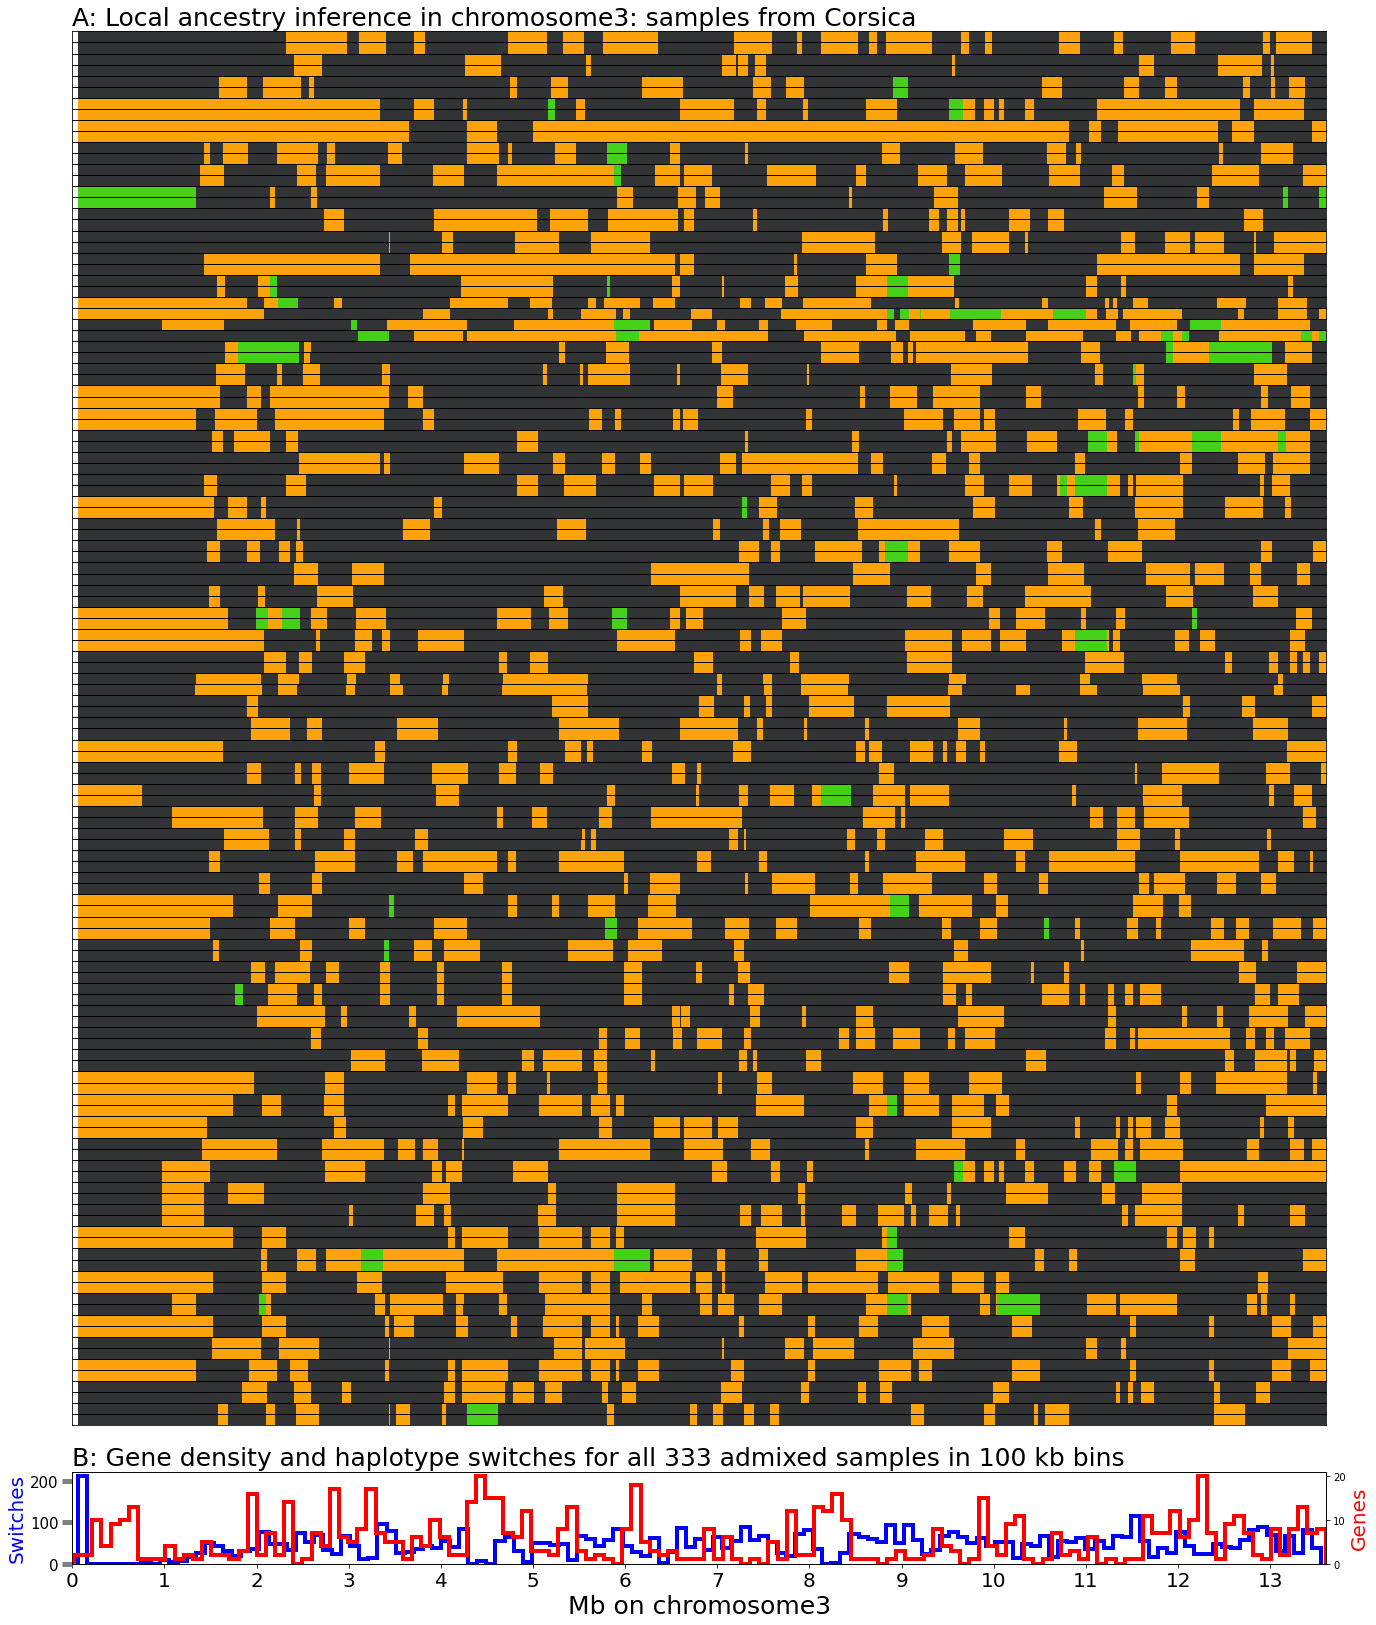

In [5]:
dataDict = {}
dataDictAgg = defaultdict(list)

chromosome = str(3)

with open('/home/avignal/Stage_M2/RFMix/SeqApiPopRFmixChr' + chromosome + '.msp.tsv') as csvFile:
    data=csv.reader(csvFile, delimiter = "\t")
    for row in data:
        if row:
            if not re.search('Subpopulation',row[0]):
                if re.search('chm',row[0]):
                    headers = row               #Get sample names
                    count = 0
                elif (not re.search('chm',row[0])) & (count == 0): #Initiate: first line into dictionary
                    for i in np.arange(6,len(row),1):
                        if row[i] == row[i]:
                            population = row[i]
                        else:
                            population = 9
                        dataDict[headers[i]] = [population,row[1],row[2],row[3],row[4]] #Assign population, start and end of CRF to sample
                    count = 1
                elif (count == 1):
                    for i in np.arange(6,len(row),1):
                        if row[i] == row[i]:
                            population = row[i]
                        else:
                            population = 9
                        if dataDict[headers[i]][0] == population:
                            dataDict[headers[i]][2] = row[2] #assign new End of CRF
                            dataDict[headers[i]][4] = row[4] #assign new End of CRF
                        elif dataDict[headers[i]][0] != population:     #change of population background
                            dataDictAgg["Sample"].append(headers[i]) #new entry for the sample
                            dataDictAgg["Start"].append(dataDict[headers[i]][1]) #
                            dataDictAgg["End"].append(dataDict[headers[i]][2])
                            dataDictAgg["StartGenet"].append(dataDict[headers[i]][3])
                            dataDictAgg["EndGenet"].append(dataDict[headers[i]][4])
                            dataDictAgg["Population"].append(dataDict[headers[i]][0])
                            dataDict[headers[i]] = [population,row[1],row[2],row[3],row[4]]
for i in np.arange(6,len(headers),1):
    dataDictAgg["Sample"].append(headers[i]) #new entry for the sample
    dataDictAgg["Start"].append(dataDict[headers[i]][1]) #
    dataDictAgg["End"].append(dataDict[headers[i]][2])
    dataDictAgg["StartGenet"].append(dataDict[headers[i]][3]) #
    dataDictAgg["EndGenet"].append(dataDict[headers[i]][4])
    dataDictAgg["Population"].append(dataDict[headers[i]][0])

dataAgg = pd.DataFrame.from_dict(dataDictAgg)
dataAgg = dataAgg.astype({'Start':'int','End':'int','StartGenet':'float','EndGenet':'float'})
dataAgg['Sample'] = dataAgg['Sample']
binWidth = 0.1 #in Mb
nbBins = math.ceil(max(dataAgg['End']/1000000) / binWidth)

# Add information on populations
dataSamples = pd.read_excel('/home/avignal/Stage_M2/SequenceGroups870_nouvelles.xlsx',sheet_name='869Samples')
dataSamples = dataSamples.loc[:,['name','RepresentsHive','CategPCA']]
dataSamples.columns = ['Sample','RepresentsHive','CategPCA']
dataSamples = dataSamples.set_index('Sample')
dataAgg = dataAgg.set_index('Sample')
dataAgg = dataAgg.join(dataSamples)
dataAgg = dataAgg.reset_index()

# Assign colour to segments
dataAgg['Colour'] =  "grey"
dataAgg.at[dataAgg.Population == "0",'Colour'] = "#323335ff"                    
dataAgg.at[dataAgg.Population == "1",'Colour'] = "#45d11aff"                     
dataAgg.at[dataAgg.Population == "2",'Colour'] = "#fca20aff"     
dataAgg


# Select samples to plot
#dataTableAggSampleSelection = dataAgg[dataAgg.Sample.str.contains('AOC',regex=True)]
dataTableAggSampleSelection = dataAgg[dataAgg.CategPCA == 'CorsicaNouvelles']
dataTableAggSampleSelection


# Sorted list of samples
sampleCor = dataTableAggSampleSelection['Sample'].unique().tolist()
sampleCor.sort()

#from itertools import chain, repeat

#sampleCor = list(chain.from_iterable(repeat(e, 2) for e in sampleCor))
#sampleCor

#import pandas as pd 
#from IPython.display import display 
#pd.set_option('display.max_rows', 2000) 
#display(dataTableAggSampleSelection)

ybins = len(sampleCor)
#space = (1 / (ybins + 1)) * 1 / 6
#figHeight = (ybins) # + 1) # * 3
figWidth = (max(dataAgg['End'])/5000000 * 8) # + space * 4
figHeight = figWidth / 1.7
#fig = plt.figure(figsize=(figWidth, figHeight))
#fig = plt.figure(figsize=(figWidth,4))
fig = plt.figure(figsize=(figWidth, figHeight))
#fig = plt.figure(constrained_layout=True, figsize=(45,40))

#fig.text(.35,.01, "Position (Mb)", fontsize=40)
#fig.text(0.05,0.50, "Samples from Corsica", fontsize=25, rotation='vertical',)

######################################################
##### First plot histogram of switches across all 333 samples
######################################################

ax = plt.axes([0.07, 0.23, 0.8, 0.1])

ax.hist(dataAgg[dataAgg.Start > 11712]['Start'],bins=nbBins, histtype='step', color = "blue", linewidth=4)
ax.set_xlim(0, max(dataAgg['End']))# /5000000)

xticks = list(np.arange(0,max(dataAgg['End']) ,1000000)) #* 5)
ax.set_xticks(xticks)        
ax.set_xticklabels([int(x / 1000000) for x in xticks], fontsize = 20)
plt.xlabel('Mb on chromosome' + chromosome, fontsize = 25)

ax.yaxis.set_tick_params(labelsize=15, length=10, width=5, color='grey')
ax.set_ylabel('Switches', fontsize = 20, color = "blue")

ax2 = ax.twinx()
chrGenesData = dfGnomon[(dfGnomon.chrom == int(chromosome))]
ax2.set_ylabel('Genes', fontsize = 20, color="red")
ax2.hist(chrGenesData['Pos'], bins=nbBins, histtype='step', color = "red", linewidth=4)

plt.title('B: Gene density and haplotype switches for all 333 admixed samples in 100 kb bins', fontsize = 25, loc='left')

######################################################
##### Then the samples from Corsica
######################################################

#fig.suptitle("Title", fontsize=96)
bottom = 0.38 #space
x_axis = 'yes'
count = 0
for i in sampleCor:
    count = count + 1
    left = 0 #space * 7
    width = figWidth
    height = (0.012)#/ybins)
    ax = plt.axes([0.07, bottom, 0.8, height])    
    if x_axis == 'yes':
        ax.axes.xaxis.set_visible(False)
        xticks = list(np.arange(0,max(dataAgg['End']/5000000) ,0.2)) #* 5)
        ax.set_xticks(xticks)        
        ax.set_xticklabels([int(x * 5) for x in xticks], fontsize = 15)
        plt.xlabel('Mb on chromosome 11', fontsize = 30)
        x_axis = 'false'
    else:
        ax.axes.xaxis.set_visible(False)
    if count == len(sampleCor):
        plt.title('A: Local ancestry inference in chromosome' + chromosome + ': samples from Corsica', fontsize = 25, loc='left')
    ax.axes.yaxis.set_visible(False)
    ax.set_xlim(0, max(dataAgg['End'])/5000000)
    bottom = bottom + height # + space
    dataSample = dataTableAggSampleSelection[dataTableAggSampleSelection.Sample == i]
    for index, row  in dataSample.iterrows():
        start = row["Start"] / 5000000
        end = row["End"] / 5000000
        color = row["Colour"]
        #ax.hlines(0, start, end, colors='orange', linestyles='solid')#, label='', *, data=None, **kwargs)[source]
        ax.axvspan(start, end, ymin=0.0, ymax=1.0, alpha=1, color=color)

#plt.tight_layout()        
#fig



## Plot Chromosome 4

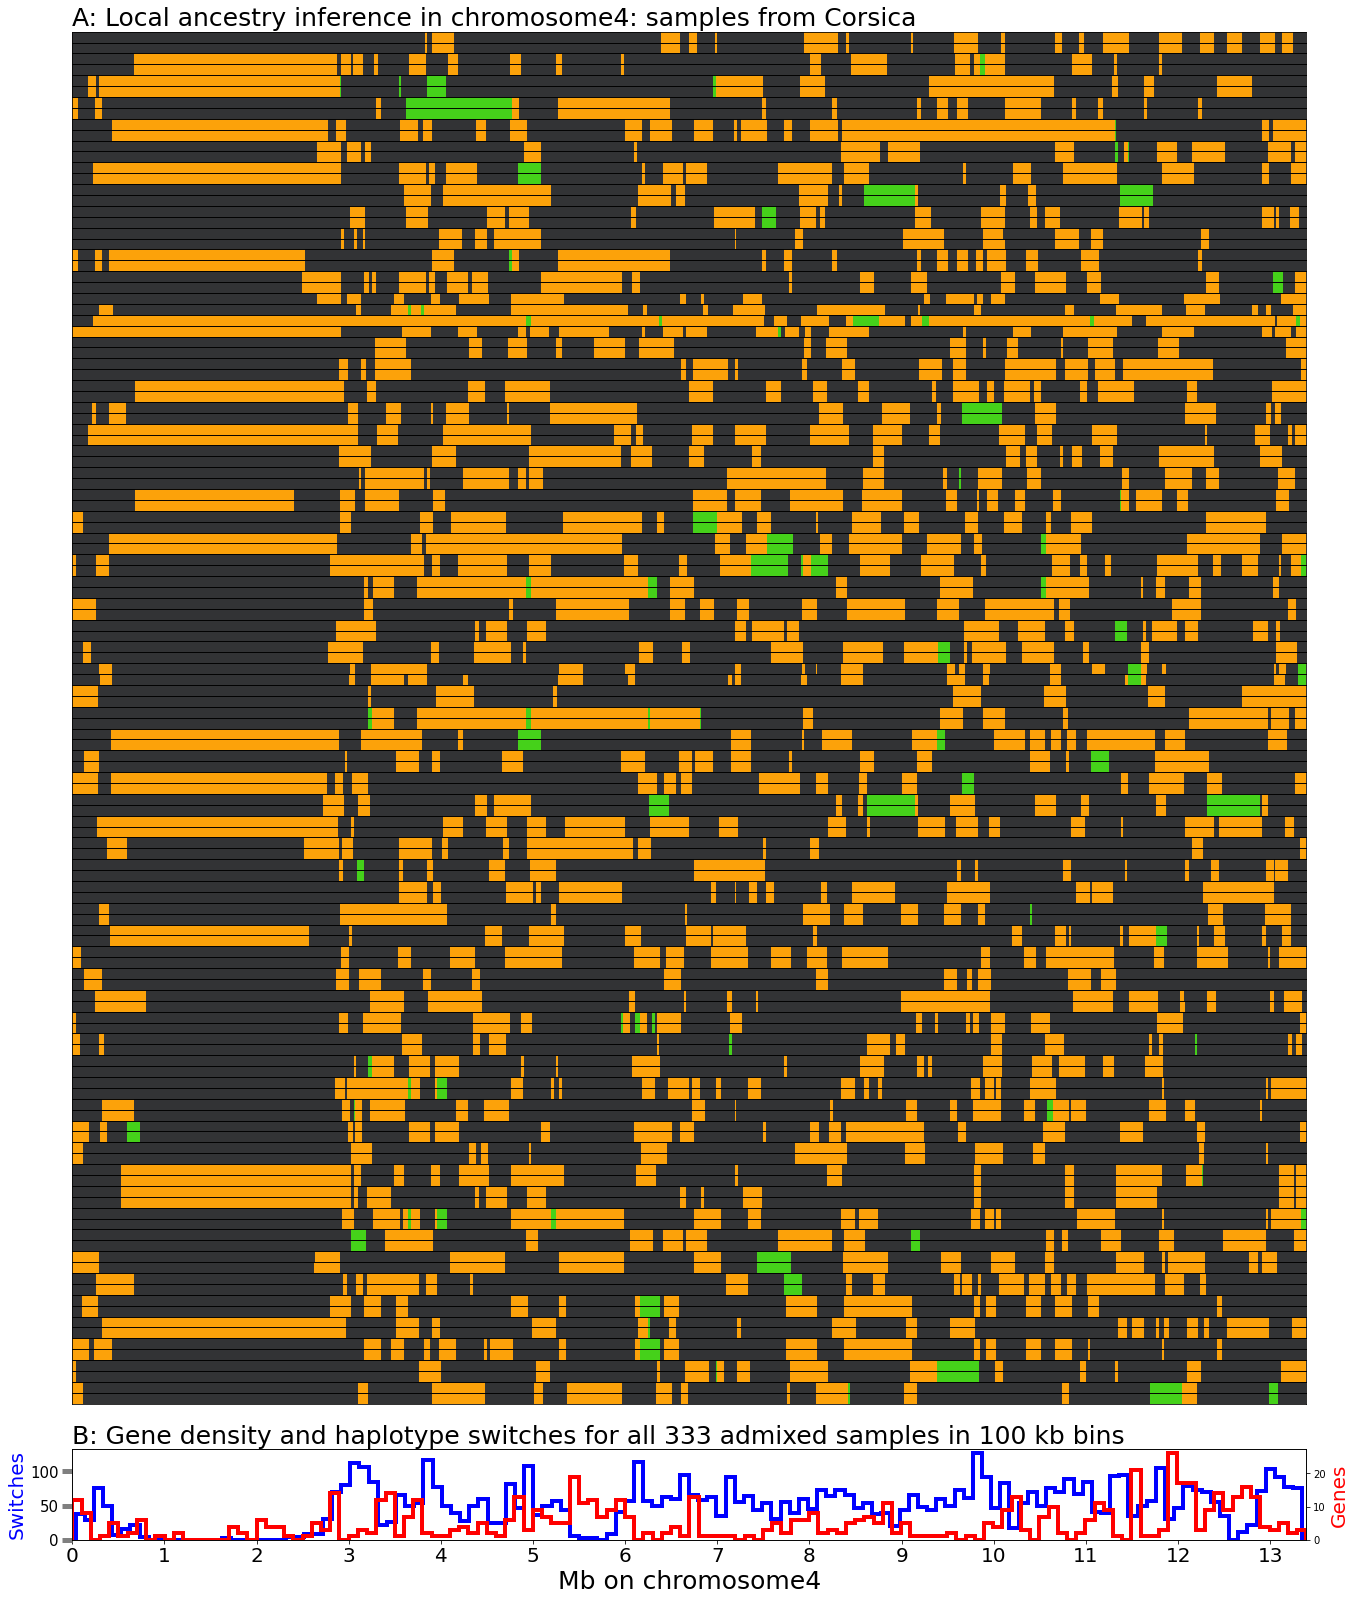

In [6]:
dataDict = {}
dataDictAgg = defaultdict(list)

chromosome = str(4)

with open('/home/avignal/Stage_M2/RFMix/SeqApiPopRFmixChr' + chromosome + '.msp.tsv') as csvFile:
    data=csv.reader(csvFile, delimiter = "\t")
    for row in data:
        if row:
            if not re.search('Subpopulation',row[0]):
                if re.search('chm',row[0]):
                    headers = row               #Get sample names
                    count = 0
                elif (not re.search('chm',row[0])) & (count == 0): #Initiate: first line into dictionary
                    for i in np.arange(6,len(row),1):
                        if row[i] == row[i]:
                            population = row[i]
                        else:
                            population = 9
                        dataDict[headers[i]] = [population,row[1],row[2],row[3],row[4]] #Assign population, start and end of CRF to sample
                    count = 1
                elif (count == 1):
                    for i in np.arange(6,len(row),1):
                        if row[i] == row[i]:
                            population = row[i]
                        else:
                            population = 9
                        if dataDict[headers[i]][0] == population:
                            dataDict[headers[i]][2] = row[2] #assign new End of CRF
                            dataDict[headers[i]][4] = row[4] #assign new End of CRF
                        elif dataDict[headers[i]][0] != population:     #change of population background
                            dataDictAgg["Sample"].append(headers[i]) #new entry for the sample
                            dataDictAgg["Start"].append(dataDict[headers[i]][1]) #
                            dataDictAgg["End"].append(dataDict[headers[i]][2])
                            dataDictAgg["StartGenet"].append(dataDict[headers[i]][3])
                            dataDictAgg["EndGenet"].append(dataDict[headers[i]][4])
                            dataDictAgg["Population"].append(dataDict[headers[i]][0])
                            dataDict[headers[i]] = [population,row[1],row[2],row[3],row[4]]
for i in np.arange(6,len(headers),1):
    dataDictAgg["Sample"].append(headers[i]) #new entry for the sample
    dataDictAgg["Start"].append(dataDict[headers[i]][1]) #
    dataDictAgg["End"].append(dataDict[headers[i]][2])
    dataDictAgg["StartGenet"].append(dataDict[headers[i]][3]) #
    dataDictAgg["EndGenet"].append(dataDict[headers[i]][4])
    dataDictAgg["Population"].append(dataDict[headers[i]][0])

dataAgg = pd.DataFrame.from_dict(dataDictAgg)
dataAgg = dataAgg.astype({'Start':'int','End':'int','StartGenet':'float','EndGenet':'float'})
dataAgg['Sample'] = dataAgg['Sample']
binWidth = 0.1 #in Mb
nbBins = math.ceil(max(dataAgg['End']/1000000) / binWidth)

# Add information on populations
dataSamples = pd.read_excel('/home/avignal/Stage_M2/SequenceGroups870_nouvelles.xlsx',sheet_name='869Samples')
dataSamples = dataSamples.loc[:,['name','RepresentsHive','CategPCA']]
dataSamples.columns = ['Sample','RepresentsHive','CategPCA']
dataSamples = dataSamples.set_index('Sample')
dataAgg = dataAgg.set_index('Sample')
dataAgg = dataAgg.join(dataSamples)
dataAgg = dataAgg.reset_index()

# Assign colour to segments
dataAgg['Colour'] =  "grey"
dataAgg.at[dataAgg.Population == "0",'Colour'] = "#323335ff"                    
dataAgg.at[dataAgg.Population == "1",'Colour'] = "#45d11aff"                     
dataAgg.at[dataAgg.Population == "2",'Colour'] = "#fca20aff"     
dataAgg


# Select samples to plot
#dataTableAggSampleSelection = dataAgg[dataAgg.Sample.str.contains('AOC',regex=True)]
dataTableAggSampleSelection = dataAgg[dataAgg.CategPCA == 'CorsicaNouvelles']
dataTableAggSampleSelection


# Sorted list of samples
sampleCor = dataTableAggSampleSelection['Sample'].unique().tolist()
sampleCor.sort()

#from itertools import chain, repeat

#sampleCor = list(chain.from_iterable(repeat(e, 2) for e in sampleCor))
#sampleCor

#import pandas as pd 
#from IPython.display import display 
#pd.set_option('display.max_rows', 2000) 
#display(dataTableAggSampleSelection)

ybins = len(sampleCor)
#space = (1 / (ybins + 1)) * 1 / 6
#figHeight = (ybins) # + 1) # * 3
figWidth = (max(dataAgg['End'])/5000000 * 8) # + space * 4
figHeight = figWidth / 1.7
#fig = plt.figure(figsize=(figWidth, figHeight))
#fig = plt.figure(figsize=(figWidth,4))
fig = plt.figure(figsize=(figWidth, figHeight))
#fig = plt.figure(constrained_layout=True, figsize=(45,40))

#fig.text(.35,.01, "Position (Mb)", fontsize=40)
#fig.text(0.05,0.50, "Samples from Corsica", fontsize=25, rotation='vertical',)

######################################################
##### First plot histogram of switches across all 333 samples
######################################################

ax = plt.axes([0.07, 0.23, 0.8, 0.1])

ax.hist(dataAgg[dataAgg.Start > 11712]['Start'],bins=nbBins, histtype='step', color = "blue", linewidth=4)
ax.set_xlim(0, max(dataAgg['End']))# /5000000)

xticks = list(np.arange(0,max(dataAgg['End']) ,1000000)) #* 5)
ax.set_xticks(xticks)        
ax.set_xticklabels([int(x / 1000000) for x in xticks], fontsize = 20)
plt.xlabel('Mb on chromosome' + chromosome, fontsize = 25)

ax.yaxis.set_tick_params(labelsize=15, length=10, width=5, color='grey')
ax.set_ylabel('Switches', fontsize = 20, color = "blue")

ax2 = ax.twinx()
chrGenesData = dfGnomon[(dfGnomon.chrom == int(chromosome))]
ax2.set_ylabel('Genes', fontsize = 20, color="red")
ax2.hist(chrGenesData['Pos'], bins=nbBins, histtype='step', color = "red", linewidth=4)

plt.title('B: Gene density and haplotype switches for all 333 admixed samples in 100 kb bins', fontsize = 25, loc='left')

######################################################
##### Then the samples from Corsica
######################################################

#fig.suptitle("Title", fontsize=96)
bottom = 0.38 #space
x_axis = 'yes'
count = 0
for i in sampleCor:
    count = count + 1
    left = 0 #space * 7
    width = figWidth
    height = (0.012)#/ybins)
    ax = plt.axes([0.07, bottom, 0.8, height])    
    if x_axis == 'yes':
        ax.axes.xaxis.set_visible(False)
        xticks = list(np.arange(0,max(dataAgg['End']/5000000) ,0.2)) #* 5)
        ax.set_xticks(xticks)        
        ax.set_xticklabels([int(x * 5) for x in xticks], fontsize = 15)
        plt.xlabel('Mb on chromosome 11', fontsize = 30)
        x_axis = 'false'
    else:
        ax.axes.xaxis.set_visible(False)
    if count == len(sampleCor):
        plt.title('A: Local ancestry inference in chromosome' + chromosome + ': samples from Corsica', fontsize = 25, loc='left')
    ax.axes.yaxis.set_visible(False)
    ax.set_xlim(0, max(dataAgg['End'])/5000000)
    bottom = bottom + height # + space
    dataSample = dataTableAggSampleSelection[dataTableAggSampleSelection.Sample == i]
    for index, row  in dataSample.iterrows():
        start = row["Start"] / 5000000
        end = row["End"] / 5000000
        color = row["Colour"]
        #ax.hlines(0, start, end, colors='orange', linestyles='solid')#, label='', *, data=None, **kwargs)[source]
        ax.axvspan(start, end, ymin=0.0, ymax=1.0, alpha=1, color=color)

#plt.tight_layout()        
#fig



# Plot Chromosome 5

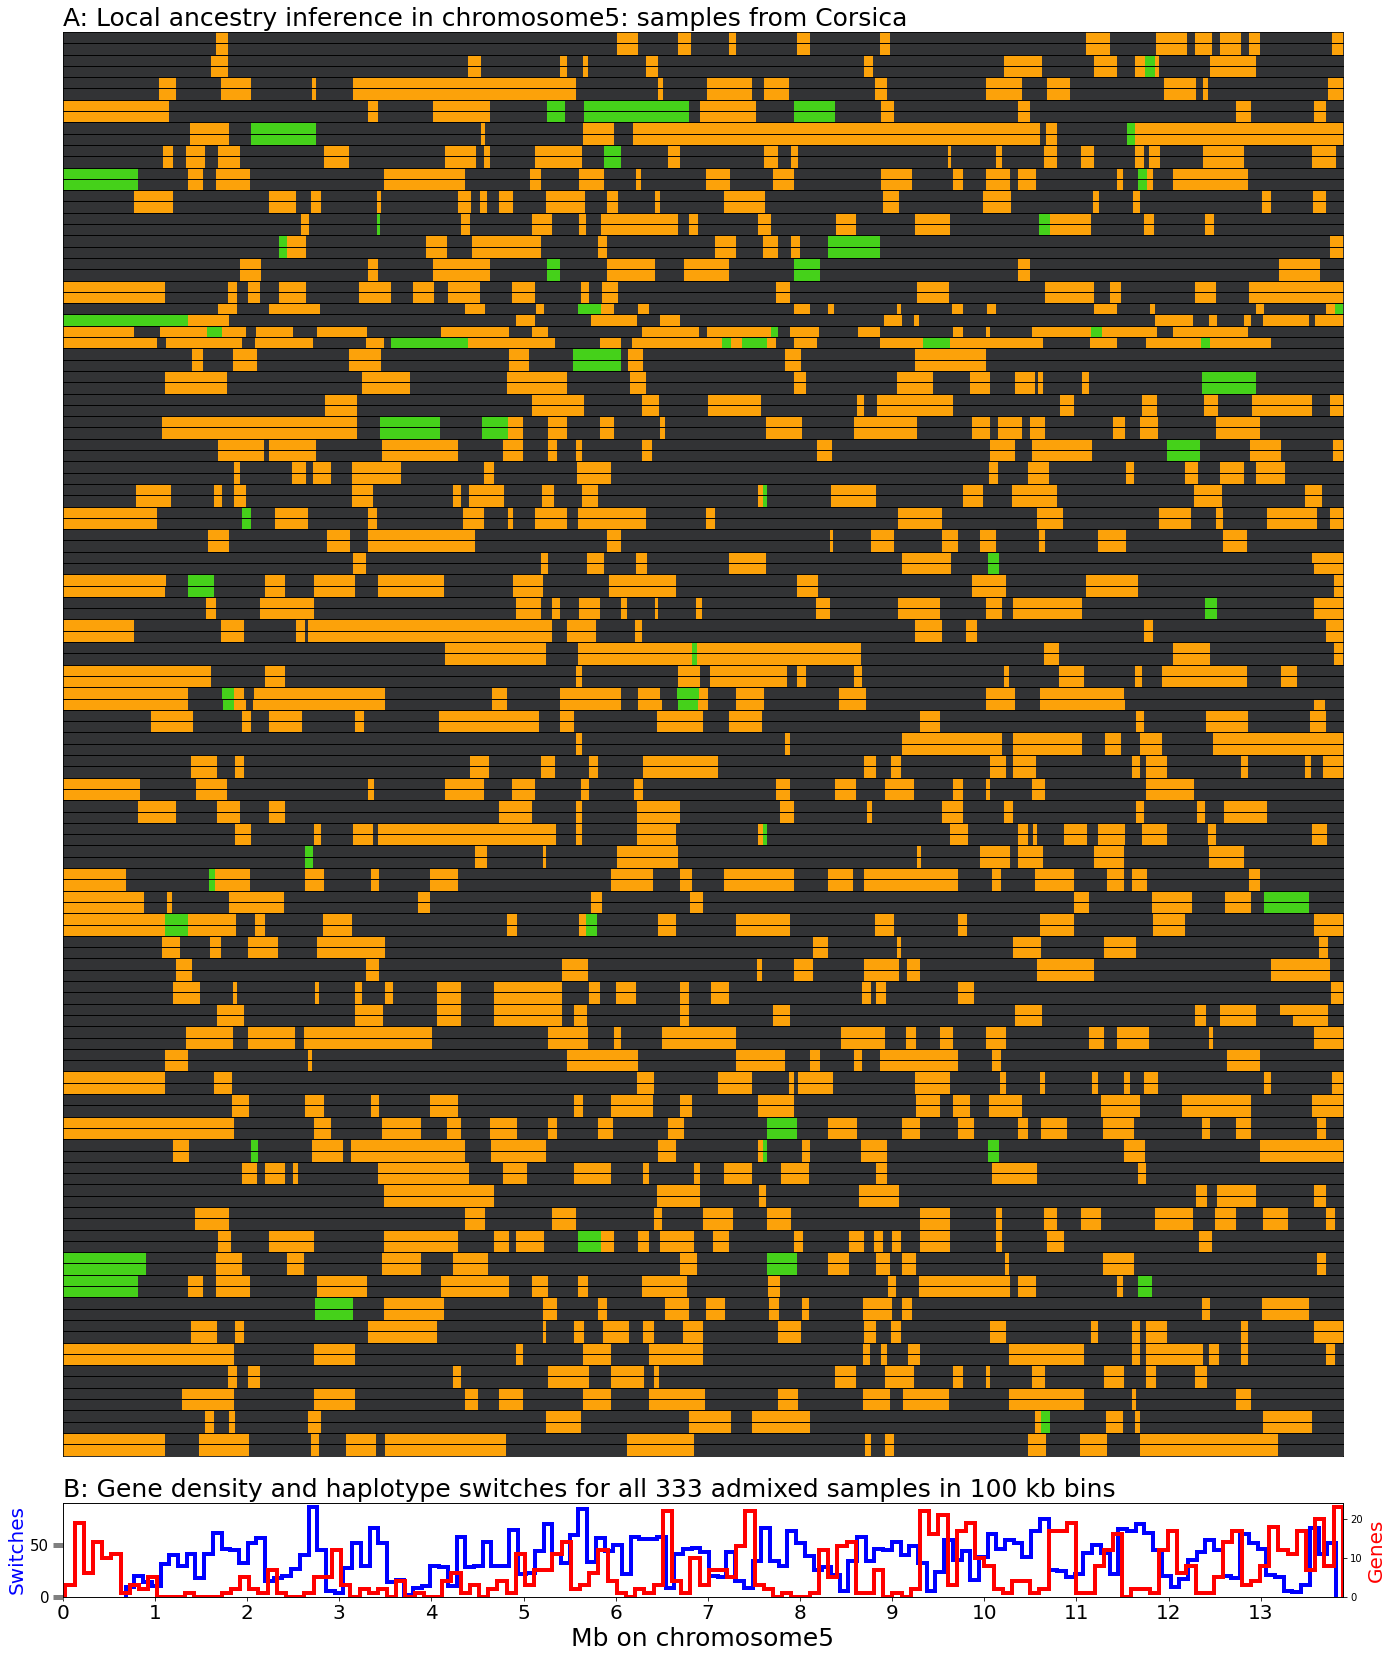

In [7]:
dataDict = {}
dataDictAgg = defaultdict(list)

chromosome = str(5)

with open('/home/avignal/Stage_M2/RFMix/SeqApiPopRFmixChr' + chromosome + '.msp.tsv') as csvFile:
    data=csv.reader(csvFile, delimiter = "\t")
    for row in data:
        if row:
            if not re.search('Subpopulation',row[0]):
                if re.search('chm',row[0]):
                    headers = row               #Get sample names
                    count = 0
                elif (not re.search('chm',row[0])) & (count == 0): #Initiate: first line into dictionary
                    for i in np.arange(6,len(row),1):
                        if row[i] == row[i]:
                            population = row[i]
                        else:
                            population = 9
                        dataDict[headers[i]] = [population,row[1],row[2],row[3],row[4]] #Assign population, start and end of CRF to sample
                    count = 1
                elif (count == 1):
                    for i in np.arange(6,len(row),1):
                        if row[i] == row[i]:
                            population = row[i]
                        else:
                            population = 9
                        if dataDict[headers[i]][0] == population:
                            dataDict[headers[i]][2] = row[2] #assign new End of CRF
                            dataDict[headers[i]][4] = row[4] #assign new End of CRF
                        elif dataDict[headers[i]][0] != population:     #change of population background
                            dataDictAgg["Sample"].append(headers[i]) #new entry for the sample
                            dataDictAgg["Start"].append(dataDict[headers[i]][1]) #
                            dataDictAgg["End"].append(dataDict[headers[i]][2])
                            dataDictAgg["StartGenet"].append(dataDict[headers[i]][3])
                            dataDictAgg["EndGenet"].append(dataDict[headers[i]][4])
                            dataDictAgg["Population"].append(dataDict[headers[i]][0])
                            dataDict[headers[i]] = [population,row[1],row[2],row[3],row[4]]
for i in np.arange(6,len(headers),1):
    dataDictAgg["Sample"].append(headers[i]) #new entry for the sample
    dataDictAgg["Start"].append(dataDict[headers[i]][1]) #
    dataDictAgg["End"].append(dataDict[headers[i]][2])
    dataDictAgg["StartGenet"].append(dataDict[headers[i]][3]) #
    dataDictAgg["EndGenet"].append(dataDict[headers[i]][4])
    dataDictAgg["Population"].append(dataDict[headers[i]][0])

dataAgg = pd.DataFrame.from_dict(dataDictAgg)
dataAgg = dataAgg.astype({'Start':'int','End':'int','StartGenet':'float','EndGenet':'float'})
dataAgg['Sample'] = dataAgg['Sample']
binWidth = 0.1 #in Mb
nbBins = math.ceil(max(dataAgg['End']/1000000) / binWidth)

# Add information on populations
dataSamples = pd.read_excel('/home/avignal/Stage_M2/SequenceGroups870_nouvelles.xlsx',sheet_name='869Samples')
dataSamples = dataSamples.loc[:,['name','RepresentsHive','CategPCA']]
dataSamples.columns = ['Sample','RepresentsHive','CategPCA']
dataSamples = dataSamples.set_index('Sample')
dataAgg = dataAgg.set_index('Sample')
dataAgg = dataAgg.join(dataSamples)
dataAgg = dataAgg.reset_index()

# Assign colour to segments
dataAgg['Colour'] =  "grey"
dataAgg.at[dataAgg.Population == "0",'Colour'] = "#323335ff"                    
dataAgg.at[dataAgg.Population == "1",'Colour'] = "#45d11aff"                     
dataAgg.at[dataAgg.Population == "2",'Colour'] = "#fca20aff"     
dataAgg


# Select samples to plot
#dataTableAggSampleSelection = dataAgg[dataAgg.Sample.str.contains('AOC',regex=True)]
dataTableAggSampleSelection = dataAgg[dataAgg.CategPCA == 'CorsicaNouvelles']
dataTableAggSampleSelection


# Sorted list of samples
sampleCor = dataTableAggSampleSelection['Sample'].unique().tolist()
sampleCor.sort()

#from itertools import chain, repeat

#sampleCor = list(chain.from_iterable(repeat(e, 2) for e in sampleCor))
#sampleCor

#import pandas as pd 
#from IPython.display import display 
#pd.set_option('display.max_rows', 2000) 
#display(dataTableAggSampleSelection)

ybins = len(sampleCor)
#space = (1 / (ybins + 1)) * 1 / 6
#figHeight = (ybins) # + 1) # * 3
figWidth = (max(dataAgg['End'])/5000000 * 8) # + space * 4
figHeight = figWidth / 1.7
#fig = plt.figure(figsize=(figWidth, figHeight))
#fig = plt.figure(figsize=(figWidth,4))
fig = plt.figure(figsize=(figWidth, figHeight))
#fig = plt.figure(constrained_layout=True, figsize=(45,40))

#fig.text(.35,.01, "Position (Mb)", fontsize=40)
#fig.text(0.05,0.50, "Samples from Corsica", fontsize=25, rotation='vertical',)

######################################################
##### First plot histogram of switches across all 333 samples
######################################################

ax = plt.axes([0.07, 0.23, 0.8, 0.1])

ax.hist(dataAgg[dataAgg.Start > 11712]['Start'],bins=nbBins, histtype='step', color = "blue", linewidth=4)
ax.set_xlim(0, max(dataAgg['End']))# /5000000)

xticks = list(np.arange(0,max(dataAgg['End']) ,1000000)) #* 5)
ax.set_xticks(xticks)        
ax.set_xticklabels([int(x / 1000000) for x in xticks], fontsize = 20)
plt.xlabel('Mb on chromosome' + chromosome, fontsize = 25)

ax.yaxis.set_tick_params(labelsize=15, length=10, width=5, color='grey')
ax.set_ylabel('Switches', fontsize = 20, color = "blue")

ax2 = ax.twinx()
chrGenesData = dfGnomon[(dfGnomon.chrom == int(chromosome))]
ax2.set_ylabel('Genes', fontsize = 20, color="red")
ax2.hist(chrGenesData['Pos'], bins=nbBins, histtype='step', color = "red", linewidth=4)

plt.title('B: Gene density and haplotype switches for all 333 admixed samples in 100 kb bins', fontsize = 25, loc='left')

######################################################
##### Then the samples from Corsica
######################################################

#fig.suptitle("Title", fontsize=96)
bottom = 0.38 #space
x_axis = 'yes'
count = 0
for i in sampleCor:
    count = count + 1
    left = 0 #space * 7
    width = figWidth
    height = (0.012)#/ybins)
    ax = plt.axes([0.07, bottom, 0.8, height])    
    if x_axis == 'yes':
        ax.axes.xaxis.set_visible(False)
        xticks = list(np.arange(0,max(dataAgg['End']/5000000) ,0.2)) #* 5)
        ax.set_xticks(xticks)        
        ax.set_xticklabels([int(x * 5) for x in xticks], fontsize = 15)
        plt.xlabel('Mb on chromosome 11', fontsize = 30)
        x_axis = 'false'
    else:
        ax.axes.xaxis.set_visible(False)
    if count == len(sampleCor):
        plt.title('A: Local ancestry inference in chromosome' + chromosome + ': samples from Corsica', fontsize = 25, loc='left')
    ax.axes.yaxis.set_visible(False)
    ax.set_xlim(0, max(dataAgg['End'])/5000000)
    bottom = bottom + height # + space
    dataSample = dataTableAggSampleSelection[dataTableAggSampleSelection.Sample == i]
    for index, row  in dataSample.iterrows():
        start = row["Start"] / 5000000
        end = row["End"] / 5000000
        color = row["Colour"]
        #ax.hlines(0, start, end, colors='orange', linestyles='solid')#, label='', *, data=None, **kwargs)[source]
        ax.axvspan(start, end, ymin=0.0, ymax=1.0, alpha=1, color=color)

#plt.tight_layout()        
#fig



# Plot Chromosome 6

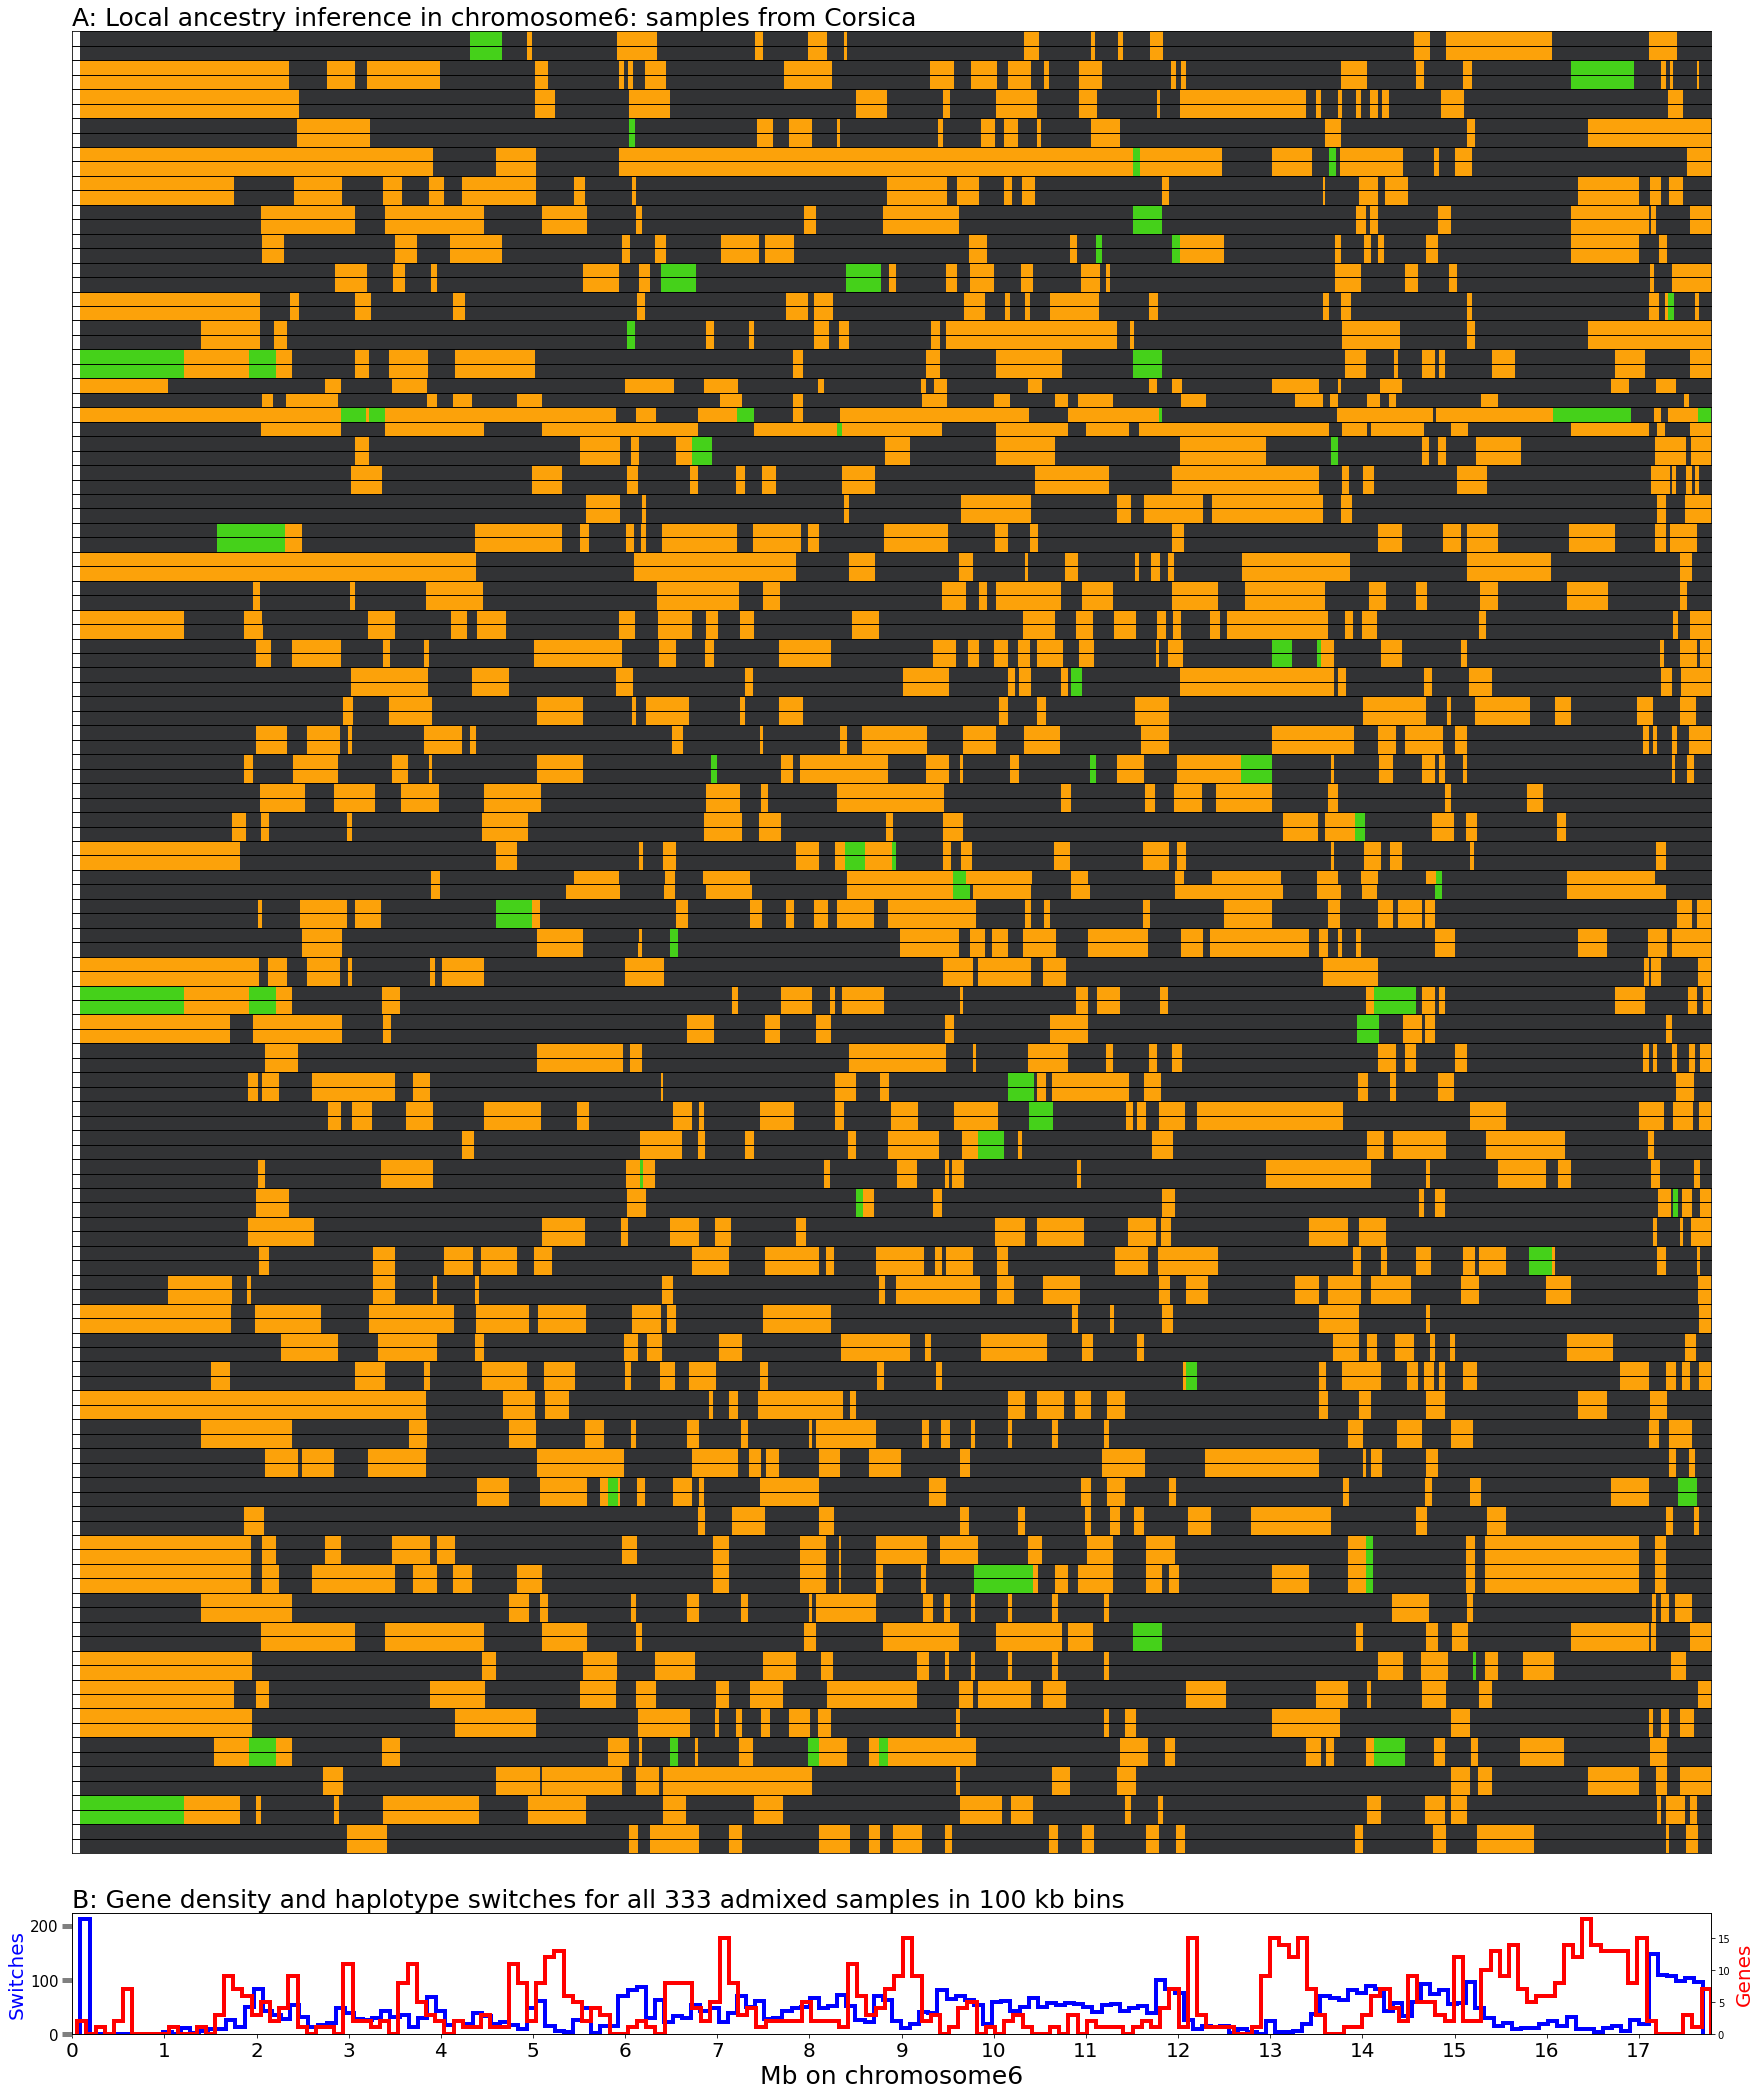

In [8]:
dataDict = {}
dataDictAgg = defaultdict(list)

chromosome = str(6)

with open('/home/avignal/Stage_M2/RFMix/SeqApiPopRFmixChr' + chromosome + '.msp.tsv') as csvFile:
    data=csv.reader(csvFile, delimiter = "\t")
    for row in data:
        if row:
            if not re.search('Subpopulation',row[0]):
                if re.search('chm',row[0]):
                    headers = row               #Get sample names
                    count = 0
                elif (not re.search('chm',row[0])) & (count == 0): #Initiate: first line into dictionary
                    for i in np.arange(6,len(row),1):
                        if row[i] == row[i]:
                            population = row[i]
                        else:
                            population = 9
                        dataDict[headers[i]] = [population,row[1],row[2],row[3],row[4]] #Assign population, start and end of CRF to sample
                    count = 1
                elif (count == 1):
                    for i in np.arange(6,len(row),1):
                        if row[i] == row[i]:
                            population = row[i]
                        else:
                            population = 9
                        if dataDict[headers[i]][0] == population:
                            dataDict[headers[i]][2] = row[2] #assign new End of CRF
                            dataDict[headers[i]][4] = row[4] #assign new End of CRF
                        elif dataDict[headers[i]][0] != population:     #change of population background
                            dataDictAgg["Sample"].append(headers[i]) #new entry for the sample
                            dataDictAgg["Start"].append(dataDict[headers[i]][1]) #
                            dataDictAgg["End"].append(dataDict[headers[i]][2])
                            dataDictAgg["StartGenet"].append(dataDict[headers[i]][3])
                            dataDictAgg["EndGenet"].append(dataDict[headers[i]][4])
                            dataDictAgg["Population"].append(dataDict[headers[i]][0])
                            dataDict[headers[i]] = [population,row[1],row[2],row[3],row[4]]
for i in np.arange(6,len(headers),1):
    dataDictAgg["Sample"].append(headers[i]) #new entry for the sample
    dataDictAgg["Start"].append(dataDict[headers[i]][1]) #
    dataDictAgg["End"].append(dataDict[headers[i]][2])
    dataDictAgg["StartGenet"].append(dataDict[headers[i]][3]) #
    dataDictAgg["EndGenet"].append(dataDict[headers[i]][4])
    dataDictAgg["Population"].append(dataDict[headers[i]][0])

dataAgg = pd.DataFrame.from_dict(dataDictAgg)
dataAgg = dataAgg.astype({'Start':'int','End':'int','StartGenet':'float','EndGenet':'float'})
dataAgg['Sample'] = dataAgg['Sample']
binWidth = 0.1 #in Mb
nbBins = math.ceil(max(dataAgg['End']/1000000) / binWidth)

# Add information on populations
dataSamples = pd.read_excel('/home/avignal/Stage_M2/SequenceGroups870_nouvelles.xlsx',sheet_name='869Samples')
dataSamples = dataSamples.loc[:,['name','RepresentsHive','CategPCA']]
dataSamples.columns = ['Sample','RepresentsHive','CategPCA']
dataSamples = dataSamples.set_index('Sample')
dataAgg = dataAgg.set_index('Sample')
dataAgg = dataAgg.join(dataSamples)
dataAgg = dataAgg.reset_index()

# Assign colour to segments
dataAgg['Colour'] =  "grey"
dataAgg.at[dataAgg.Population == "0",'Colour'] = "#323335ff"                    
dataAgg.at[dataAgg.Population == "1",'Colour'] = "#45d11aff"                     
dataAgg.at[dataAgg.Population == "2",'Colour'] = "#fca20aff"     
dataAgg


# Select samples to plot
#dataTableAggSampleSelection = dataAgg[dataAgg.Sample.str.contains('AOC',regex=True)]
dataTableAggSampleSelection = dataAgg[dataAgg.CategPCA == 'CorsicaNouvelles']
dataTableAggSampleSelection


# Sorted list of samples
sampleCor = dataTableAggSampleSelection['Sample'].unique().tolist()
sampleCor.sort()

#from itertools import chain, repeat

#sampleCor = list(chain.from_iterable(repeat(e, 2) for e in sampleCor))
#sampleCor

#import pandas as pd 
#from IPython.display import display 
#pd.set_option('display.max_rows', 2000) 
#display(dataTableAggSampleSelection)

ybins = len(sampleCor)
#space = (1 / (ybins + 1)) * 1 / 6
#figHeight = (ybins) # + 1) # * 3
figWidth = (max(dataAgg['End'])/5000000 * 8) # + space * 4
figHeight = figWidth / 1.7
#fig = plt.figure(figsize=(figWidth, figHeight))
#fig = plt.figure(figsize=(figWidth,4))
fig = plt.figure(figsize=(figWidth, figHeight))
#fig = plt.figure(constrained_layout=True, figsize=(45,40))

#fig.text(.35,.01, "Position (Mb)", fontsize=40)
#fig.text(0.05,0.50, "Samples from Corsica", fontsize=25, rotation='vertical',)

######################################################
##### First plot histogram of switches across all 333 samples
######################################################

ax = plt.axes([0.07, 0.23, 0.8, 0.1])

ax.hist(dataAgg[dataAgg.Start > 11712]['Start'],bins=nbBins, histtype='step', color = "blue", linewidth=4)
ax.set_xlim(0, max(dataAgg['End']))# /5000000)

xticks = list(np.arange(0,max(dataAgg['End']) ,1000000)) #* 5)
ax.set_xticks(xticks)        
ax.set_xticklabels([int(x / 1000000) for x in xticks], fontsize = 20)
plt.xlabel('Mb on chromosome' + chromosome, fontsize = 25)

ax.yaxis.set_tick_params(labelsize=15, length=10, width=5, color='grey')
ax.set_ylabel('Switches', fontsize = 20, color = "blue")

ax2 = ax.twinx()
chrGenesData = dfGnomon[(dfGnomon.chrom == int(chromosome))]
ax2.set_ylabel('Genes', fontsize = 20, color="red")
ax2.hist(chrGenesData['Pos'], bins=nbBins, histtype='step', color = "red", linewidth=4)

plt.title('B: Gene density and haplotype switches for all 333 admixed samples in 100 kb bins', fontsize = 25, loc='left')

######################################################
##### Then the samples from Corsica
######################################################

#fig.suptitle("Title", fontsize=96)
bottom = 0.38 #space
x_axis = 'yes'
count = 0
for i in sampleCor:
    count = count + 1
    left = 0 #space * 7
    width = figWidth
    height = (0.012)#/ybins)
    ax = plt.axes([0.07, bottom, 0.8, height])    
    if x_axis == 'yes':
        ax.axes.xaxis.set_visible(False)
        xticks = list(np.arange(0,max(dataAgg['End']/5000000) ,0.2)) #* 5)
        ax.set_xticks(xticks)        
        ax.set_xticklabels([int(x * 5) for x in xticks], fontsize = 15)
        plt.xlabel('Mb on chromosome 11', fontsize = 30)
        x_axis = 'false'
    else:
        ax.axes.xaxis.set_visible(False)
    if count == len(sampleCor):
        plt.title('A: Local ancestry inference in chromosome' + chromosome + ': samples from Corsica', fontsize = 25, loc='left')
    ax.axes.yaxis.set_visible(False)
    ax.set_xlim(0, max(dataAgg['End'])/5000000)
    bottom = bottom + height # + space
    dataSample = dataTableAggSampleSelection[dataTableAggSampleSelection.Sample == i]
    for index, row  in dataSample.iterrows():
        start = row["Start"] / 5000000
        end = row["End"] / 5000000
        color = row["Colour"]
        #ax.hlines(0, start, end, colors='orange', linestyles='solid')#, label='', *, data=None, **kwargs)[source]
        ax.axvspan(start, end, ymin=0.0, ymax=1.0, alpha=1, color=color)

#plt.tight_layout()        
#fig



# Plot chromosome 7

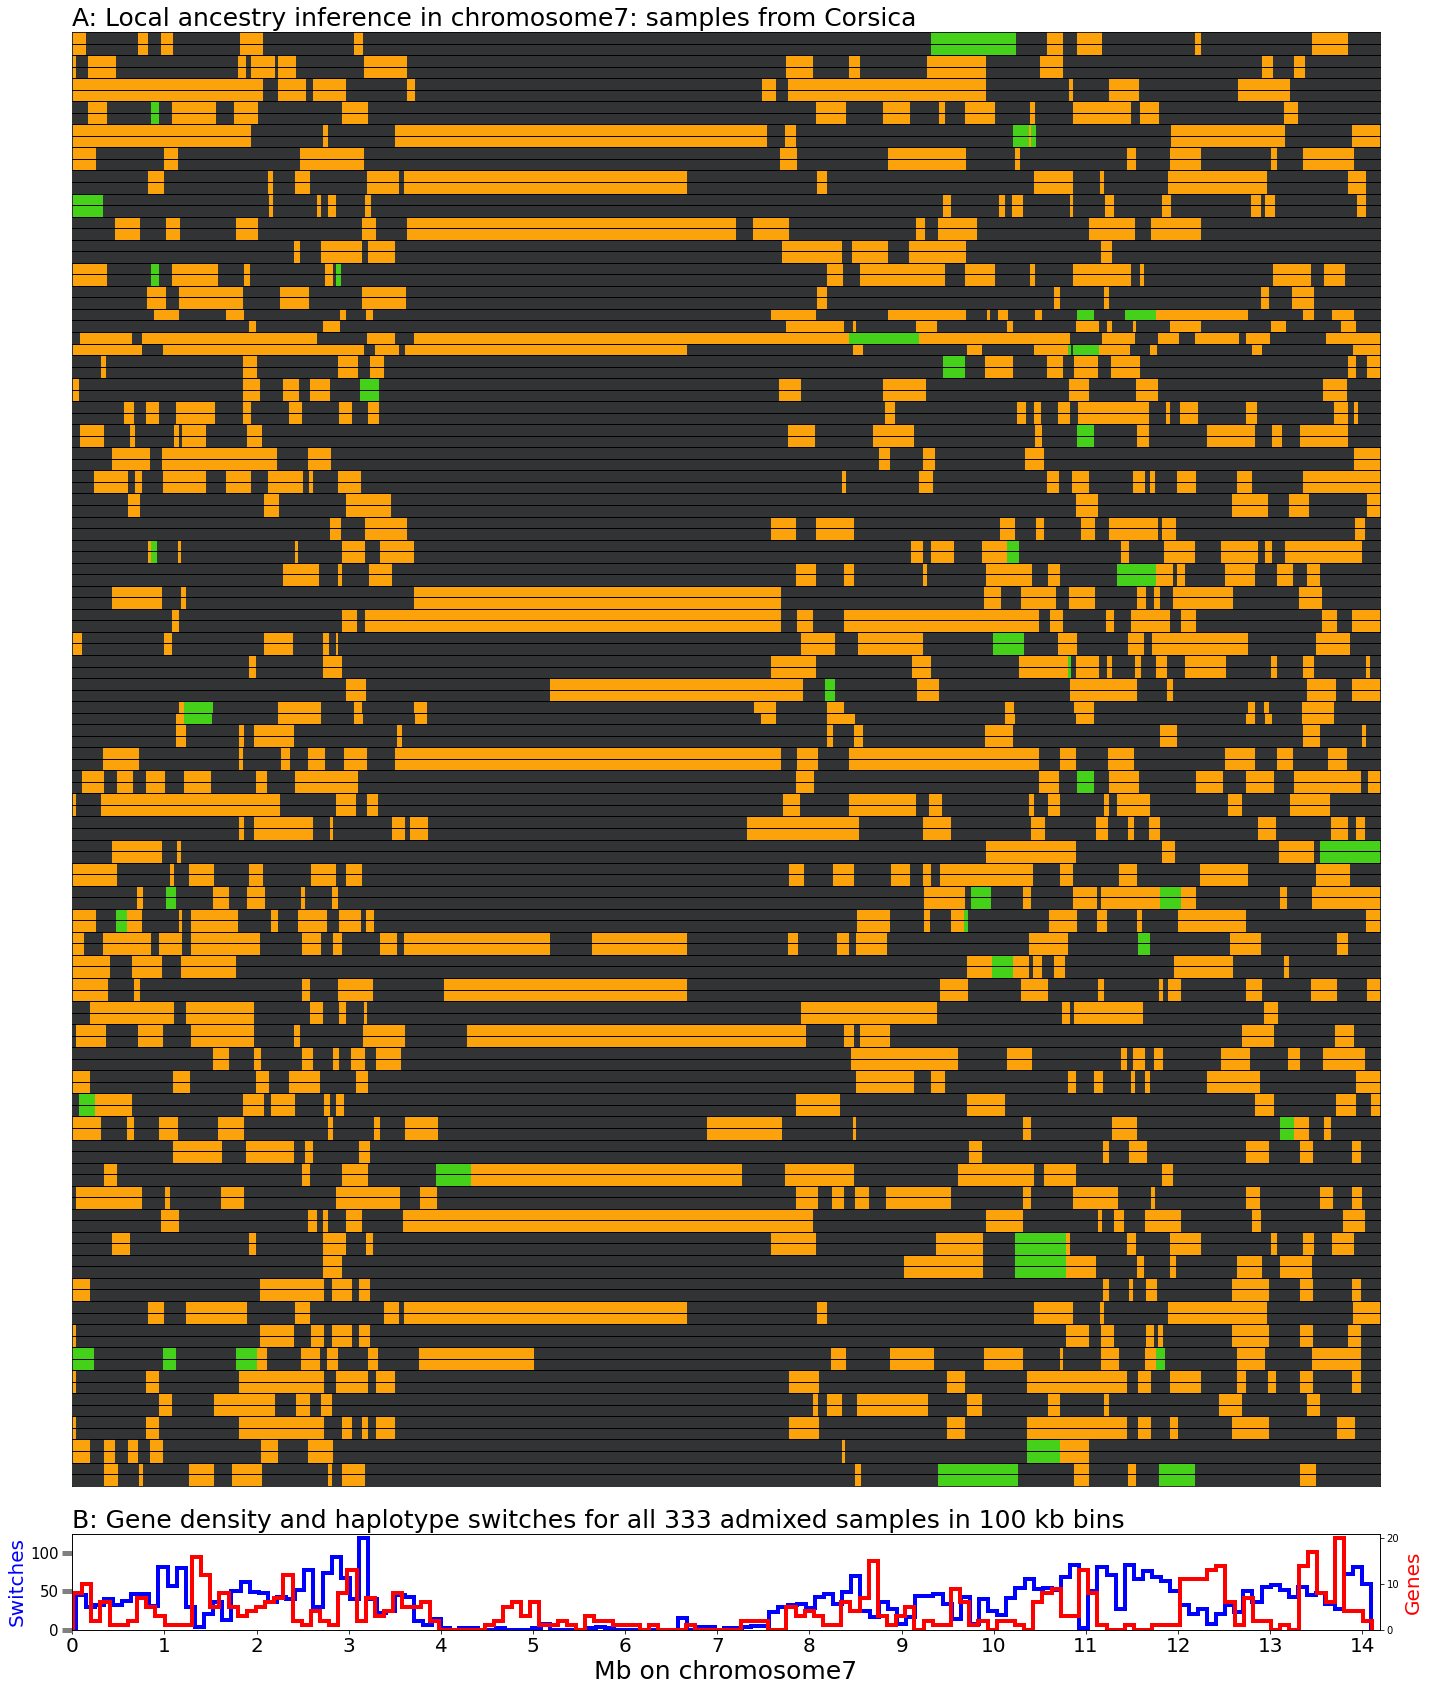

In [9]:
dataDict = {}
dataDictAgg = defaultdict(list)

chromosome = str(7)

with open('/home/avignal/Stage_M2/RFMix/SeqApiPopRFmixChr' + chromosome + '.msp.tsv') as csvFile:
    data=csv.reader(csvFile, delimiter = "\t")
    for row in data:
        if row:
            if not re.search('Subpopulation',row[0]):
                if re.search('chm',row[0]):
                    headers = row               #Get sample names
                    count = 0
                elif (not re.search('chm',row[0])) & (count == 0): #Initiate: first line into dictionary
                    for i in np.arange(6,len(row),1):
                        if row[i] == row[i]:
                            population = row[i]
                        else:
                            population = 9
                        dataDict[headers[i]] = [population,row[1],row[2],row[3],row[4]] #Assign population, start and end of CRF to sample
                    count = 1
                elif (count == 1):
                    for i in np.arange(6,len(row),1):
                        if row[i] == row[i]:
                            population = row[i]
                        else:
                            population = 9
                        if dataDict[headers[i]][0] == population:
                            dataDict[headers[i]][2] = row[2] #assign new End of CRF
                            dataDict[headers[i]][4] = row[4] #assign new End of CRF
                        elif dataDict[headers[i]][0] != population:     #change of population background
                            dataDictAgg["Sample"].append(headers[i]) #new entry for the sample
                            dataDictAgg["Start"].append(dataDict[headers[i]][1]) #
                            dataDictAgg["End"].append(dataDict[headers[i]][2])
                            dataDictAgg["StartGenet"].append(dataDict[headers[i]][3])
                            dataDictAgg["EndGenet"].append(dataDict[headers[i]][4])
                            dataDictAgg["Population"].append(dataDict[headers[i]][0])
                            dataDict[headers[i]] = [population,row[1],row[2],row[3],row[4]]
for i in np.arange(6,len(headers),1):
    dataDictAgg["Sample"].append(headers[i]) #new entry for the sample
    dataDictAgg["Start"].append(dataDict[headers[i]][1]) #
    dataDictAgg["End"].append(dataDict[headers[i]][2])
    dataDictAgg["StartGenet"].append(dataDict[headers[i]][3]) #
    dataDictAgg["EndGenet"].append(dataDict[headers[i]][4])
    dataDictAgg["Population"].append(dataDict[headers[i]][0])

dataAgg = pd.DataFrame.from_dict(dataDictAgg)
dataAgg = dataAgg.astype({'Start':'int','End':'int','StartGenet':'float','EndGenet':'float'})
dataAgg['Sample'] = dataAgg['Sample']
binWidth = 0.1 #in Mb
nbBins = math.ceil(max(dataAgg['End']/1000000) / binWidth)

# Add information on populations
dataSamples = pd.read_excel('/home/avignal/Stage_M2/SequenceGroups870_nouvelles.xlsx',sheet_name='869Samples')
dataSamples = dataSamples.loc[:,['name','RepresentsHive','CategPCA']]
dataSamples.columns = ['Sample','RepresentsHive','CategPCA']
dataSamples = dataSamples.set_index('Sample')
dataAgg = dataAgg.set_index('Sample')
dataAgg = dataAgg.join(dataSamples)
dataAgg = dataAgg.reset_index()

# Assign colour to segments
dataAgg['Colour'] =  "grey"
dataAgg.at[dataAgg.Population == "0",'Colour'] = "#323335ff"                    
dataAgg.at[dataAgg.Population == "1",'Colour'] = "#45d11aff"                     
dataAgg.at[dataAgg.Population == "2",'Colour'] = "#fca20aff"     
dataAgg


# Select samples to plot
#dataTableAggSampleSelection = dataAgg[dataAgg.Sample.str.contains('AOC',regex=True)]
dataTableAggSampleSelection = dataAgg[dataAgg.CategPCA == 'CorsicaNouvelles']
dataTableAggSampleSelection


# Sorted list of samples
sampleCor = dataTableAggSampleSelection['Sample'].unique().tolist()
sampleCor.sort()

#from itertools import chain, repeat

#sampleCor = list(chain.from_iterable(repeat(e, 2) for e in sampleCor))
#sampleCor

#import pandas as pd 
#from IPython.display import display 
#pd.set_option('display.max_rows', 2000) 
#display(dataTableAggSampleSelection)

ybins = len(sampleCor)
#space = (1 / (ybins + 1)) * 1 / 6
#figHeight = (ybins) # + 1) # * 3
figWidth = (max(dataAgg['End'])/5000000 * 8) # + space * 4
figHeight = figWidth / 1.7
#fig = plt.figure(figsize=(figWidth, figHeight))
#fig = plt.figure(figsize=(figWidth,4))
fig = plt.figure(figsize=(figWidth, figHeight))
#fig = plt.figure(constrained_layout=True, figsize=(45,40))

#fig.text(.35,.01, "Position (Mb)", fontsize=40)
#fig.text(0.05,0.50, "Samples from Corsica", fontsize=25, rotation='vertical',)

######################################################
##### First plot histogram of switches across all 333 samples
######################################################

ax = plt.axes([0.07, 0.23, 0.8, 0.1])

ax.hist(dataAgg[dataAgg.Start > 11712]['Start'],bins=nbBins, histtype='step', color = "blue", linewidth=4)
ax.set_xlim(0, max(dataAgg['End']))# /5000000)

xticks = list(np.arange(0,max(dataAgg['End']) ,1000000)) #* 5)
ax.set_xticks(xticks)        
ax.set_xticklabels([int(x / 1000000) for x in xticks], fontsize = 20)
plt.xlabel('Mb on chromosome' + chromosome, fontsize = 25)

ax.yaxis.set_tick_params(labelsize=15, length=10, width=5, color='grey')
ax.set_ylabel('Switches', fontsize = 20, color = "blue")

ax2 = ax.twinx()
chrGenesData = dfGnomon[(dfGnomon.chrom == int(chromosome))]
ax2.set_ylabel('Genes', fontsize = 20, color="red")
ax2.hist(chrGenesData['Pos'], bins=nbBins, histtype='step', color = "red", linewidth=4)

plt.title('B: Gene density and haplotype switches for all 333 admixed samples in 100 kb bins', fontsize = 25, loc='left')

######################################################
##### Then the samples from Corsica
######################################################

#fig.suptitle("Title", fontsize=96)
bottom = 0.38 #space
x_axis = 'yes'
count = 0
for i in sampleCor:
    count = count + 1
    left = 0 #space * 7
    width = figWidth
    height = (0.012)#/ybins)
    ax = plt.axes([0.07, bottom, 0.8, height])    
    if x_axis == 'yes':
        ax.axes.xaxis.set_visible(False)
        xticks = list(np.arange(0,max(dataAgg['End']/5000000) ,0.2)) #* 5)
        ax.set_xticks(xticks)        
        ax.set_xticklabels([int(x * 5) for x in xticks], fontsize = 15)
        plt.xlabel('Mb on chromosome 11', fontsize = 30)
        x_axis = 'false'
    else:
        ax.axes.xaxis.set_visible(False)
    if count == len(sampleCor):
        plt.title('A: Local ancestry inference in chromosome' + chromosome + ': samples from Corsica', fontsize = 25, loc='left')
    ax.axes.yaxis.set_visible(False)
    ax.set_xlim(0, max(dataAgg['End'])/5000000)
    bottom = bottom + height # + space
    dataSample = dataTableAggSampleSelection[dataTableAggSampleSelection.Sample == i]
    for index, row  in dataSample.iterrows():
        start = row["Start"] / 5000000
        end = row["End"] / 5000000
        color = row["Colour"]
        #ax.hlines(0, start, end, colors='orange', linestyles='solid')#, label='', *, data=None, **kwargs)[source]
        ax.axvspan(start, end, ymin=0.0, ymax=1.0, alpha=1, color=color)

#plt.tight_layout()        
#fig



# Plot Chromosome 8

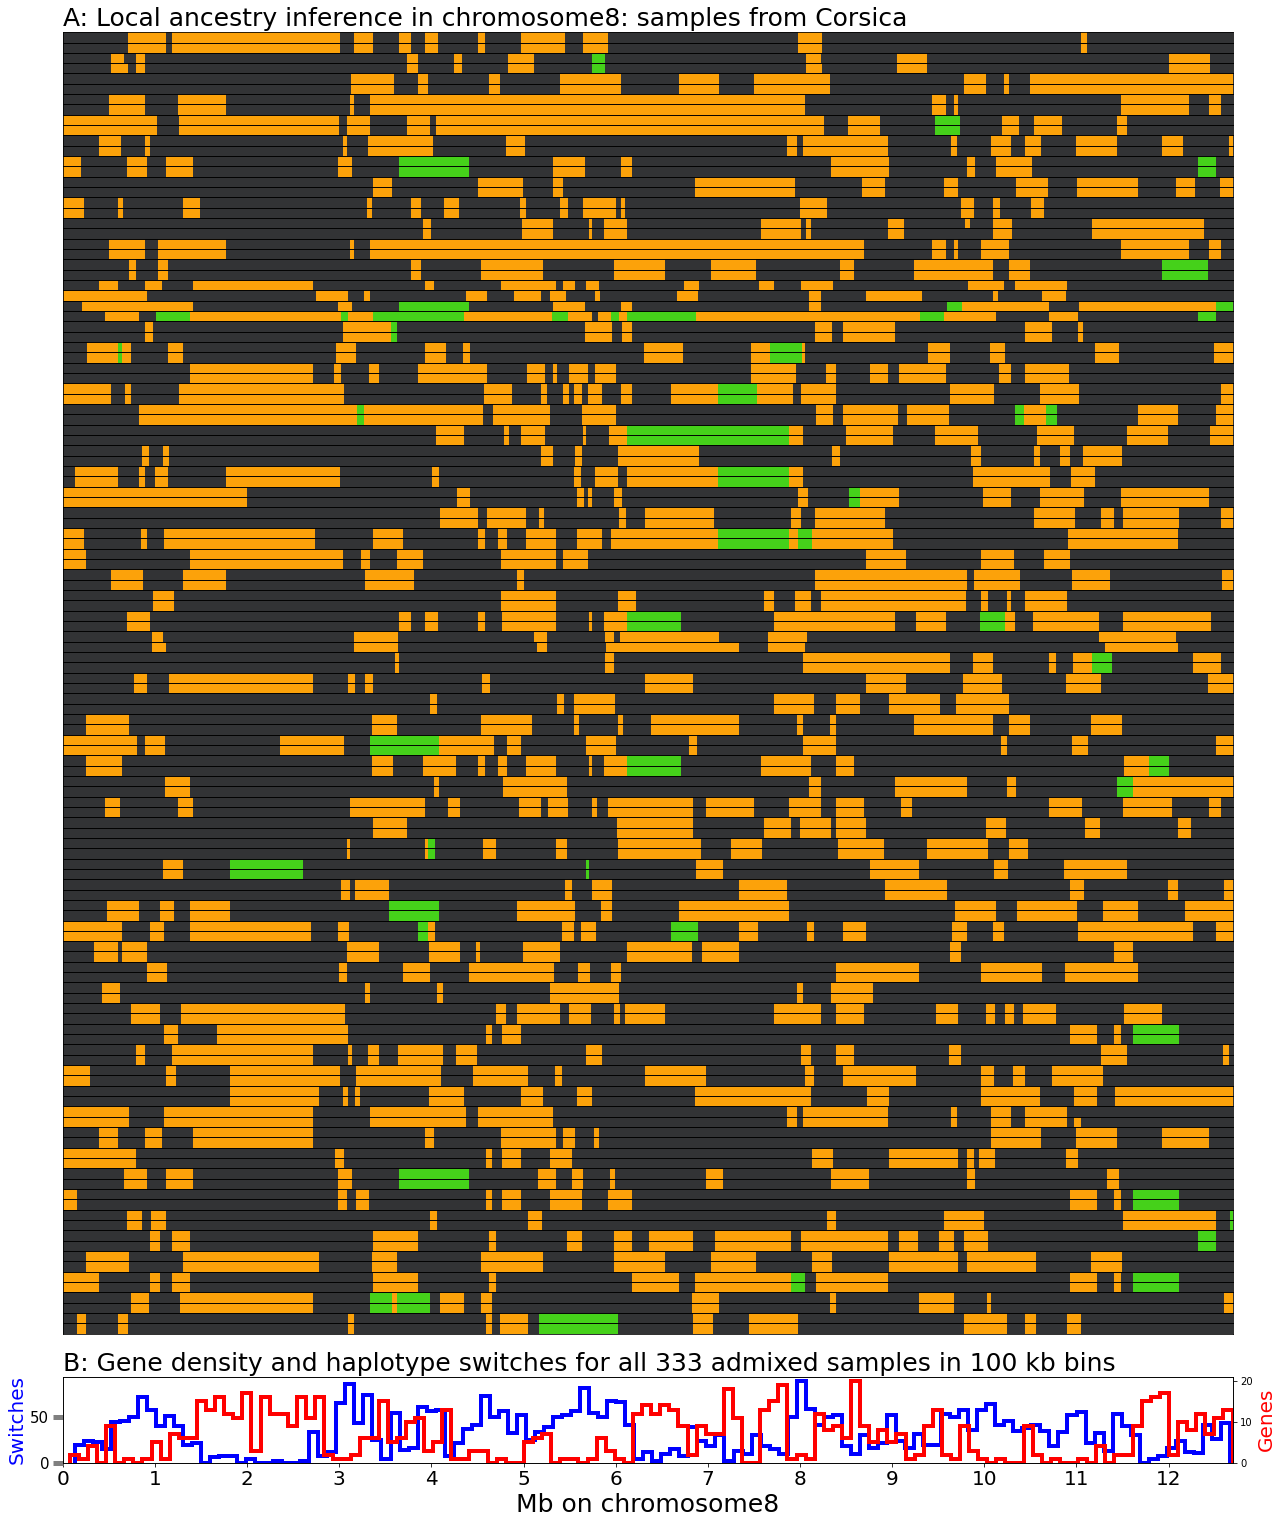

In [10]:
dataDict = {}
dataDictAgg = defaultdict(list)

chromosome = str(8)

with open('/home/avignal/Stage_M2/RFMix/SeqApiPopRFmixChr' + chromosome + '.msp.tsv') as csvFile:
    data=csv.reader(csvFile, delimiter = "\t")
    for row in data:
        if row:
            if not re.search('Subpopulation',row[0]):
                if re.search('chm',row[0]):
                    headers = row               #Get sample names
                    count = 0
                elif (not re.search('chm',row[0])) & (count == 0): #Initiate: first line into dictionary
                    for i in np.arange(6,len(row),1):
                        if row[i] == row[i]:
                            population = row[i]
                        else:
                            population = 9
                        dataDict[headers[i]] = [population,row[1],row[2],row[3],row[4]] #Assign population, start and end of CRF to sample
                    count = 1
                elif (count == 1):
                    for i in np.arange(6,len(row),1):
                        if row[i] == row[i]:
                            population = row[i]
                        else:
                            population = 9
                        if dataDict[headers[i]][0] == population:
                            dataDict[headers[i]][2] = row[2] #assign new End of CRF
                            dataDict[headers[i]][4] = row[4] #assign new End of CRF
                        elif dataDict[headers[i]][0] != population:     #change of population background
                            dataDictAgg["Sample"].append(headers[i]) #new entry for the sample
                            dataDictAgg["Start"].append(dataDict[headers[i]][1]) #
                            dataDictAgg["End"].append(dataDict[headers[i]][2])
                            dataDictAgg["StartGenet"].append(dataDict[headers[i]][3])
                            dataDictAgg["EndGenet"].append(dataDict[headers[i]][4])
                            dataDictAgg["Population"].append(dataDict[headers[i]][0])
                            dataDict[headers[i]] = [population,row[1],row[2],row[3],row[4]]
for i in np.arange(6,len(headers),1):
    dataDictAgg["Sample"].append(headers[i]) #new entry for the sample
    dataDictAgg["Start"].append(dataDict[headers[i]][1]) #
    dataDictAgg["End"].append(dataDict[headers[i]][2])
    dataDictAgg["StartGenet"].append(dataDict[headers[i]][3]) #
    dataDictAgg["EndGenet"].append(dataDict[headers[i]][4])
    dataDictAgg["Population"].append(dataDict[headers[i]][0])

dataAgg = pd.DataFrame.from_dict(dataDictAgg)
dataAgg = dataAgg.astype({'Start':'int','End':'int','StartGenet':'float','EndGenet':'float'})
dataAgg['Sample'] = dataAgg['Sample']
binWidth = 0.1 #in Mb
nbBins = math.ceil(max(dataAgg['End']/1000000) / binWidth)

# Add information on populations
dataSamples = pd.read_excel('/home/avignal/Stage_M2/SequenceGroups870_nouvelles.xlsx',sheet_name='869Samples')
dataSamples = dataSamples.loc[:,['name','RepresentsHive','CategPCA']]
dataSamples.columns = ['Sample','RepresentsHive','CategPCA']
dataSamples = dataSamples.set_index('Sample')
dataAgg = dataAgg.set_index('Sample')
dataAgg = dataAgg.join(dataSamples)
dataAgg = dataAgg.reset_index()

# Assign colour to segments
dataAgg['Colour'] =  "grey"
dataAgg.at[dataAgg.Population == "0",'Colour'] = "#323335ff"                    
dataAgg.at[dataAgg.Population == "1",'Colour'] = "#45d11aff"                     
dataAgg.at[dataAgg.Population == "2",'Colour'] = "#fca20aff"     
dataAgg


# Select samples to plot
#dataTableAggSampleSelection = dataAgg[dataAgg.Sample.str.contains('AOC',regex=True)]
dataTableAggSampleSelection = dataAgg[dataAgg.CategPCA == 'CorsicaNouvelles']
dataTableAggSampleSelection


# Sorted list of samples
sampleCor = dataTableAggSampleSelection['Sample'].unique().tolist()
sampleCor.sort()

#from itertools import chain, repeat

#sampleCor = list(chain.from_iterable(repeat(e, 2) for e in sampleCor))
#sampleCor

#import pandas as pd 
#from IPython.display import display 
#pd.set_option('display.max_rows', 2000) 
#display(dataTableAggSampleSelection)

ybins = len(sampleCor)
#space = (1 / (ybins + 1)) * 1 / 6
#figHeight = (ybins) # + 1) # * 3
figWidth = (max(dataAgg['End'])/5000000 * 8) # + space * 4
figHeight = figWidth / 1.7
#fig = plt.figure(figsize=(figWidth, figHeight))
#fig = plt.figure(figsize=(figWidth,4))
fig = plt.figure(figsize=(figWidth, figHeight))
#fig = plt.figure(constrained_layout=True, figsize=(45,40))

#fig.text(.35,.01, "Position (Mb)", fontsize=40)
#fig.text(0.05,0.50, "Samples from Corsica", fontsize=25, rotation='vertical',)

######################################################
##### First plot histogram of switches across all 333 samples
######################################################

ax = plt.axes([0.07, 0.23, 0.8, 0.1])

ax.hist(dataAgg[dataAgg.Start > 11712]['Start'],bins=nbBins, histtype='step', color = "blue", linewidth=4)
ax.set_xlim(0, max(dataAgg['End']))# /5000000)

xticks = list(np.arange(0,max(dataAgg['End']) ,1000000)) #* 5)
ax.set_xticks(xticks)        
ax.set_xticklabels([int(x / 1000000) for x in xticks], fontsize = 20)
plt.xlabel('Mb on chromosome' + chromosome, fontsize = 25)

ax.yaxis.set_tick_params(labelsize=15, length=10, width=5, color='grey')
ax.set_ylabel('Switches', fontsize = 20, color = "blue")

ax2 = ax.twinx()
chrGenesData = dfGnomon[(dfGnomon.chrom == int(chromosome))]
ax2.set_ylabel('Genes', fontsize = 20, color="red")
ax2.hist(chrGenesData['Pos'], bins=nbBins, histtype='step', color = "red", linewidth=4)

plt.title('B: Gene density and haplotype switches for all 333 admixed samples in 100 kb bins', fontsize = 25, loc='left')

######################################################
##### Then the samples from Corsica
######################################################

#fig.suptitle("Title", fontsize=96)
bottom = 0.38 #space
x_axis = 'yes'
count = 0
for i in sampleCor:
    count = count + 1
    left = 0 #space * 7
    width = figWidth
    height = (0.012)#/ybins)
    ax = plt.axes([0.07, bottom, 0.8, height])    
    if x_axis == 'yes':
        ax.axes.xaxis.set_visible(False)
        xticks = list(np.arange(0,max(dataAgg['End']/5000000) ,0.2)) #* 5)
        ax.set_xticks(xticks)        
        ax.set_xticklabels([int(x * 5) for x in xticks], fontsize = 15)
        plt.xlabel('Mb on chromosome 11', fontsize = 30)
        x_axis = 'false'
    else:
        ax.axes.xaxis.set_visible(False)
    if count == len(sampleCor):
        plt.title('A: Local ancestry inference in chromosome' + chromosome + ': samples from Corsica', fontsize = 25, loc='left')
    ax.axes.yaxis.set_visible(False)
    ax.set_xlim(0, max(dataAgg['End'])/5000000)
    bottom = bottom + height # + space
    dataSample = dataTableAggSampleSelection[dataTableAggSampleSelection.Sample == i]
    for index, row  in dataSample.iterrows():
        start = row["Start"] / 5000000
        end = row["End"] / 5000000
        color = row["Colour"]
        #ax.hlines(0, start, end, colors='orange', linestyles='solid')#, label='', *, data=None, **kwargs)[source]
        ax.axvspan(start, end, ymin=0.0, ymax=1.0, alpha=1, color=color)

#plt.tight_layout()        
#fig



# Plot Chromosome 9

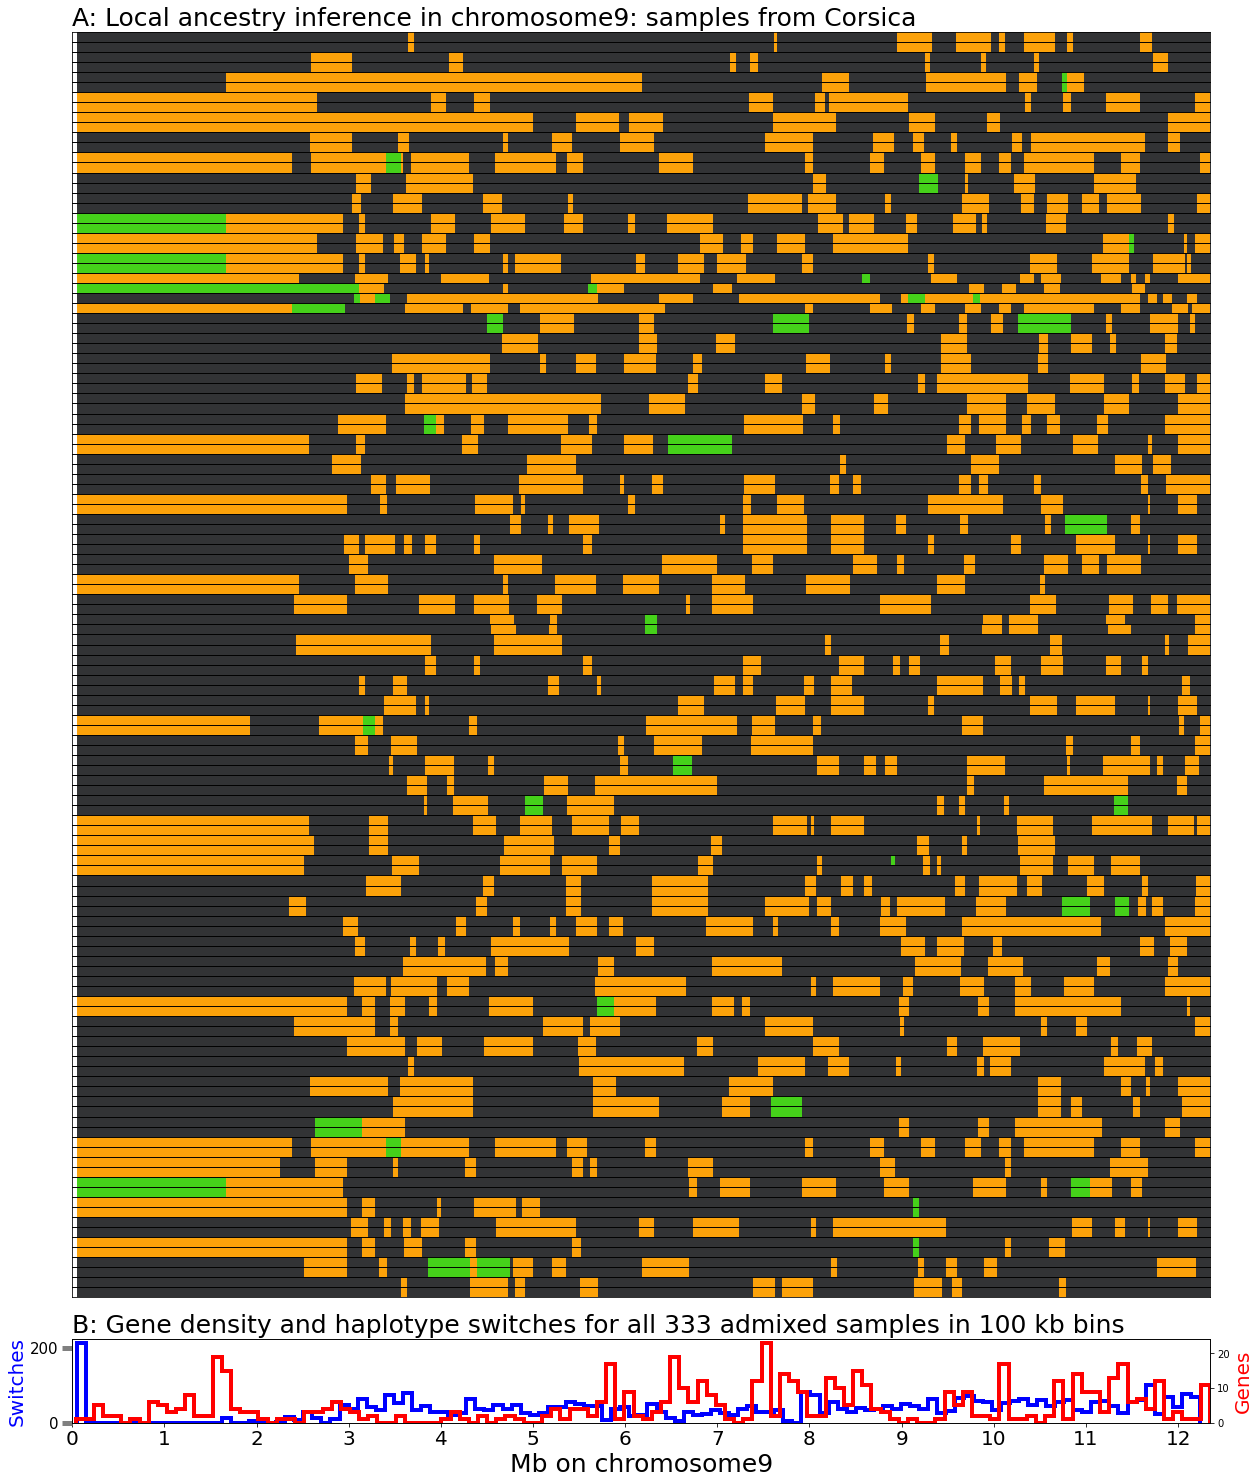

In [11]:
dataDict = {}
dataDictAgg = defaultdict(list)

chromosome = str(9)

with open('/home/avignal/Stage_M2/RFMix/SeqApiPopRFmixChr' + chromosome + '.msp.tsv') as csvFile:
    data=csv.reader(csvFile, delimiter = "\t")
    for row in data:
        if row:
            if not re.search('Subpopulation',row[0]):
                if re.search('chm',row[0]):
                    headers = row               #Get sample names
                    count = 0
                elif (not re.search('chm',row[0])) & (count == 0): #Initiate: first line into dictionary
                    for i in np.arange(6,len(row),1):
                        if row[i] == row[i]:
                            population = row[i]
                        else:
                            population = 9
                        dataDict[headers[i]] = [population,row[1],row[2],row[3],row[4]] #Assign population, start and end of CRF to sample
                    count = 1
                elif (count == 1):
                    for i in np.arange(6,len(row),1):
                        if row[i] == row[i]:
                            population = row[i]
                        else:
                            population = 9
                        if dataDict[headers[i]][0] == population:
                            dataDict[headers[i]][2] = row[2] #assign new End of CRF
                            dataDict[headers[i]][4] = row[4] #assign new End of CRF
                        elif dataDict[headers[i]][0] != population:     #change of population background
                            dataDictAgg["Sample"].append(headers[i]) #new entry for the sample
                            dataDictAgg["Start"].append(dataDict[headers[i]][1]) #
                            dataDictAgg["End"].append(dataDict[headers[i]][2])
                            dataDictAgg["StartGenet"].append(dataDict[headers[i]][3])
                            dataDictAgg["EndGenet"].append(dataDict[headers[i]][4])
                            dataDictAgg["Population"].append(dataDict[headers[i]][0])
                            dataDict[headers[i]] = [population,row[1],row[2],row[3],row[4]]
for i in np.arange(6,len(headers),1):
    dataDictAgg["Sample"].append(headers[i]) #new entry for the sample
    dataDictAgg["Start"].append(dataDict[headers[i]][1]) #
    dataDictAgg["End"].append(dataDict[headers[i]][2])
    dataDictAgg["StartGenet"].append(dataDict[headers[i]][3]) #
    dataDictAgg["EndGenet"].append(dataDict[headers[i]][4])
    dataDictAgg["Population"].append(dataDict[headers[i]][0])

dataAgg = pd.DataFrame.from_dict(dataDictAgg)
dataAgg = dataAgg.astype({'Start':'int','End':'int','StartGenet':'float','EndGenet':'float'})
dataAgg['Sample'] = dataAgg['Sample']
binWidth = 0.1 #in Mb
nbBins = math.ceil(max(dataAgg['End']/1000000) / binWidth)

# Add information on populations
dataSamples = pd.read_excel('/home/avignal/Stage_M2/SequenceGroups870_nouvelles.xlsx',sheet_name='869Samples')
dataSamples = dataSamples.loc[:,['name','RepresentsHive','CategPCA']]
dataSamples.columns = ['Sample','RepresentsHive','CategPCA']
dataSamples = dataSamples.set_index('Sample')
dataAgg = dataAgg.set_index('Sample')
dataAgg = dataAgg.join(dataSamples)
dataAgg = dataAgg.reset_index()

# Assign colour to segments
dataAgg['Colour'] =  "grey"
dataAgg.at[dataAgg.Population == "0",'Colour'] = "#323335ff"                    
dataAgg.at[dataAgg.Population == "1",'Colour'] = "#45d11aff"                     
dataAgg.at[dataAgg.Population == "2",'Colour'] = "#fca20aff"     
dataAgg


# Select samples to plot
#dataTableAggSampleSelection = dataAgg[dataAgg.Sample.str.contains('AOC',regex=True)]
dataTableAggSampleSelection = dataAgg[dataAgg.CategPCA == 'CorsicaNouvelles']
dataTableAggSampleSelection


# Sorted list of samples
sampleCor = dataTableAggSampleSelection['Sample'].unique().tolist()
sampleCor.sort()

#from itertools import chain, repeat

#sampleCor = list(chain.from_iterable(repeat(e, 2) for e in sampleCor))
#sampleCor

#import pandas as pd 
#from IPython.display import display 
#pd.set_option('display.max_rows', 2000) 
#display(dataTableAggSampleSelection)

ybins = len(sampleCor)
#space = (1 / (ybins + 1)) * 1 / 6
#figHeight = (ybins) # + 1) # * 3
figWidth = (max(dataAgg['End'])/5000000 * 8) # + space * 4
figHeight = figWidth / 1.7
#fig = plt.figure(figsize=(figWidth, figHeight))
#fig = plt.figure(figsize=(figWidth,4))
fig = plt.figure(figsize=(figWidth, figHeight))
#fig = plt.figure(constrained_layout=True, figsize=(45,40))

#fig.text(.35,.01, "Position (Mb)", fontsize=40)
#fig.text(0.05,0.50, "Samples from Corsica", fontsize=25, rotation='vertical',)

######################################################
##### First plot histogram of switches across all 333 samples
######################################################

ax = plt.axes([0.07, 0.23, 0.8, 0.1])

ax.hist(dataAgg[dataAgg.Start > 11712]['Start'],bins=nbBins, histtype='step', color = "blue", linewidth=4)
ax.set_xlim(0, max(dataAgg['End']))# /5000000)

xticks = list(np.arange(0,max(dataAgg['End']) ,1000000)) #* 5)
ax.set_xticks(xticks)        
ax.set_xticklabels([int(x / 1000000) for x in xticks], fontsize = 20)
plt.xlabel('Mb on chromosome' + chromosome, fontsize = 25)

ax.yaxis.set_tick_params(labelsize=15, length=10, width=5, color='grey')
ax.set_ylabel('Switches', fontsize = 20, color = "blue")

ax2 = ax.twinx()
chrGenesData = dfGnomon[(dfGnomon.chrom == int(chromosome))]
ax2.set_ylabel('Genes', fontsize = 20, color="red")
ax2.hist(chrGenesData['Pos'], bins=nbBins, histtype='step', color = "red", linewidth=4)

plt.title('B: Gene density and haplotype switches for all 333 admixed samples in 100 kb bins', fontsize = 25, loc='left')

######################################################
##### Then the samples from Corsica
######################################################

#fig.suptitle("Title", fontsize=96)
bottom = 0.38 #space
x_axis = 'yes'
count = 0
for i in sampleCor:
    count = count + 1
    left = 0 #space * 7
    width = figWidth
    height = (0.012)#/ybins)
    ax = plt.axes([0.07, bottom, 0.8, height])    
    if x_axis == 'yes':
        ax.axes.xaxis.set_visible(False)
        xticks = list(np.arange(0,max(dataAgg['End']/5000000) ,0.2)) #* 5)
        ax.set_xticks(xticks)        
        ax.set_xticklabels([int(x * 5) for x in xticks], fontsize = 15)
        plt.xlabel('Mb on chromosome 11', fontsize = 30)
        x_axis = 'false'
    else:
        ax.axes.xaxis.set_visible(False)
    if count == len(sampleCor):
        plt.title('A: Local ancestry inference in chromosome' + chromosome + ': samples from Corsica', fontsize = 25, loc='left')
    ax.axes.yaxis.set_visible(False)
    ax.set_xlim(0, max(dataAgg['End'])/5000000)
    bottom = bottom + height # + space
    dataSample = dataTableAggSampleSelection[dataTableAggSampleSelection.Sample == i]
    for index, row  in dataSample.iterrows():
        start = row["Start"] / 5000000
        end = row["End"] / 5000000
        color = row["Colour"]
        #ax.hlines(0, start, end, colors='orange', linestyles='solid')#, label='', *, data=None, **kwargs)[source]
        ax.axvspan(start, end, ymin=0.0, ymax=1.0, alpha=1, color=color)

#plt.tight_layout()        
#fig



# plot Chromosome 10

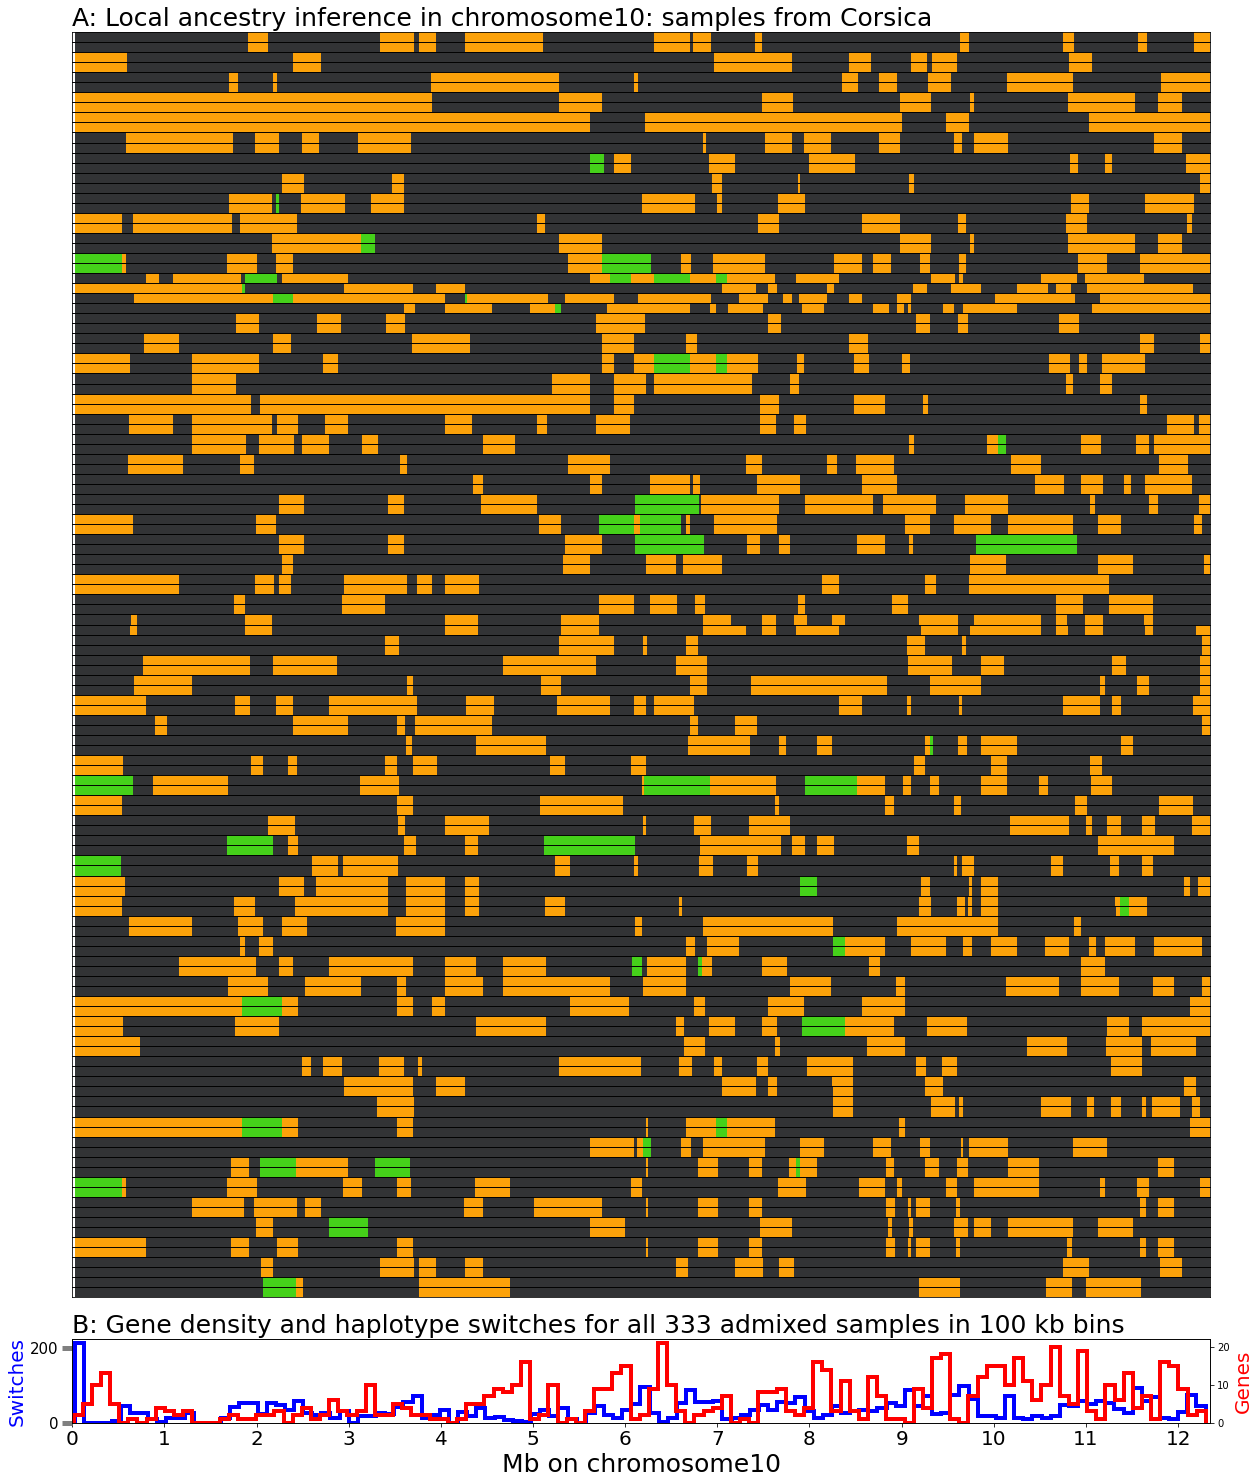

In [12]:
dataDict = {}
dataDictAgg = defaultdict(list)

chromosome = str(10)

with open('/home/avignal/Stage_M2/RFMix/SeqApiPopRFmixChr' + chromosome + '.msp.tsv') as csvFile:
    data=csv.reader(csvFile, delimiter = "\t")
    for row in data:
        if row:
            if not re.search('Subpopulation',row[0]):
                if re.search('chm',row[0]):
                    headers = row               #Get sample names
                    count = 0
                elif (not re.search('chm',row[0])) & (count == 0): #Initiate: first line into dictionary
                    for i in np.arange(6,len(row),1):
                        if row[i] == row[i]:
                            population = row[i]
                        else:
                            population = 9
                        dataDict[headers[i]] = [population,row[1],row[2],row[3],row[4]] #Assign population, start and end of CRF to sample
                    count = 1
                elif (count == 1):
                    for i in np.arange(6,len(row),1):
                        if row[i] == row[i]:
                            population = row[i]
                        else:
                            population = 9
                        if dataDict[headers[i]][0] == population:
                            dataDict[headers[i]][2] = row[2] #assign new End of CRF
                            dataDict[headers[i]][4] = row[4] #assign new End of CRF
                        elif dataDict[headers[i]][0] != population:     #change of population background
                            dataDictAgg["Sample"].append(headers[i]) #new entry for the sample
                            dataDictAgg["Start"].append(dataDict[headers[i]][1]) #
                            dataDictAgg["End"].append(dataDict[headers[i]][2])
                            dataDictAgg["StartGenet"].append(dataDict[headers[i]][3])
                            dataDictAgg["EndGenet"].append(dataDict[headers[i]][4])
                            dataDictAgg["Population"].append(dataDict[headers[i]][0])
                            dataDict[headers[i]] = [population,row[1],row[2],row[3],row[4]]
for i in np.arange(6,len(headers),1):
    dataDictAgg["Sample"].append(headers[i]) #new entry for the sample
    dataDictAgg["Start"].append(dataDict[headers[i]][1]) #
    dataDictAgg["End"].append(dataDict[headers[i]][2])
    dataDictAgg["StartGenet"].append(dataDict[headers[i]][3]) #
    dataDictAgg["EndGenet"].append(dataDict[headers[i]][4])
    dataDictAgg["Population"].append(dataDict[headers[i]][0])

dataAgg = pd.DataFrame.from_dict(dataDictAgg)
dataAgg = dataAgg.astype({'Start':'int','End':'int','StartGenet':'float','EndGenet':'float'})
dataAgg['Sample'] = dataAgg['Sample']
binWidth = 0.1 #in Mb
nbBins = math.ceil(max(dataAgg['End']/1000000) / binWidth)

# Add information on populations
dataSamples = pd.read_excel('/home/avignal/Stage_M2/SequenceGroups870_nouvelles.xlsx',sheet_name='869Samples')
dataSamples = dataSamples.loc[:,['name','RepresentsHive','CategPCA']]
dataSamples.columns = ['Sample','RepresentsHive','CategPCA']
dataSamples = dataSamples.set_index('Sample')
dataAgg = dataAgg.set_index('Sample')
dataAgg = dataAgg.join(dataSamples)
dataAgg = dataAgg.reset_index()

# Assign colour to segments
dataAgg['Colour'] =  "grey"
dataAgg.at[dataAgg.Population == "0",'Colour'] = "#323335ff"                    
dataAgg.at[dataAgg.Population == "1",'Colour'] = "#45d11aff"                     
dataAgg.at[dataAgg.Population == "2",'Colour'] = "#fca20aff"     
dataAgg


# Select samples to plot
#dataTableAggSampleSelection = dataAgg[dataAgg.Sample.str.contains('AOC',regex=True)]
dataTableAggSampleSelection = dataAgg[dataAgg.CategPCA == 'CorsicaNouvelles']
dataTableAggSampleSelection


# Sorted list of samples
sampleCor = dataTableAggSampleSelection['Sample'].unique().tolist()
sampleCor.sort()

#from itertools import chain, repeat

#sampleCor = list(chain.from_iterable(repeat(e, 2) for e in sampleCor))
#sampleCor

#import pandas as pd 
#from IPython.display import display 
#pd.set_option('display.max_rows', 2000) 
#display(dataTableAggSampleSelection)

ybins = len(sampleCor)
#space = (1 / (ybins + 1)) * 1 / 6
#figHeight = (ybins) # + 1) # * 3
figWidth = (max(dataAgg['End'])/5000000 * 8) # + space * 4
figHeight = figWidth / 1.7
#fig = plt.figure(figsize=(figWidth, figHeight))
#fig = plt.figure(figsize=(figWidth,4))
fig = plt.figure(figsize=(figWidth, figHeight))
#fig = plt.figure(constrained_layout=True, figsize=(45,40))

#fig.text(.35,.01, "Position (Mb)", fontsize=40)
#fig.text(0.05,0.50, "Samples from Corsica", fontsize=25, rotation='vertical',)

######################################################
##### First plot histogram of switches across all 333 samples
######################################################

ax = plt.axes([0.07, 0.23, 0.8, 0.1])

ax.hist(dataAgg[dataAgg.Start > 11712]['Start'],bins=nbBins, histtype='step', color = "blue", linewidth=4)
ax.set_xlim(0, max(dataAgg['End']))# /5000000)

xticks = list(np.arange(0,max(dataAgg['End']) ,1000000)) #* 5)
ax.set_xticks(xticks)        
ax.set_xticklabels([int(x / 1000000) for x in xticks], fontsize = 20)
plt.xlabel('Mb on chromosome' + chromosome, fontsize = 25)

ax.yaxis.set_tick_params(labelsize=15, length=10, width=5, color='grey')
ax.set_ylabel('Switches', fontsize = 20, color = "blue")

ax2 = ax.twinx()
chrGenesData = dfGnomon[(dfGnomon.chrom == int(chromosome))]
ax2.set_ylabel('Genes', fontsize = 20, color="red")
ax2.hist(chrGenesData['Pos'], bins=nbBins, histtype='step', color = "red", linewidth=4)

plt.title('B: Gene density and haplotype switches for all 333 admixed samples in 100 kb bins', fontsize = 25, loc='left')

######################################################
##### Then the samples from Corsica
######################################################

#fig.suptitle("Title", fontsize=96)
bottom = 0.38 #space
x_axis = 'yes'
count = 0
for i in sampleCor:
    count = count + 1
    left = 0 #space * 7
    width = figWidth
    height = (0.012)#/ybins)
    ax = plt.axes([0.07, bottom, 0.8, height])    
    if x_axis == 'yes':
        ax.axes.xaxis.set_visible(False)
        xticks = list(np.arange(0,max(dataAgg['End']/5000000) ,0.2)) #* 5)
        ax.set_xticks(xticks)        
        ax.set_xticklabels([int(x * 5) for x in xticks], fontsize = 15)
        plt.xlabel('Mb on chromosome 11', fontsize = 30)
        x_axis = 'false'
    else:
        ax.axes.xaxis.set_visible(False)
    if count == len(sampleCor):
        plt.title('A: Local ancestry inference in chromosome' + chromosome + ': samples from Corsica', fontsize = 25, loc='left')
    ax.axes.yaxis.set_visible(False)
    ax.set_xlim(0, max(dataAgg['End'])/5000000)
    bottom = bottom + height # + space
    dataSample = dataTableAggSampleSelection[dataTableAggSampleSelection.Sample == i]
    for index, row  in dataSample.iterrows():
        start = row["Start"] / 5000000
        end = row["End"] / 5000000
        color = row["Colour"]
        #ax.hlines(0, start, end, colors='orange', linestyles='solid')#, label='', *, data=None, **kwargs)[source]
        ax.axvspan(start, end, ymin=0.0, ymax=1.0, alpha=1, color=color)

#plt.tight_layout()        
#fig



# Plot Chromosome 11

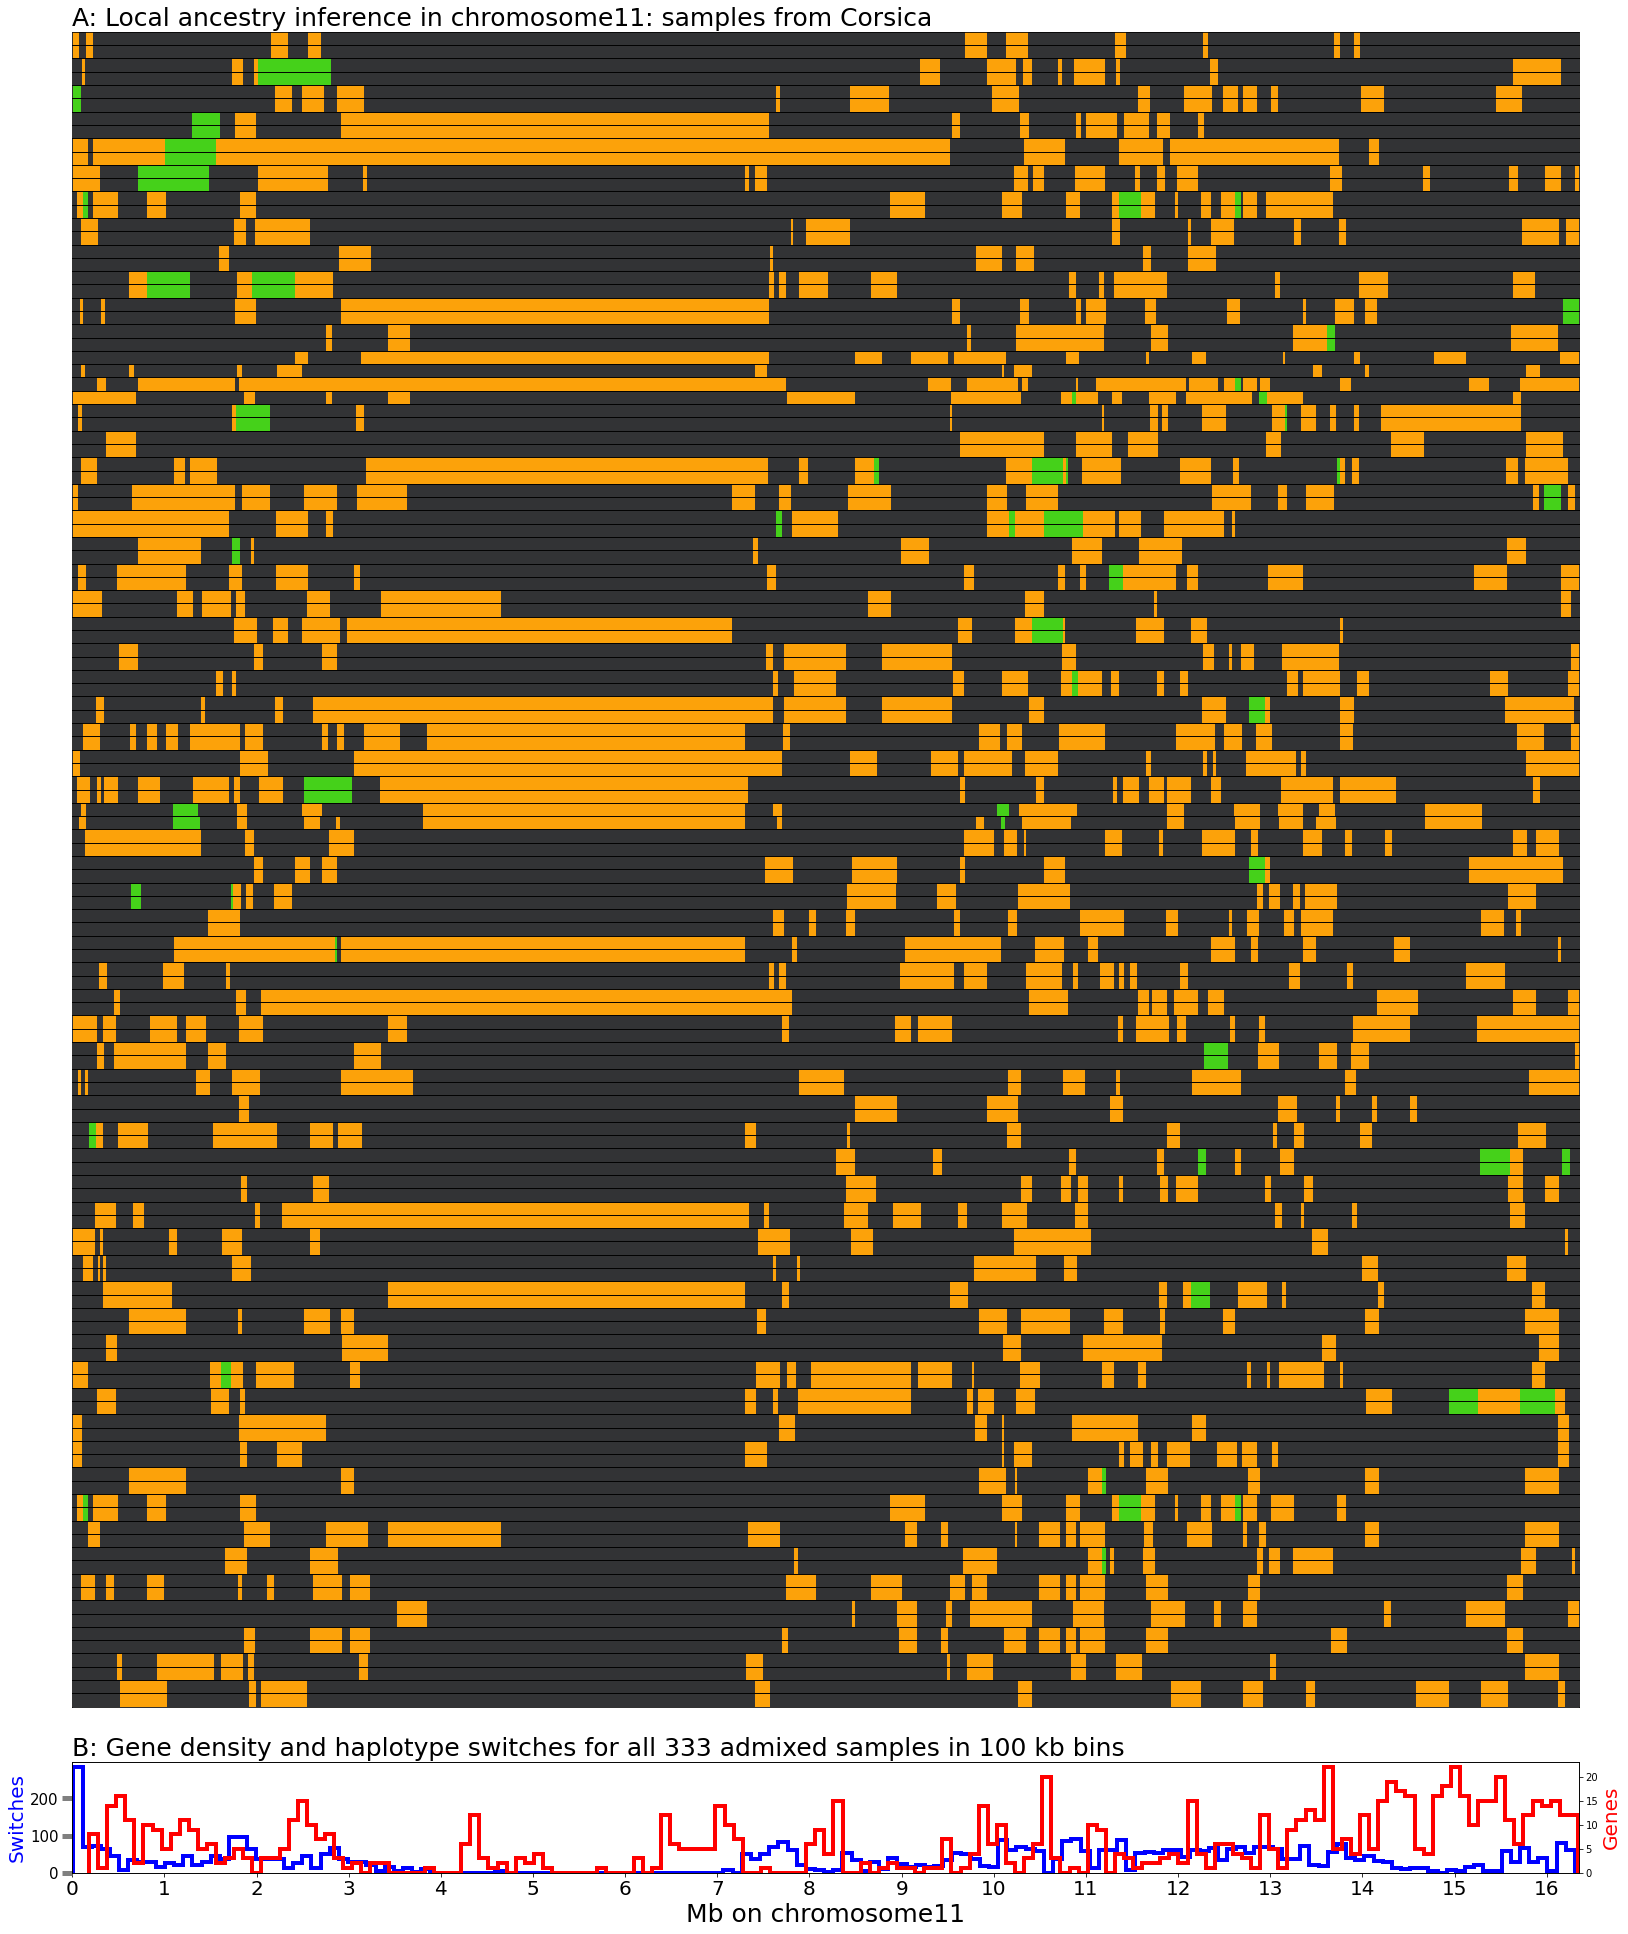

In [13]:
dataDict = {}
dataDictAgg = defaultdict(list)

chromosome = str(11)

with open('/home/avignal/Stage_M2/RFMix/SeqApiPopRFmixChr' + chromosome + '.msp.tsv') as csvFile:
    data=csv.reader(csvFile, delimiter = "\t")
    for row in data:
        if row:
            if not re.search('Subpopulation',row[0]):
                if re.search('chm',row[0]):
                    headers = row               #Get sample names
                    count = 0
                elif (not re.search('chm',row[0])) & (count == 0): #Initiate: first line into dictionary
                    for i in np.arange(6,len(row),1):
                        if row[i] == row[i]:
                            population = row[i]
                        else:
                            population = 9
                        dataDict[headers[i]] = [population,row[1],row[2],row[3],row[4]] #Assign population, start and end of CRF to sample
                    count = 1
                elif (count == 1):
                    for i in np.arange(6,len(row),1):
                        if row[i] == row[i]:
                            population = row[i]
                        else:
                            population = 9
                        if dataDict[headers[i]][0] == population:
                            dataDict[headers[i]][2] = row[2] #assign new End of CRF
                            dataDict[headers[i]][4] = row[4] #assign new End of CRF
                        elif dataDict[headers[i]][0] != population:     #change of population background
                            dataDictAgg["Sample"].append(headers[i]) #new entry for the sample
                            dataDictAgg["Start"].append(dataDict[headers[i]][1]) #
                            dataDictAgg["End"].append(dataDict[headers[i]][2])
                            dataDictAgg["StartGenet"].append(dataDict[headers[i]][3])
                            dataDictAgg["EndGenet"].append(dataDict[headers[i]][4])
                            dataDictAgg["Population"].append(dataDict[headers[i]][0])
                            dataDict[headers[i]] = [population,row[1],row[2],row[3],row[4]]
for i in np.arange(6,len(headers),1):
    dataDictAgg["Sample"].append(headers[i]) #new entry for the sample
    dataDictAgg["Start"].append(dataDict[headers[i]][1]) #
    dataDictAgg["End"].append(dataDict[headers[i]][2])
    dataDictAgg["StartGenet"].append(dataDict[headers[i]][3]) #
    dataDictAgg["EndGenet"].append(dataDict[headers[i]][4])
    dataDictAgg["Population"].append(dataDict[headers[i]][0])

dataAgg = pd.DataFrame.from_dict(dataDictAgg)
dataAgg = dataAgg.astype({'Start':'int','End':'int','StartGenet':'float','EndGenet':'float'})
dataAgg['Sample'] = dataAgg['Sample']
binWidth = 0.1 #in Mb
nbBins = math.ceil(max(dataAgg['End']/1000000) / binWidth)

# Add information on populations
dataSamples = pd.read_excel('/home/avignal/Stage_M2/SequenceGroups870_nouvelles.xlsx',sheet_name='869Samples')
dataSamples = dataSamples.loc[:,['name','RepresentsHive','CategPCA']]
dataSamples.columns = ['Sample','RepresentsHive','CategPCA']
dataSamples = dataSamples.set_index('Sample')
dataAgg = dataAgg.set_index('Sample')
dataAgg = dataAgg.join(dataSamples)
dataAgg = dataAgg.reset_index()

# Assign colour to segments
dataAgg['Colour'] =  "grey"
dataAgg.at[dataAgg.Population == "0",'Colour'] = "#323335ff"                    
dataAgg.at[dataAgg.Population == "1",'Colour'] = "#45d11aff"                     
dataAgg.at[dataAgg.Population == "2",'Colour'] = "#fca20aff"     
dataAgg


# Select samples to plot
#dataTableAggSampleSelection = dataAgg[dataAgg.Sample.str.contains('AOC',regex=True)]
dataTableAggSampleSelection = dataAgg[dataAgg.CategPCA == 'CorsicaNouvelles']
dataTableAggSampleSelection


# Sorted list of samples
sampleCor = dataTableAggSampleSelection['Sample'].unique().tolist()
sampleCor.sort()

#from itertools import chain, repeat

#sampleCor = list(chain.from_iterable(repeat(e, 2) for e in sampleCor))
#sampleCor

#import pandas as pd 
#from IPython.display import display 
#pd.set_option('display.max_rows', 2000) 
#display(dataTableAggSampleSelection)

ybins = len(sampleCor)
#space = (1 / (ybins + 1)) * 1 / 6
#figHeight = (ybins) # + 1) # * 3
figWidth = (max(dataAgg['End'])/5000000 * 8) # + space * 4
figHeight = figWidth / 1.7
#fig = plt.figure(figsize=(figWidth, figHeight))
#fig = plt.figure(figsize=(figWidth,4))
fig = plt.figure(figsize=(figWidth, figHeight))
#fig = plt.figure(constrained_layout=True, figsize=(45,40))

#fig.text(.35,.01, "Position (Mb)", fontsize=40)
#fig.text(0.05,0.50, "Samples from Corsica", fontsize=25, rotation='vertical',)

######################################################
##### First plot histogram of switches across all 333 samples
######################################################

ax = plt.axes([0.07, 0.23, 0.8, 0.1])

ax.hist(dataAgg[dataAgg.Start > 11712]['Start'],bins=nbBins, histtype='step', color = "blue", linewidth=4)
ax.set_xlim(0, max(dataAgg['End']))# /5000000)

xticks = list(np.arange(0,max(dataAgg['End']) ,1000000)) #* 5)
ax.set_xticks(xticks)        
ax.set_xticklabels([int(x / 1000000) for x in xticks], fontsize = 20)
plt.xlabel('Mb on chromosome' + chromosome, fontsize = 25)

ax.yaxis.set_tick_params(labelsize=15, length=10, width=5, color='grey')
ax.set_ylabel('Switches', fontsize = 20, color = "blue")

ax2 = ax.twinx()
chrGenesData = dfGnomon[(dfGnomon.chrom == int(chromosome))]
ax2.set_ylabel('Genes', fontsize = 20, color="red")
ax2.hist(chrGenesData['Pos'], bins=nbBins, histtype='step', color = "red", linewidth=4)

plt.title('B: Gene density and haplotype switches for all 333 admixed samples in 100 kb bins', fontsize = 25, loc='left')

######################################################
##### Then the samples from Corsica
######################################################

#fig.suptitle("Title", fontsize=96)
bottom = 0.38 #space
x_axis = 'yes'
count = 0
for i in sampleCor:
    count = count + 1
    left = 0 #space * 7
    width = figWidth
    height = (0.012)#/ybins)
    ax = plt.axes([0.07, bottom, 0.8, height])    
    if x_axis == 'yes':
        ax.axes.xaxis.set_visible(False)
        xticks = list(np.arange(0,max(dataAgg['End']/5000000) ,0.2)) #* 5)
        ax.set_xticks(xticks)        
        ax.set_xticklabels([int(x * 5) for x in xticks], fontsize = 15)
        plt.xlabel('Mb on chromosome 11', fontsize = 30)
        x_axis = 'false'
    else:
        ax.axes.xaxis.set_visible(False)
    if count == len(sampleCor):
        plt.title('A: Local ancestry inference in chromosome' + chromosome + ': samples from Corsica', fontsize = 25, loc='left')
    ax.axes.yaxis.set_visible(False)
    ax.set_xlim(0, max(dataAgg['End'])/5000000)
    bottom = bottom + height # + space
    dataSample = dataTableAggSampleSelection[dataTableAggSampleSelection.Sample == i]
    for index, row  in dataSample.iterrows():
        start = row["Start"] / 5000000
        end = row["End"] / 5000000
        color = row["Colour"]
        #ax.hlines(0, start, end, colors='orange', linestyles='solid')#, label='', *, data=None, **kwargs)[source]
        ax.axvspan(start, end, ymin=0.0, ymax=1.0, alpha=1, color=color)

#plt.tight_layout()        
#fig



# Plot Chromosome 12

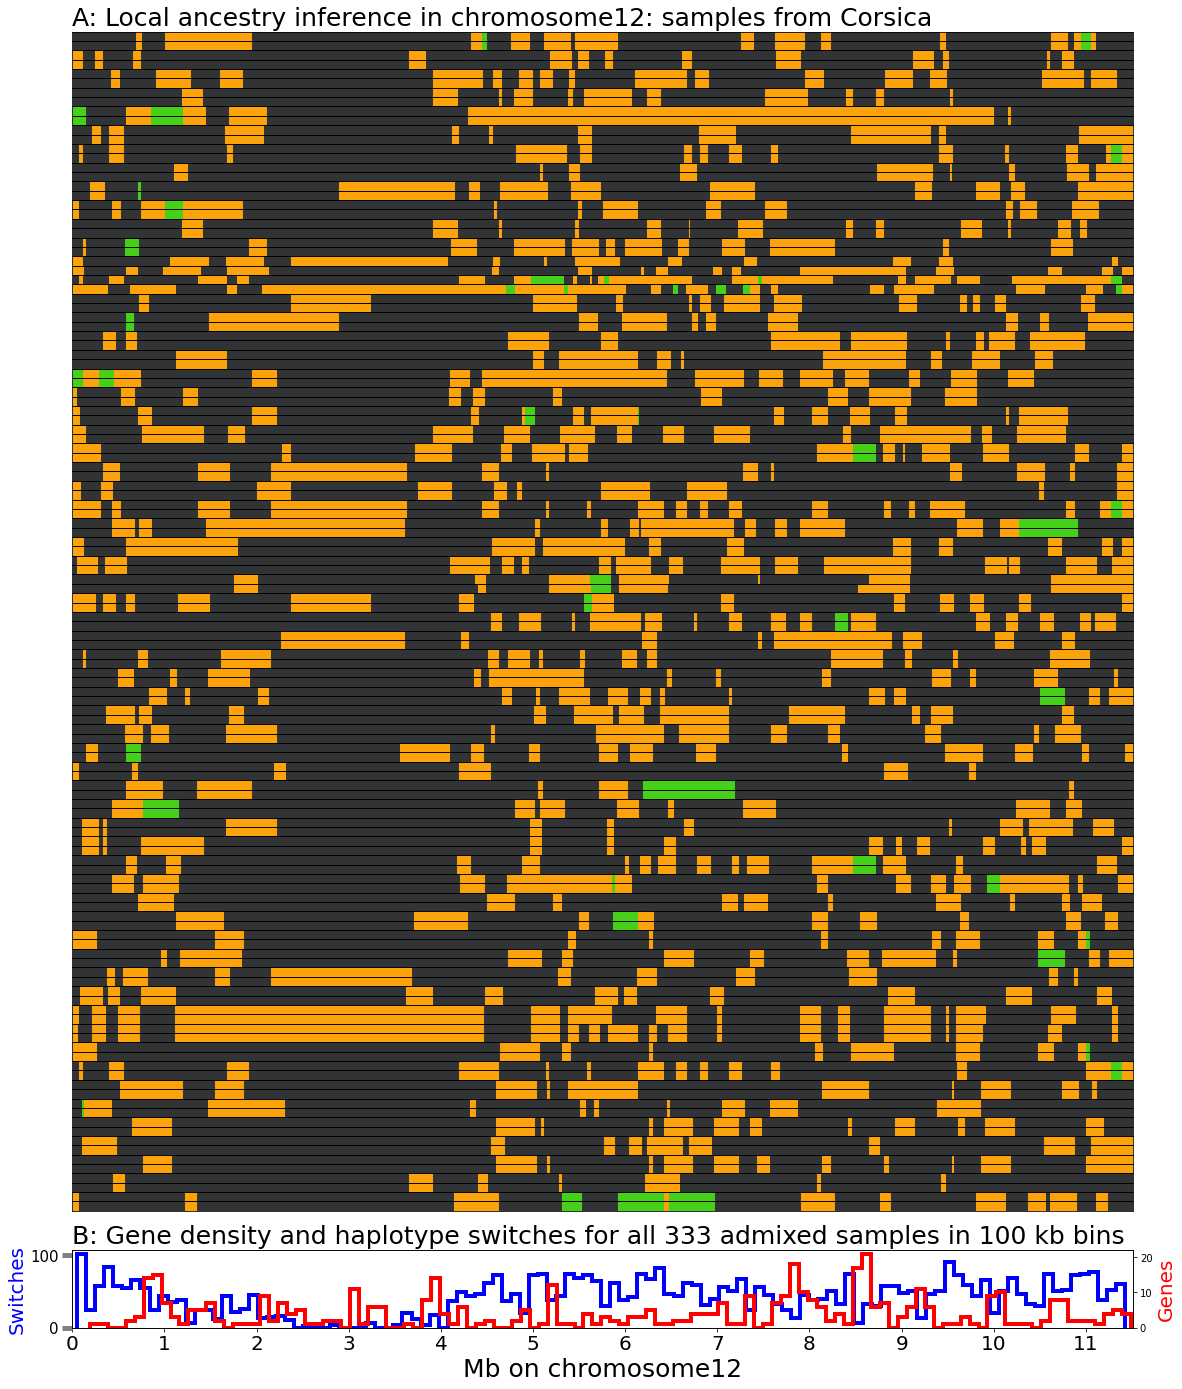

In [14]:
dataDict = {}
dataDictAgg = defaultdict(list)

chromosome = str(12)

with open('/home/avignal/Stage_M2/RFMix/SeqApiPopRFmixChr' + chromosome + '.msp.tsv') as csvFile:
    data=csv.reader(csvFile, delimiter = "\t")
    for row in data:
        if row:
            if not re.search('Subpopulation',row[0]):
                if re.search('chm',row[0]):
                    headers = row               #Get sample names
                    count = 0
                elif (not re.search('chm',row[0])) & (count == 0): #Initiate: first line into dictionary
                    for i in np.arange(6,len(row),1):
                        if row[i] == row[i]:
                            population = row[i]
                        else:
                            population = 9
                        dataDict[headers[i]] = [population,row[1],row[2],row[3],row[4]] #Assign population, start and end of CRF to sample
                    count = 1
                elif (count == 1):
                    for i in np.arange(6,len(row),1):
                        if row[i] == row[i]:
                            population = row[i]
                        else:
                            population = 9
                        if dataDict[headers[i]][0] == population:
                            dataDict[headers[i]][2] = row[2] #assign new End of CRF
                            dataDict[headers[i]][4] = row[4] #assign new End of CRF
                        elif dataDict[headers[i]][0] != population:     #change of population background
                            dataDictAgg["Sample"].append(headers[i]) #new entry for the sample
                            dataDictAgg["Start"].append(dataDict[headers[i]][1]) #
                            dataDictAgg["End"].append(dataDict[headers[i]][2])
                            dataDictAgg["StartGenet"].append(dataDict[headers[i]][3])
                            dataDictAgg["EndGenet"].append(dataDict[headers[i]][4])
                            dataDictAgg["Population"].append(dataDict[headers[i]][0])
                            dataDict[headers[i]] = [population,row[1],row[2],row[3],row[4]]
for i in np.arange(6,len(headers),1):
    dataDictAgg["Sample"].append(headers[i]) #new entry for the sample
    dataDictAgg["Start"].append(dataDict[headers[i]][1]) #
    dataDictAgg["End"].append(dataDict[headers[i]][2])
    dataDictAgg["StartGenet"].append(dataDict[headers[i]][3]) #
    dataDictAgg["EndGenet"].append(dataDict[headers[i]][4])
    dataDictAgg["Population"].append(dataDict[headers[i]][0])

dataAgg = pd.DataFrame.from_dict(dataDictAgg)
dataAgg = dataAgg.astype({'Start':'int','End':'int','StartGenet':'float','EndGenet':'float'})
dataAgg['Sample'] = dataAgg['Sample']
binWidth = 0.1 #in Mb
nbBins = math.ceil(max(dataAgg['End']/1000000) / binWidth)

# Add information on populations
dataSamples = pd.read_excel('/home/avignal/Stage_M2/SequenceGroups870_nouvelles.xlsx',sheet_name='869Samples')
dataSamples = dataSamples.loc[:,['name','RepresentsHive','CategPCA']]
dataSamples.columns = ['Sample','RepresentsHive','CategPCA']
dataSamples = dataSamples.set_index('Sample')
dataAgg = dataAgg.set_index('Sample')
dataAgg = dataAgg.join(dataSamples)
dataAgg = dataAgg.reset_index()

# Assign colour to segments
dataAgg['Colour'] =  "grey"
dataAgg.at[dataAgg.Population == "0",'Colour'] = "#323335ff"                    
dataAgg.at[dataAgg.Population == "1",'Colour'] = "#45d11aff"                     
dataAgg.at[dataAgg.Population == "2",'Colour'] = "#fca20aff"     
dataAgg


# Select samples to plot
#dataTableAggSampleSelection = dataAgg[dataAgg.Sample.str.contains('AOC',regex=True)]
dataTableAggSampleSelection = dataAgg[dataAgg.CategPCA == 'CorsicaNouvelles']
dataTableAggSampleSelection


# Sorted list of samples
sampleCor = dataTableAggSampleSelection['Sample'].unique().tolist()
sampleCor.sort()

#from itertools import chain, repeat

#sampleCor = list(chain.from_iterable(repeat(e, 2) for e in sampleCor))
#sampleCor

#import pandas as pd 
#from IPython.display import display 
#pd.set_option('display.max_rows', 2000) 
#display(dataTableAggSampleSelection)

ybins = len(sampleCor)
#space = (1 / (ybins + 1)) * 1 / 6
#figHeight = (ybins) # + 1) # * 3
figWidth = (max(dataAgg['End'])/5000000 * 8) # + space * 4
figHeight = figWidth / 1.7
#fig = plt.figure(figsize=(figWidth, figHeight))
#fig = plt.figure(figsize=(figWidth,4))
fig = plt.figure(figsize=(figWidth, figHeight))
#fig = plt.figure(constrained_layout=True, figsize=(45,40))

#fig.text(.35,.01, "Position (Mb)", fontsize=40)
#fig.text(0.05,0.50, "Samples from Corsica", fontsize=25, rotation='vertical',)

######################################################
##### First plot histogram of switches across all 333 samples
######################################################

ax = plt.axes([0.07, 0.23, 0.8, 0.1])

ax.hist(dataAgg[dataAgg.Start > 11712]['Start'],bins=nbBins, histtype='step', color = "blue", linewidth=4)
ax.set_xlim(0, max(dataAgg['End']))# /5000000)

xticks = list(np.arange(0,max(dataAgg['End']) ,1000000)) #* 5)
ax.set_xticks(xticks)        
ax.set_xticklabels([int(x / 1000000) for x in xticks], fontsize = 20)
plt.xlabel('Mb on chromosome' + chromosome, fontsize = 25)

ax.yaxis.set_tick_params(labelsize=15, length=10, width=5, color='grey')
ax.set_ylabel('Switches', fontsize = 20, color = "blue")

ax2 = ax.twinx()
chrGenesData = dfGnomon[(dfGnomon.chrom == int(chromosome))]
ax2.set_ylabel('Genes', fontsize = 20, color="red")
ax2.hist(chrGenesData['Pos'], bins=nbBins, histtype='step', color = "red", linewidth=4)

plt.title('B: Gene density and haplotype switches for all 333 admixed samples in 100 kb bins', fontsize = 25, loc='left')

######################################################
##### Then the samples from Corsica
######################################################

#fig.suptitle("Title", fontsize=96)
bottom = 0.38 #space
x_axis = 'yes'
count = 0
for i in sampleCor:
    count = count + 1
    left = 0 #space * 7
    width = figWidth
    height = (0.012)#/ybins)
    ax = plt.axes([0.07, bottom, 0.8, height])    
    if x_axis == 'yes':
        ax.axes.xaxis.set_visible(False)
        xticks = list(np.arange(0,max(dataAgg['End']/5000000) ,0.2)) #* 5)
        ax.set_xticks(xticks)        
        ax.set_xticklabels([int(x * 5) for x in xticks], fontsize = 15)
        plt.xlabel('Mb on chromosome 11', fontsize = 30)
        x_axis = 'false'
    else:
        ax.axes.xaxis.set_visible(False)
    if count == len(sampleCor):
        plt.title('A: Local ancestry inference in chromosome' + chromosome + ': samples from Corsica', fontsize = 25, loc='left')
    ax.axes.yaxis.set_visible(False)
    ax.set_xlim(0, max(dataAgg['End'])/5000000)
    bottom = bottom + height # + space
    dataSample = dataTableAggSampleSelection[dataTableAggSampleSelection.Sample == i]
    for index, row  in dataSample.iterrows():
        start = row["Start"] / 5000000
        end = row["End"] / 5000000
        color = row["Colour"]
        #ax.hlines(0, start, end, colors='orange', linestyles='solid')#, label='', *, data=None, **kwargs)[source]
        ax.axvspan(start, end, ymin=0.0, ymax=1.0, alpha=1, color=color)

#plt.tight_layout()        
#fig



# Plot Chromosome 13

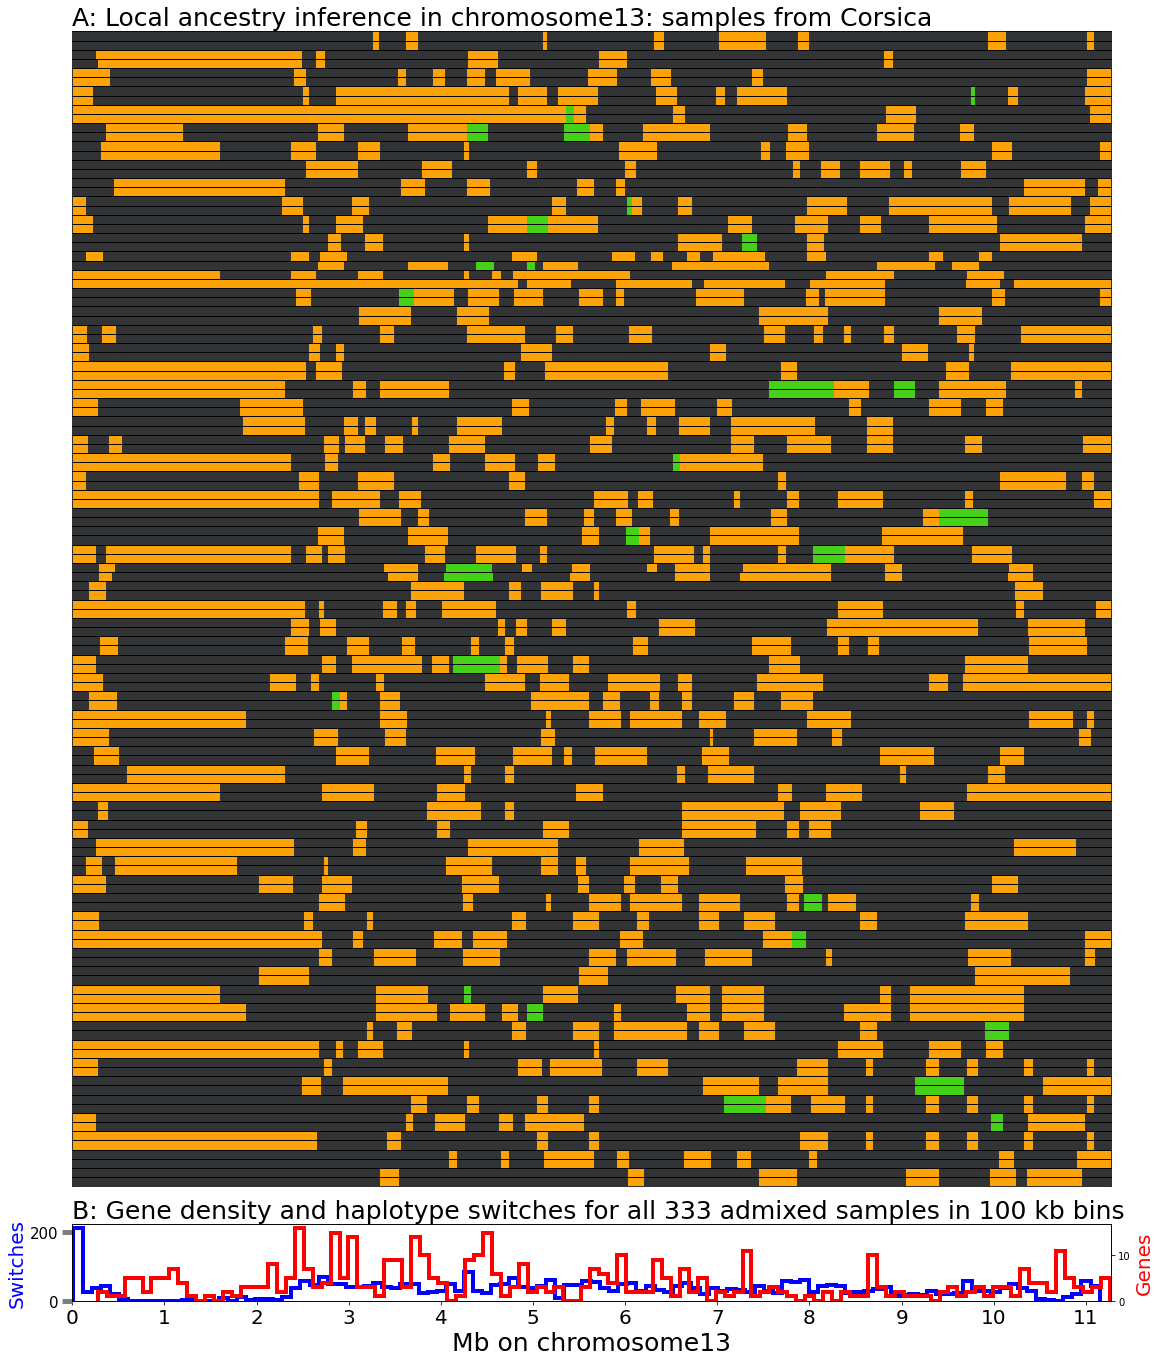

In [15]:
dataDict = {}
dataDictAgg = defaultdict(list)

chromosome = str(13)

with open('/home/avignal/Stage_M2/RFMix/SeqApiPopRFmixChr' + chromosome + '.msp.tsv') as csvFile:
    data=csv.reader(csvFile, delimiter = "\t")
    for row in data:
        if row:
            if not re.search('Subpopulation',row[0]):
                if re.search('chm',row[0]):
                    headers = row               #Get sample names
                    count = 0
                elif (not re.search('chm',row[0])) & (count == 0): #Initiate: first line into dictionary
                    for i in np.arange(6,len(row),1):
                        if row[i] == row[i]:
                            population = row[i]
                        else:
                            population = 9
                        dataDict[headers[i]] = [population,row[1],row[2],row[3],row[4]] #Assign population, start and end of CRF to sample
                    count = 1
                elif (count == 1):
                    for i in np.arange(6,len(row),1):
                        if row[i] == row[i]:
                            population = row[i]
                        else:
                            population = 9
                        if dataDict[headers[i]][0] == population:
                            dataDict[headers[i]][2] = row[2] #assign new End of CRF
                            dataDict[headers[i]][4] = row[4] #assign new End of CRF
                        elif dataDict[headers[i]][0] != population:     #change of population background
                            dataDictAgg["Sample"].append(headers[i]) #new entry for the sample
                            dataDictAgg["Start"].append(dataDict[headers[i]][1]) #
                            dataDictAgg["End"].append(dataDict[headers[i]][2])
                            dataDictAgg["StartGenet"].append(dataDict[headers[i]][3])
                            dataDictAgg["EndGenet"].append(dataDict[headers[i]][4])
                            dataDictAgg["Population"].append(dataDict[headers[i]][0])
                            dataDict[headers[i]] = [population,row[1],row[2],row[3],row[4]]
for i in np.arange(6,len(headers),1):
    dataDictAgg["Sample"].append(headers[i]) #new entry for the sample
    dataDictAgg["Start"].append(dataDict[headers[i]][1]) #
    dataDictAgg["End"].append(dataDict[headers[i]][2])
    dataDictAgg["StartGenet"].append(dataDict[headers[i]][3]) #
    dataDictAgg["EndGenet"].append(dataDict[headers[i]][4])
    dataDictAgg["Population"].append(dataDict[headers[i]][0])

dataAgg = pd.DataFrame.from_dict(dataDictAgg)
dataAgg = dataAgg.astype({'Start':'int','End':'int','StartGenet':'float','EndGenet':'float'})
dataAgg['Sample'] = dataAgg['Sample']
binWidth = 0.1 #in Mb
nbBins = math.ceil(max(dataAgg['End']/1000000) / binWidth)

# Add information on populations
dataSamples = pd.read_excel('/home/avignal/Stage_M2/SequenceGroups870_nouvelles.xlsx',sheet_name='869Samples')
dataSamples = dataSamples.loc[:,['name','RepresentsHive','CategPCA']]
dataSamples.columns = ['Sample','RepresentsHive','CategPCA']
dataSamples = dataSamples.set_index('Sample')
dataAgg = dataAgg.set_index('Sample')
dataAgg = dataAgg.join(dataSamples)
dataAgg = dataAgg.reset_index()

# Assign colour to segments
dataAgg['Colour'] =  "grey"
dataAgg.at[dataAgg.Population == "0",'Colour'] = "#323335ff"                    
dataAgg.at[dataAgg.Population == "1",'Colour'] = "#45d11aff"                     
dataAgg.at[dataAgg.Population == "2",'Colour'] = "#fca20aff"     
dataAgg


# Select samples to plot
#dataTableAggSampleSelection = dataAgg[dataAgg.Sample.str.contains('AOC',regex=True)]
dataTableAggSampleSelection = dataAgg[dataAgg.CategPCA == 'CorsicaNouvelles']
dataTableAggSampleSelection


# Sorted list of samples
sampleCor = dataTableAggSampleSelection['Sample'].unique().tolist()
sampleCor.sort()

#from itertools import chain, repeat

#sampleCor = list(chain.from_iterable(repeat(e, 2) for e in sampleCor))
#sampleCor

#import pandas as pd 
#from IPython.display import display 
#pd.set_option('display.max_rows', 2000) 
#display(dataTableAggSampleSelection)

ybins = len(sampleCor)
#space = (1 / (ybins + 1)) * 1 / 6
#figHeight = (ybins) # + 1) # * 3
figWidth = (max(dataAgg['End'])/5000000 * 8) # + space * 4
figHeight = figWidth / 1.7
#fig = plt.figure(figsize=(figWidth, figHeight))
#fig = plt.figure(figsize=(figWidth,4))
fig = plt.figure(figsize=(figWidth, figHeight))
#fig = plt.figure(constrained_layout=True, figsize=(45,40))

#fig.text(.35,.01, "Position (Mb)", fontsize=40)
#fig.text(0.05,0.50, "Samples from Corsica", fontsize=25, rotation='vertical',)

######################################################
##### First plot histogram of switches across all 333 samples
######################################################

ax = plt.axes([0.07, 0.23, 0.8, 0.1])

ax.hist(dataAgg[dataAgg.Start > 11712]['Start'],bins=nbBins, histtype='step', color = "blue", linewidth=4)
ax.set_xlim(0, max(dataAgg['End']))# /5000000)

xticks = list(np.arange(0,max(dataAgg['End']) ,1000000)) #* 5)
ax.set_xticks(xticks)        
ax.set_xticklabels([int(x / 1000000) for x in xticks], fontsize = 20)
plt.xlabel('Mb on chromosome' + chromosome, fontsize = 25)

ax.yaxis.set_tick_params(labelsize=15, length=10, width=5, color='grey')
ax.set_ylabel('Switches', fontsize = 20, color = "blue")

ax2 = ax.twinx()
chrGenesData = dfGnomon[(dfGnomon.chrom == int(chromosome))]
ax2.set_ylabel('Genes', fontsize = 20, color="red")
ax2.hist(chrGenesData['Pos'], bins=nbBins, histtype='step', color = "red", linewidth=4)

plt.title('B: Gene density and haplotype switches for all 333 admixed samples in 100 kb bins', fontsize = 25, loc='left')

######################################################
##### Then the samples from Corsica
######################################################

#fig.suptitle("Title", fontsize=96)
bottom = 0.38 #space
x_axis = 'yes'
count = 0
for i in sampleCor:
    count = count + 1
    left = 0 #space * 7
    width = figWidth
    height = (0.012)#/ybins)
    ax = plt.axes([0.07, bottom, 0.8, height])    
    if x_axis == 'yes':
        ax.axes.xaxis.set_visible(False)
        xticks = list(np.arange(0,max(dataAgg['End']/5000000) ,0.2)) #* 5)
        ax.set_xticks(xticks)        
        ax.set_xticklabels([int(x * 5) for x in xticks], fontsize = 15)
        plt.xlabel('Mb on chromosome 11', fontsize = 30)
        x_axis = 'false'
    else:
        ax.axes.xaxis.set_visible(False)
    if count == len(sampleCor):
        plt.title('A: Local ancestry inference in chromosome' + chromosome + ': samples from Corsica', fontsize = 25, loc='left')
    ax.axes.yaxis.set_visible(False)
    ax.set_xlim(0, max(dataAgg['End'])/5000000)
    bottom = bottom + height # + space
    dataSample = dataTableAggSampleSelection[dataTableAggSampleSelection.Sample == i]
    for index, row  in dataSample.iterrows():
        start = row["Start"] / 5000000
        end = row["End"] / 5000000
        color = row["Colour"]
        #ax.hlines(0, start, end, colors='orange', linestyles='solid')#, label='', *, data=None, **kwargs)[source]
        ax.axvspan(start, end, ymin=0.0, ymax=1.0, alpha=1, color=color)

#plt.tight_layout()        
#fig



# Plot Chromosome 14

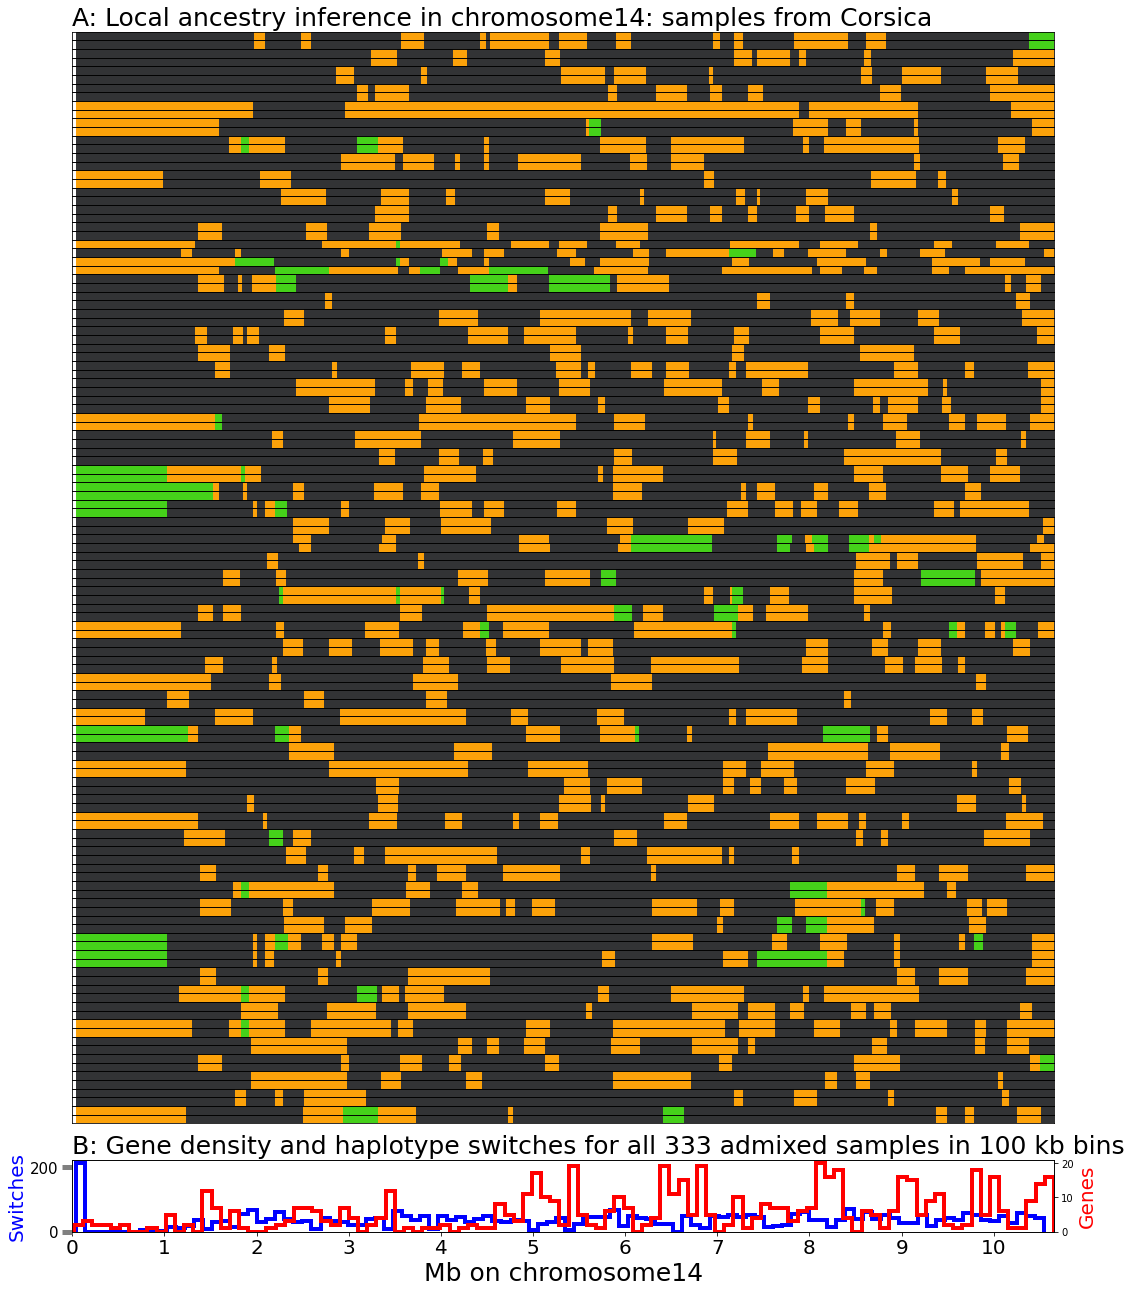

In [16]:
dataDict = {}
dataDictAgg = defaultdict(list)

chromosome = str(14)

with open('/home/avignal/Stage_M2/RFMix/SeqApiPopRFmixChr' + chromosome + '.msp.tsv') as csvFile:
    data=csv.reader(csvFile, delimiter = "\t")
    for row in data:
        if row:
            if not re.search('Subpopulation',row[0]):
                if re.search('chm',row[0]):
                    headers = row               #Get sample names
                    count = 0
                elif (not re.search('chm',row[0])) & (count == 0): #Initiate: first line into dictionary
                    for i in np.arange(6,len(row),1):
                        if row[i] == row[i]:
                            population = row[i]
                        else:
                            population = 9
                        dataDict[headers[i]] = [population,row[1],row[2],row[3],row[4]] #Assign population, start and end of CRF to sample
                    count = 1
                elif (count == 1):
                    for i in np.arange(6,len(row),1):
                        if row[i] == row[i]:
                            population = row[i]
                        else:
                            population = 9
                        if dataDict[headers[i]][0] == population:
                            dataDict[headers[i]][2] = row[2] #assign new End of CRF
                            dataDict[headers[i]][4] = row[4] #assign new End of CRF
                        elif dataDict[headers[i]][0] != population:     #change of population background
                            dataDictAgg["Sample"].append(headers[i]) #new entry for the sample
                            dataDictAgg["Start"].append(dataDict[headers[i]][1]) #
                            dataDictAgg["End"].append(dataDict[headers[i]][2])
                            dataDictAgg["StartGenet"].append(dataDict[headers[i]][3])
                            dataDictAgg["EndGenet"].append(dataDict[headers[i]][4])
                            dataDictAgg["Population"].append(dataDict[headers[i]][0])
                            dataDict[headers[i]] = [population,row[1],row[2],row[3],row[4]]
for i in np.arange(6,len(headers),1):
    dataDictAgg["Sample"].append(headers[i]) #new entry for the sample
    dataDictAgg["Start"].append(dataDict[headers[i]][1]) #
    dataDictAgg["End"].append(dataDict[headers[i]][2])
    dataDictAgg["StartGenet"].append(dataDict[headers[i]][3]) #
    dataDictAgg["EndGenet"].append(dataDict[headers[i]][4])
    dataDictAgg["Population"].append(dataDict[headers[i]][0])

dataAgg = pd.DataFrame.from_dict(dataDictAgg)
dataAgg = dataAgg.astype({'Start':'int','End':'int','StartGenet':'float','EndGenet':'float'})
dataAgg['Sample'] = dataAgg['Sample']
binWidth = 0.1 #in Mb
nbBins = math.ceil(max(dataAgg['End']/1000000) / binWidth)

# Add information on populations
dataSamples = pd.read_excel('/home/avignal/Stage_M2/SequenceGroups870_nouvelles.xlsx',sheet_name='869Samples')
dataSamples = dataSamples.loc[:,['name','RepresentsHive','CategPCA']]
dataSamples.columns = ['Sample','RepresentsHive','CategPCA']
dataSamples = dataSamples.set_index('Sample')
dataAgg = dataAgg.set_index('Sample')
dataAgg = dataAgg.join(dataSamples)
dataAgg = dataAgg.reset_index()

# Assign colour to segments
dataAgg['Colour'] =  "grey"
dataAgg.at[dataAgg.Population == "0",'Colour'] = "#323335ff"                    
dataAgg.at[dataAgg.Population == "1",'Colour'] = "#45d11aff"                     
dataAgg.at[dataAgg.Population == "2",'Colour'] = "#fca20aff"     
dataAgg


# Select samples to plot
#dataTableAggSampleSelection = dataAgg[dataAgg.Sample.str.contains('AOC',regex=True)]
dataTableAggSampleSelection = dataAgg[dataAgg.CategPCA == 'CorsicaNouvelles']
dataTableAggSampleSelection


# Sorted list of samples
sampleCor = dataTableAggSampleSelection['Sample'].unique().tolist()
sampleCor.sort()

#from itertools import chain, repeat

#sampleCor = list(chain.from_iterable(repeat(e, 2) for e in sampleCor))
#sampleCor

#import pandas as pd 
#from IPython.display import display 
#pd.set_option('display.max_rows', 2000) 
#display(dataTableAggSampleSelection)

ybins = len(sampleCor)
#space = (1 / (ybins + 1)) * 1 / 6
#figHeight = (ybins) # + 1) # * 3
figWidth = (max(dataAgg['End'])/5000000 * 8) # + space * 4
figHeight = figWidth / 1.7
#fig = plt.figure(figsize=(figWidth, figHeight))
#fig = plt.figure(figsize=(figWidth,4))
fig = plt.figure(figsize=(figWidth, figHeight))
#fig = plt.figure(constrained_layout=True, figsize=(45,40))

#fig.text(.35,.01, "Position (Mb)", fontsize=40)
#fig.text(0.05,0.50, "Samples from Corsica", fontsize=25, rotation='vertical',)

######################################################
##### First plot histogram of switches across all 333 samples
######################################################

ax = plt.axes([0.07, 0.23, 0.8, 0.1])

ax.hist(dataAgg[dataAgg.Start > 11712]['Start'],bins=nbBins, histtype='step', color = "blue", linewidth=4)
ax.set_xlim(0, max(dataAgg['End']))# /5000000)

xticks = list(np.arange(0,max(dataAgg['End']) ,1000000)) #* 5)
ax.set_xticks(xticks)        
ax.set_xticklabels([int(x / 1000000) for x in xticks], fontsize = 20)
plt.xlabel('Mb on chromosome' + chromosome, fontsize = 25)

ax.yaxis.set_tick_params(labelsize=15, length=10, width=5, color='grey')
ax.set_ylabel('Switches', fontsize = 20, color = "blue")

ax2 = ax.twinx()
chrGenesData = dfGnomon[(dfGnomon.chrom == int(chromosome))]
ax2.set_ylabel('Genes', fontsize = 20, color="red")
ax2.hist(chrGenesData['Pos'], bins=nbBins, histtype='step', color = "red", linewidth=4)

plt.title('B: Gene density and haplotype switches for all 333 admixed samples in 100 kb bins', fontsize = 25, loc='left')

######################################################
##### Then the samples from Corsica
######################################################

#fig.suptitle("Title", fontsize=96)
bottom = 0.38 #space
x_axis = 'yes'
count = 0
for i in sampleCor:
    count = count + 1
    left = 0 #space * 7
    width = figWidth
    height = (0.012)#/ybins)
    ax = plt.axes([0.07, bottom, 0.8, height])    
    if x_axis == 'yes':
        ax.axes.xaxis.set_visible(False)
        xticks = list(np.arange(0,max(dataAgg['End']/5000000) ,0.2)) #* 5)
        ax.set_xticks(xticks)        
        ax.set_xticklabels([int(x * 5) for x in xticks], fontsize = 15)
        plt.xlabel('Mb on chromosome 11', fontsize = 30)
        x_axis = 'false'
    else:
        ax.axes.xaxis.set_visible(False)
    if count == len(sampleCor):
        plt.title('A: Local ancestry inference in chromosome' + chromosome + ': samples from Corsica', fontsize = 25, loc='left')
    ax.axes.yaxis.set_visible(False)
    ax.set_xlim(0, max(dataAgg['End'])/5000000)
    bottom = bottom + height # + space
    dataSample = dataTableAggSampleSelection[dataTableAggSampleSelection.Sample == i]
    for index, row  in dataSample.iterrows():
        start = row["Start"] / 5000000
        end = row["End"] / 5000000
        color = row["Colour"]
        #ax.hlines(0, start, end, colors='orange', linestyles='solid')#, label='', *, data=None, **kwargs)[source]
        ax.axvspan(start, end, ymin=0.0, ymax=1.0, alpha=1, color=color)

#plt.tight_layout()        
#fig



# Plot Chromosome 15

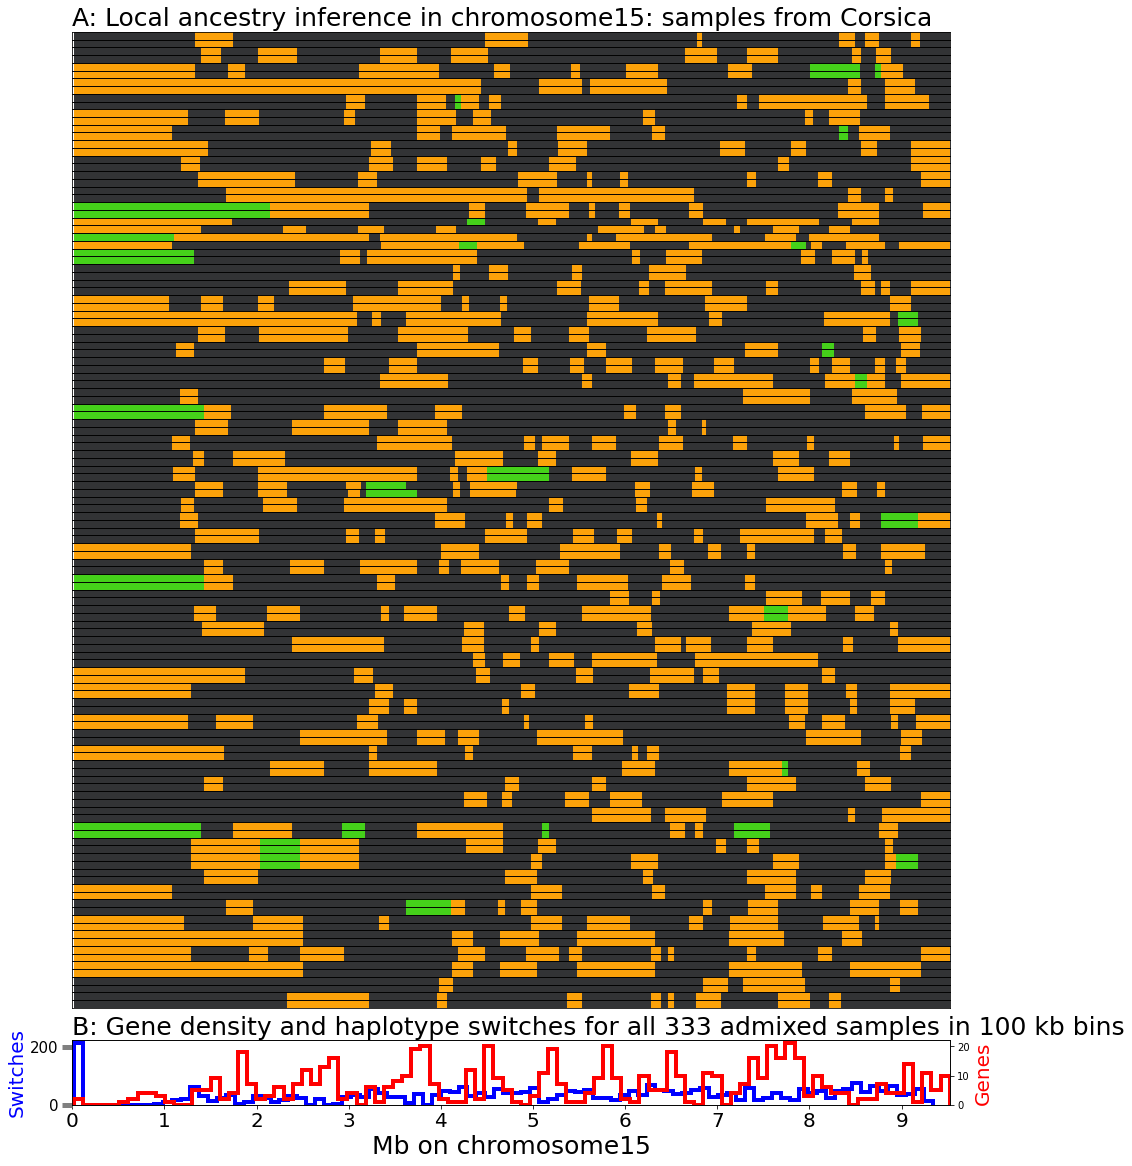

In [17]:
dataDict = {}
dataDictAgg = defaultdict(list)

chromosome = str(15)

with open('/home/avignal/Stage_M2/RFMix/SeqApiPopRFmixChr' + chromosome + '.msp.tsv') as csvFile:
    data=csv.reader(csvFile, delimiter = "\t")
    for row in data:
        if row:
            if not re.search('Subpopulation',row[0]):
                if re.search('chm',row[0]):
                    headers = row               #Get sample names
                    count = 0
                elif (not re.search('chm',row[0])) & (count == 0): #Initiate: first line into dictionary
                    for i in np.arange(6,len(row),1):
                        if row[i] == row[i]:
                            population = row[i]
                        else:
                            population = 9
                        dataDict[headers[i]] = [population,row[1],row[2],row[3],row[4]] #Assign population, start and end of CRF to sample
                    count = 1
                elif (count == 1):
                    for i in np.arange(6,len(row),1):
                        if row[i] == row[i]:
                            population = row[i]
                        else:
                            population = 9
                        if dataDict[headers[i]][0] == population:
                            dataDict[headers[i]][2] = row[2] #assign new End of CRF
                            dataDict[headers[i]][4] = row[4] #assign new End of CRF
                        elif dataDict[headers[i]][0] != population:     #change of population background
                            dataDictAgg["Sample"].append(headers[i]) #new entry for the sample
                            dataDictAgg["Start"].append(dataDict[headers[i]][1]) #
                            dataDictAgg["End"].append(dataDict[headers[i]][2])
                            dataDictAgg["StartGenet"].append(dataDict[headers[i]][3])
                            dataDictAgg["EndGenet"].append(dataDict[headers[i]][4])
                            dataDictAgg["Population"].append(dataDict[headers[i]][0])
                            dataDict[headers[i]] = [population,row[1],row[2],row[3],row[4]]
for i in np.arange(6,len(headers),1):
    dataDictAgg["Sample"].append(headers[i]) #new entry for the sample
    dataDictAgg["Start"].append(dataDict[headers[i]][1]) #
    dataDictAgg["End"].append(dataDict[headers[i]][2])
    dataDictAgg["StartGenet"].append(dataDict[headers[i]][3]) #
    dataDictAgg["EndGenet"].append(dataDict[headers[i]][4])
    dataDictAgg["Population"].append(dataDict[headers[i]][0])

dataAgg = pd.DataFrame.from_dict(dataDictAgg)
dataAgg = dataAgg.astype({'Start':'int','End':'int','StartGenet':'float','EndGenet':'float'})
dataAgg['Sample'] = dataAgg['Sample']
binWidth = 0.1 #in Mb
nbBins = math.ceil(max(dataAgg['End']/1000000) / binWidth)

# Add information on populations
dataSamples = pd.read_excel('/home/avignal/Stage_M2/SequenceGroups870_nouvelles.xlsx',sheet_name='869Samples')
dataSamples = dataSamples.loc[:,['name','RepresentsHive','CategPCA']]
dataSamples.columns = ['Sample','RepresentsHive','CategPCA']
dataSamples = dataSamples.set_index('Sample')
dataAgg = dataAgg.set_index('Sample')
dataAgg = dataAgg.join(dataSamples)
dataAgg = dataAgg.reset_index()

# Assign colour to segments
dataAgg['Colour'] =  "grey"
dataAgg.at[dataAgg.Population == "0",'Colour'] = "#323335ff"                    
dataAgg.at[dataAgg.Population == "1",'Colour'] = "#45d11aff"                     
dataAgg.at[dataAgg.Population == "2",'Colour'] = "#fca20aff"     
dataAgg


# Select samples to plot
#dataTableAggSampleSelection = dataAgg[dataAgg.Sample.str.contains('AOC',regex=True)]
dataTableAggSampleSelection = dataAgg[dataAgg.CategPCA == 'CorsicaNouvelles']
dataTableAggSampleSelection


# Sorted list of samples
sampleCor = dataTableAggSampleSelection['Sample'].unique().tolist()
sampleCor.sort()

#from itertools import chain, repeat

#sampleCor = list(chain.from_iterable(repeat(e, 2) for e in sampleCor))
#sampleCor

#import pandas as pd 
#from IPython.display import display 
#pd.set_option('display.max_rows', 2000) 
#display(dataTableAggSampleSelection)

ybins = len(sampleCor)
#space = (1 / (ybins + 1)) * 1 / 6
#figHeight = (ybins) # + 1) # * 3
figWidth = (max(dataAgg['End'])/5000000 * 8) # + space * 4
figHeight = figWidth / 1.7
#fig = plt.figure(figsize=(figWidth, figHeight))
#fig = plt.figure(figsize=(figWidth,4))
fig = plt.figure(figsize=(figWidth, figHeight))
#fig = plt.figure(constrained_layout=True, figsize=(45,40))

#fig.text(.35,.01, "Position (Mb)", fontsize=40)
#fig.text(0.05,0.50, "Samples from Corsica", fontsize=25, rotation='vertical',)

######################################################
##### First plot histogram of switches across all 333 samples
######################################################

ax = plt.axes([0.07, 0.23, 0.8, 0.1])

ax.hist(dataAgg[dataAgg.Start > 11712]['Start'],bins=nbBins, histtype='step', color = "blue", linewidth=4)
ax.set_xlim(0, max(dataAgg['End']))# /5000000)

xticks = list(np.arange(0,max(dataAgg['End']) ,1000000)) #* 5)
ax.set_xticks(xticks)        
ax.set_xticklabels([int(x / 1000000) for x in xticks], fontsize = 20)
plt.xlabel('Mb on chromosome' + chromosome, fontsize = 25)

ax.yaxis.set_tick_params(labelsize=15, length=10, width=5, color='grey')
ax.set_ylabel('Switches', fontsize = 20, color = "blue")

ax2 = ax.twinx()
chrGenesData = dfGnomon[(dfGnomon.chrom == int(chromosome))]
ax2.set_ylabel('Genes', fontsize = 20, color="red")
ax2.hist(chrGenesData['Pos'], bins=nbBins, histtype='step', color = "red", linewidth=4)

plt.title('B: Gene density and haplotype switches for all 333 admixed samples in 100 kb bins', fontsize = 25, loc='left')

######################################################
##### Then the samples from Corsica
######################################################

#fig.suptitle("Title", fontsize=96)
bottom = 0.38 #space
x_axis = 'yes'
count = 0
for i in sampleCor:
    count = count + 1
    left = 0 #space * 7
    width = figWidth
    height = (0.012)#/ybins)
    ax = plt.axes([0.07, bottom, 0.8, height])    
    if x_axis == 'yes':
        ax.axes.xaxis.set_visible(False)
        xticks = list(np.arange(0,max(dataAgg['End']/5000000) ,0.2)) #* 5)
        ax.set_xticks(xticks)        
        ax.set_xticklabels([int(x * 5) for x in xticks], fontsize = 15)
        plt.xlabel('Mb on chromosome 11', fontsize = 30)
        x_axis = 'false'
    else:
        ax.axes.xaxis.set_visible(False)
    if count == len(sampleCor):
        plt.title('A: Local ancestry inference in chromosome' + chromosome + ': samples from Corsica', fontsize = 25, loc='left')
    ax.axes.yaxis.set_visible(False)
    ax.set_xlim(0, max(dataAgg['End'])/5000000)
    bottom = bottom + height # + space
    dataSample = dataTableAggSampleSelection[dataTableAggSampleSelection.Sample == i]
    for index, row  in dataSample.iterrows():
        start = row["Start"] / 5000000
        end = row["End"] / 5000000
        color = row["Colour"]
        #ax.hlines(0, start, end, colors='orange', linestyles='solid')#, label='', *, data=None, **kwargs)[source]
        ax.axvspan(start, end, ymin=0.0, ymax=1.0, alpha=1, color=color)

#plt.tight_layout()        
#fig



# Plot Chromosome 16

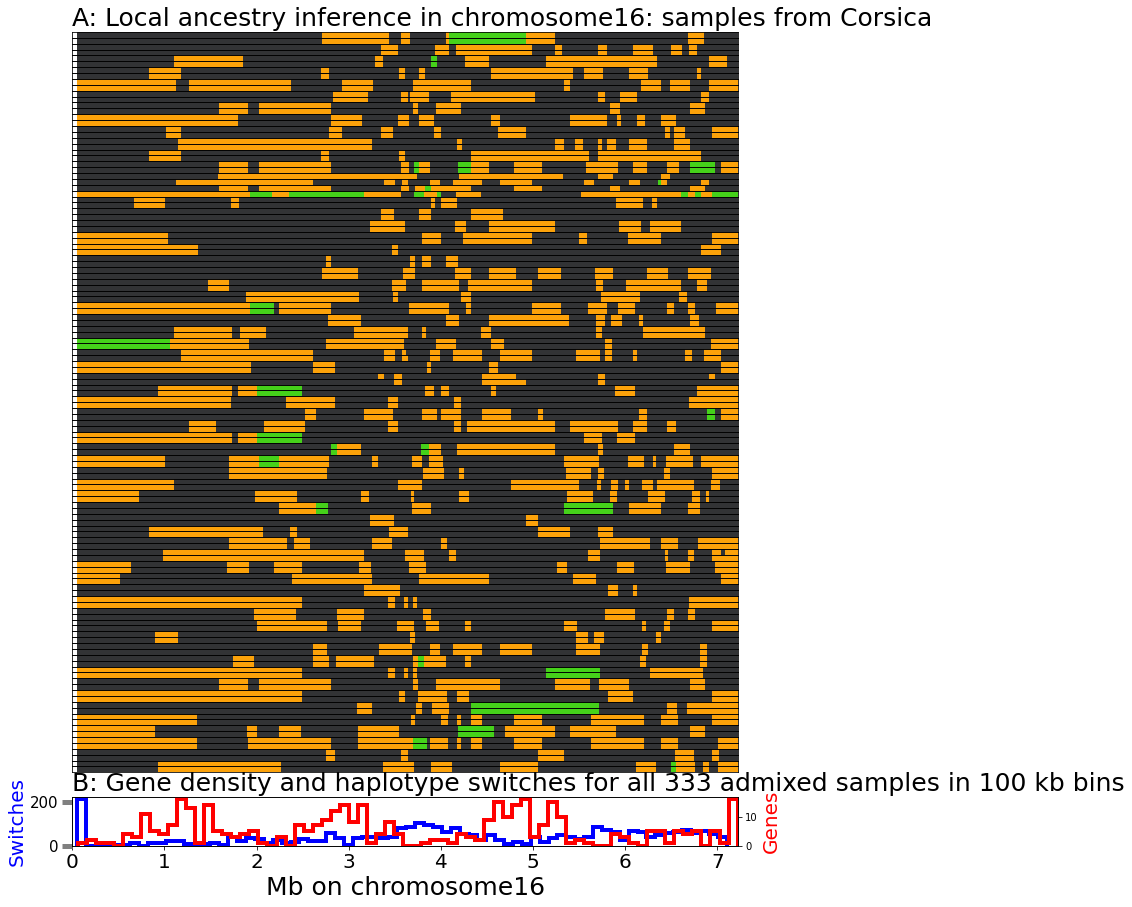

In [18]:
dataDict = {}
dataDictAgg = defaultdict(list)

chromosome = str(16)

with open('/home/avignal/Stage_M2/RFMix/SeqApiPopRFmixChr' + chromosome + '.msp.tsv') as csvFile:
    data=csv.reader(csvFile, delimiter = "\t")
    for row in data:
        if row:
            if not re.search('Subpopulation',row[0]):
                if re.search('chm',row[0]):
                    headers = row               #Get sample names
                    count = 0
                elif (not re.search('chm',row[0])) & (count == 0): #Initiate: first line into dictionary
                    for i in np.arange(6,len(row),1):
                        if row[i] == row[i]:
                            population = row[i]
                        else:
                            population = 9
                        dataDict[headers[i]] = [population,row[1],row[2],row[3],row[4]] #Assign population, start and end of CRF to sample
                    count = 1
                elif (count == 1):
                    for i in np.arange(6,len(row),1):
                        if row[i] == row[i]:
                            population = row[i]
                        else:
                            population = 9
                        if dataDict[headers[i]][0] == population:
                            dataDict[headers[i]][2] = row[2] #assign new End of CRF
                            dataDict[headers[i]][4] = row[4] #assign new End of CRF
                        elif dataDict[headers[i]][0] != population:     #change of population background
                            dataDictAgg["Sample"].append(headers[i]) #new entry for the sample
                            dataDictAgg["Start"].append(dataDict[headers[i]][1]) #
                            dataDictAgg["End"].append(dataDict[headers[i]][2])
                            dataDictAgg["StartGenet"].append(dataDict[headers[i]][3])
                            dataDictAgg["EndGenet"].append(dataDict[headers[i]][4])
                            dataDictAgg["Population"].append(dataDict[headers[i]][0])
                            dataDict[headers[i]] = [population,row[1],row[2],row[3],row[4]]
for i in np.arange(6,len(headers),1):
    dataDictAgg["Sample"].append(headers[i]) #new entry for the sample
    dataDictAgg["Start"].append(dataDict[headers[i]][1]) #
    dataDictAgg["End"].append(dataDict[headers[i]][2])
    dataDictAgg["StartGenet"].append(dataDict[headers[i]][3]) #
    dataDictAgg["EndGenet"].append(dataDict[headers[i]][4])
    dataDictAgg["Population"].append(dataDict[headers[i]][0])

dataAgg = pd.DataFrame.from_dict(dataDictAgg)
dataAgg = dataAgg.astype({'Start':'int','End':'int','StartGenet':'float','EndGenet':'float'})
dataAgg['Sample'] = dataAgg['Sample']
binWidth = 0.1 #in Mb
nbBins = math.ceil(max(dataAgg['End']/1000000) / binWidth)

# Add information on populations
dataSamples = pd.read_excel('/home/avignal/Stage_M2/SequenceGroups870_nouvelles.xlsx',sheet_name='869Samples')
dataSamples = dataSamples.loc[:,['name','RepresentsHive','CategPCA']]
dataSamples.columns = ['Sample','RepresentsHive','CategPCA']
dataSamples = dataSamples.set_index('Sample')
dataAgg = dataAgg.set_index('Sample')
dataAgg = dataAgg.join(dataSamples)
dataAgg = dataAgg.reset_index()

# Assign colour to segments
dataAgg['Colour'] =  "grey"
dataAgg.at[dataAgg.Population == "0",'Colour'] = "#323335ff"                    
dataAgg.at[dataAgg.Population == "1",'Colour'] = "#45d11aff"                     
dataAgg.at[dataAgg.Population == "2",'Colour'] = "#fca20aff"     
dataAgg


# Select samples to plot
#dataTableAggSampleSelection = dataAgg[dataAgg.Sample.str.contains('AOC',regex=True)]
dataTableAggSampleSelection = dataAgg[dataAgg.CategPCA == 'CorsicaNouvelles']
dataTableAggSampleSelection


# Sorted list of samples
sampleCor = dataTableAggSampleSelection['Sample'].unique().tolist()
sampleCor.sort()

#from itertools import chain, repeat

#sampleCor = list(chain.from_iterable(repeat(e, 2) for e in sampleCor))
#sampleCor

#import pandas as pd 
#from IPython.display import display 
#pd.set_option('display.max_rows', 2000) 
#display(dataTableAggSampleSelection)

ybins = len(sampleCor)
#space = (1 / (ybins + 1)) * 1 / 6
#figHeight = (ybins) # + 1) # * 3
figWidth = (max(dataAgg['End'])/5000000 * 8) # + space * 4
figHeight = figWidth / 1.7
#fig = plt.figure(figsize=(figWidth, figHeight))
#fig = plt.figure(figsize=(figWidth,4))
fig = plt.figure(figsize=(figWidth, figHeight))
#fig = plt.figure(constrained_layout=True, figsize=(45,40))

#fig.text(.35,.01, "Position (Mb)", fontsize=40)
#fig.text(0.05,0.50, "Samples from Corsica", fontsize=25, rotation='vertical',)

######################################################
##### First plot histogram of switches across all 333 samples
######################################################

ax = plt.axes([0.07, 0.23, 0.8, 0.1])

ax.hist(dataAgg[dataAgg.Start > 11712]['Start'],bins=nbBins, histtype='step', color = "blue", linewidth=4)
ax.set_xlim(0, max(dataAgg['End']))# /5000000)

xticks = list(np.arange(0,max(dataAgg['End']) ,1000000)) #* 5)
ax.set_xticks(xticks)        
ax.set_xticklabels([int(x / 1000000) for x in xticks], fontsize = 20)
plt.xlabel('Mb on chromosome' + chromosome, fontsize = 25)

ax.yaxis.set_tick_params(labelsize=15, length=10, width=5, color='grey')
ax.set_ylabel('Switches', fontsize = 20, color = "blue")

ax2 = ax.twinx()
chrGenesData = dfGnomon[(dfGnomon.chrom == int(chromosome))]
ax2.set_ylabel('Genes', fontsize = 20, color="red")
ax2.hist(chrGenesData['Pos'], bins=nbBins, histtype='step', color = "red", linewidth=4)

plt.title('B: Gene density and haplotype switches for all 333 admixed samples in 100 kb bins', fontsize = 25, loc='left')

######################################################
##### Then the samples from Corsica
######################################################

#fig.suptitle("Title", fontsize=96)
bottom = 0.38 #space
x_axis = 'yes'
count = 0
for i in sampleCor:
    count = count + 1
    left = 0 #space * 7
    width = figWidth
    height = (0.012)#/ybins)
    ax = plt.axes([0.07, bottom, 0.8, height])    
    if x_axis == 'yes':
        ax.axes.xaxis.set_visible(False)
        xticks = list(np.arange(0,max(dataAgg['End']/5000000) ,0.2)) #* 5)
        ax.set_xticks(xticks)        
        ax.set_xticklabels([int(x * 5) for x in xticks], fontsize = 15)
        plt.xlabel('Mb on chromosome 11', fontsize = 30)
        x_axis = 'false'
    else:
        ax.axes.xaxis.set_visible(False)
    if count == len(sampleCor):
        plt.title('A: Local ancestry inference in chromosome' + chromosome + ': samples from Corsica', fontsize = 25, loc='left')
    ax.axes.yaxis.set_visible(False)
    ax.set_xlim(0, max(dataAgg['End'])/5000000)
    bottom = bottom + height # + space
    dataSample = dataTableAggSampleSelection[dataTableAggSampleSelection.Sample == i]
    for index, row  in dataSample.iterrows():
        start = row["Start"] / 5000000
        end = row["End"] / 5000000
        color = row["Colour"]
        #ax.hlines(0, start, end, colors='orange', linestyles='solid')#, label='', *, data=None, **kwargs)[source]
        ax.axvspan(start, end, ymin=0.0, ymax=1.0, alpha=1, color=color)

#plt.tight_layout()        
#fig

